In [1]:
# import modules

import urllib
import json
from pprint import pprint
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# extract all the files from the zip folder to current working directory
from zipfile import ZipFile
from mapbox import Geocoder
import requests
from Config import token
import time
# You have to install some of these libs such as descartes, geopandas
# for geopandas, do "conda install geopandas" in cmd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import style
import shapely.speedups

In [4]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "8c233bc2-1879-44ff-a0e4-9b69a9032c54"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())
pprint(package)

{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show',
 'result': {'creator_user_id': '150d5301-86ec-44a3-a070-50f2cea839c9',
            'dataset_category': 'Document',
            'excerpt': 'This dataset contains non-identifiable information '
                       'relating to each parking ticket issued for each '
                       'calendar year since 2008.',
            'formats': 'XLS,ZIP',
            'groups': [],
            'id': '8c233bc2-1879-44ff-a0e4-9b69a9032c54',
            'information_url': 'http://www.toronto.ca/pay-toronto-tickets/parkingtickets/index.htm',
            'is_retired': False,
            'isopen': True,
            'last_refreshed': '2019-07-23T17:51:57.153365',
            'license_id': 'other-open',
            'license_title': 'Other (Open)',
            'metadata_created': '2019-07-23T17:50:14.331462',
            'metadata_modified': '2019-11-06T15:23:09.564050',
            'name': 'parking-ti

In [10]:
# Get data url for year 2016, 2017 and 2018 and download the zip files of each year, and extract them
for i in range(3):
    filedata_url = package["result"]["resources"][i+8]["url"]
    print(filedata_url)
    # Request the data online
    data = requests.get(filedata_url)
    #store the downloaded file in the parking2018.zip 
    open(f'Resources/parking201{i+6}.zip', 'wb').write(data.content)
    # Extract the zip file
    with ZipFile(f"Resources/parking201{i+6}.zip","r") as zfile:
        zfile.extractall("Resources")

https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/1044f9dc-208f-4011-895c-9497b8b9912a/download/parking-tickets-2016.zip
https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/3531cede-396a-48a2-af8d-ddd8ac8a8a63/download/parking-tickets-2017.zip
https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/e0df3b42-8515-492b-ba85-a55c4cfd035f/download/parking-tickets-2018.zip


In [2]:
# Read csv files of the parking data of year 2016, 2017, 2018

# Define a concatenate function to combine all the csv files of each year
def concatenate(*argmt):
    data_df = pd.DataFrame()
    for i in argmt:
        data_df = data_df.append(pd.read_csv(i))
    return data_df
complete_data_2016 = concatenate("Resources/Parking_Tags_Data_2016_1.csv","Resources/Parking_Tags_Data_2016_2.csv","Resources/Parking_Tags_Data_2016_3.csv","Resources/Parking_Tags_Data_2016_4.csv")
complete_data_2017 = concatenate("Resources/Parking_Tags_Data_2017_1.csv","Resources/Parking_Tags_Data_2017_2.csv","Resources/Parking_Tags_Data_2017_3.csv")
complete_data_2018 = concatenate("Resources/Parking_Tags_Data_2018_1.csv","Resources/Parking_Tags_Data_2018_2.csv","Resources/Parking_Tags_Data_2018_3.csv")


In [3]:
complete_data_2018.head()

tag_number_masked  date_of_infraction  infraction_code  \
0          ***92517            20180101               16   
1          ***71708            20180101               29   
2          ***92311            20180101               29   
3          ***92312            20180101               29   
4          ***71709            20180101               29   

           infraction_description  set_fine_amount  time_of_infraction  \
0   PARK-WITHIN 9M INTERSECT ROAD               50                 0.0   
1  PARK PROHIBITED TIME NO PERMIT               30                 2.0   
2  PARK PROHIBITED TIME NO PERMIT               30                 2.0   
3  PARK PROHIBITED TIME NO PERMIT               30                 2.0   
4  PARK PROHIBITED TIME NO PERMIT               30                 3.0   

  location1          location2 location3      location4 province  
0       S/S          PRYOR AVE       E/O  CLOVERDALE RD       ON  
1        NR  266 DOVERCOURT RD       NaN            NaN       ON  
2        NR    15 FAIRBANK AVE       NaN            NaN       ON  
3        NR    15 FAIRBANK AVE       NaN            NaN       ON  
4        NR  266 DOVERCOURT RD       NaN            NaN       ON

In [4]:
# See the data types
complete_data.dtypes

NameError: name 'complete_data' is not defined

In [5]:
# Fill the NaN cells with nothing inside it
new_data_2016 = complete_data_2016.fillna("")
new_data_2017 = complete_data_2017.fillna("")
new_data_2018 = complete_data_2018.fillna("")

# Preview
new_data_2016.head()

tag_number_masked  date_of_infraction infraction_code  \
0          ***03850            20160101              29   
1          ***03851            20160101              29   
2          ***98221            20160101              29   
3          ***85499            20160101              29   
4          ***03852            20160101             406   

           infraction_description  set_fine_amount time_of_infraction  \
0  PARK PROHIBITED TIME NO PERMIT               30                  0   
1  PARK PROHIBITED TIME NO PERMIT               30                  1   
2  PARK PROHIBITED TIME NO PERMIT               30                  2   
3  PARK PROHIBITED TIME NO PERMIT               30                  2   
4   PARK-VEH. W/O VALID ONT PLATE               40                  2   

  location1         location2 location3 location4 province  
0        NR  49 GLOUCESTER ST                           ON  
1        NR  45 GLOUCESTER ST                           ON  
2        NR     274 GEORGE ST                           ON  
3        NR     270 GEORGE ST                           ON  
4        NR  45 GLOUCESTER ST                           ON

In [6]:
# Group data set by dates for year 2018
grouped_data = new_data_2018.groupby("date_of_infraction")

# Show the grouped data
grouped_data.first().head()

tag_number_masked  infraction_code  \
date_of_infraction                                      
20180101                    ***92517               16   
20180102                    ***37208                3   
20180103                    ***86273               15   
20180104                    ***74668               29   
20180105                    ***70908               29   

                            infraction_description  set_fine_amount  \
date_of_infraction                                                    
20180101             PARK-WITHIN 9M INTERSECT ROAD               50   
20180102                  PARK ON PRIVATE PROPERTY               30   
20180103            PARK-WITHIN 3M OF FIRE HYDRANT              100   
20180104            PARK PROHIBITED TIME NO PERMIT               30   
20180105            PARK PROHIBITED TIME NO PERMIT               30   

                    time_of_infraction location1           location2  \
date_of_infraction                                                     
20180101                           0.0       S/S           PRYOR AVE   
20180102                           0.0        AT  50 GRAYDON HALL DR   
20180103                           2.0        NR       5095 YONGE ST   
20180104                           0.0        NR      55 MAITLAND ST   
20180105                           1.0       S/S          ST MARY ST   

                   location3      location4 province  
date_of_infraction                                    
20180101                 E/O  CLOVERDALE RD       ON  
20180102                                          ON  
20180103                                          ON  
20180104                                          ON  
20180105                 W/O       YONGE ST       ON

In [16]:
# Only for year 2018
# Get the address at which each infraction took place with date
# Create a blank dictionary to store addresses for specific dates
address_book = {}

# Loop through each date and extract addresses for the same day
for date in grouped_data:
    # Create a blank list to store addresses for the same day
    address = []
    # date_data represent a data set for a specific day, e.g. 20180101
    date_data = pd.DataFrame(date[1]) # Transfer the tuple into data frame
    for index, row in date_data.iterrows():
        # Adding all the addresses up into a list
        if row["location3"] != "":
            # if it is an interscetion of 2 streets, We will ignore this type of records for the heat mapping as it only consist of a small amount of the entire data set
            pass
        else:
            # if only a street with a unit number
            address.append(str(row["location2"]))
        address_book[date[0]] = address # update the address_book dict, date[0] is the date, e.g. 20180101

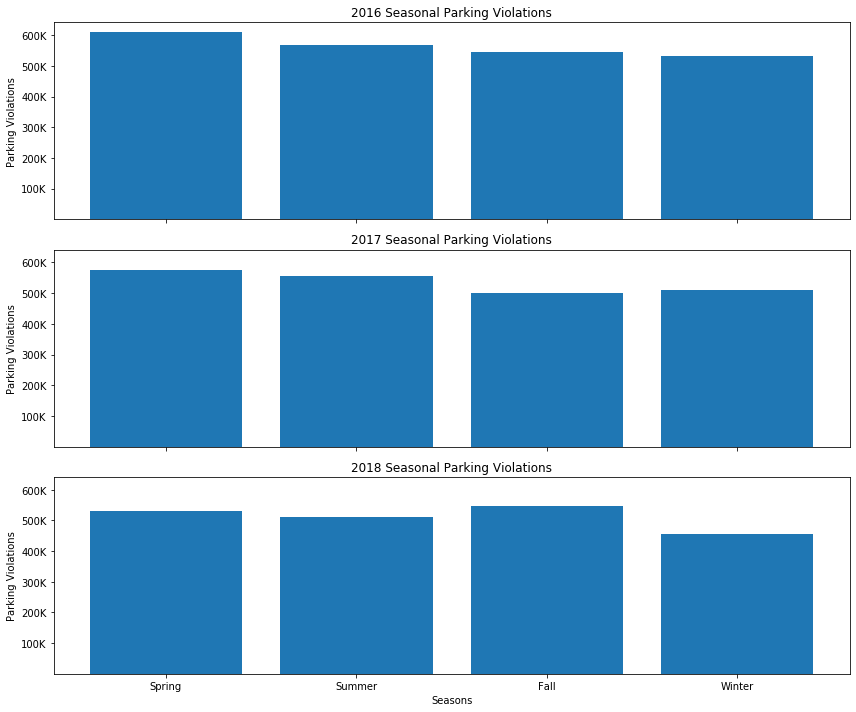

In [66]:
# Organize the data frame by seasons
# From the internet, 
# Spring - March 20 to June 20. Spring is a rainy season in most parts of Ontario. ...
# Summer - June 21 to September 21. ...
# Fall (or Autumn) - September 22 to December 20. ...
# Winter - December 21 to March 19.

# Create a figure with 3 sub plots
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,10),sharex = "col",sharey = True)

for index, item in enumerate([new_data_2016,new_data_2017,new_data_2018]):
    spring = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0320"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0620"))),:]
    summer = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0621"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0921"))),:]
    fall = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0922"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1220"))),:]
    winter = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1221"))) | (item["date_of_infraction"]<=(int(f"201{index+6}0319"))),:]
    
    # Get total tickets granted for each season
    num_tickets_spring = len(spring)
    num_tickets_summer = len(summer)
    num_tickets_fall = len(fall)
    num_tickets_winter = len(winter)

    # Bar chart for seasonal ticketing
    
    [ax1,ax2,ax3][index].bar([1,2,3,4],[num_tickets_spring, num_tickets_summer, num_tickets_fall, num_tickets_winter])
    
    plt.xticks([1,2,3,4],["Spring", "Summer", "Fall", "Winter"])
    plt.yticks([100000,200000,300000,400000,500000,600000],["100K","200K","300K","400K","500K","600K"])
    plt.xlabel("Seasons")
    [ax1,ax2,ax3][index].set_ylabel("Parking Violations")
    [ax1,ax2,ax3][index].set_title(f"{2016+index} Seasonal Parking Violations")
    plt.tight_layout()
    
# Save the bar chart
plt.savefig("Results/2016 Seasonal Parking Violations.png")

# Show the figure
plt.show()



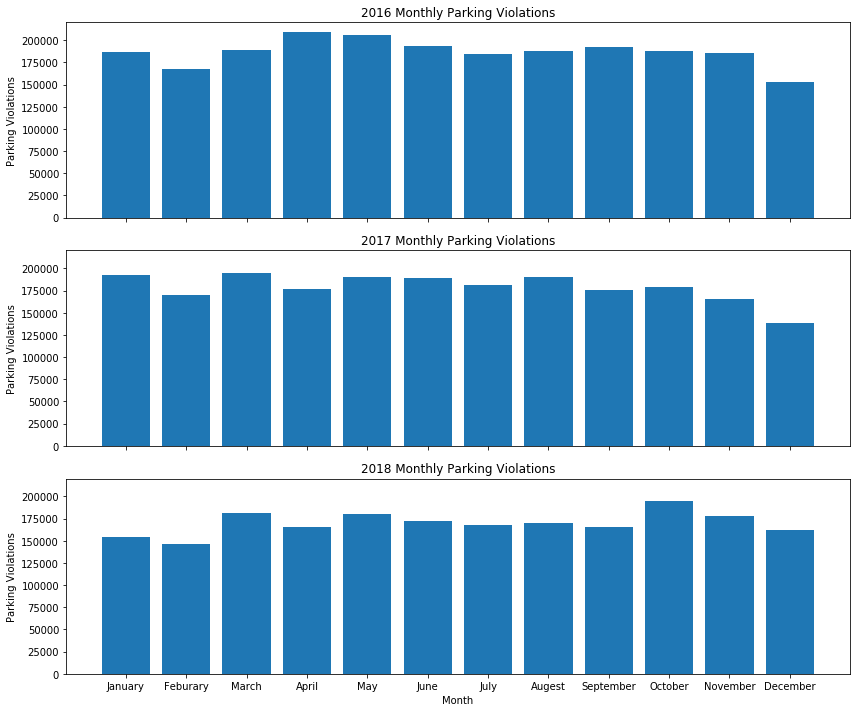

In [70]:
# Create a figure with 3 sub plots
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,10),sharex = "col",sharey = True)

for index, item in enumerate([new_data_2016,new_data_2017,new_data_2018]):
    # Organize the data frame by months
    Jan = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0101"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0131"))),:]
    Feb = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0201"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0228"))),:]
    Mar = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0301"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0331"))),:]
    Apr = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0401"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0430"))),:]
    May = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0501"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0531"))),:]
    Jun = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0601"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0630"))),:]
    Jul = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0701"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0731"))),:]
    Aug = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0801"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0831"))),:]
    Sep = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0901"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0930"))),:]
    Oct = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1001"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1031"))),:]
    Nov = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1101"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1130"))),:]
    Dec = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1201"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1230"))),:]

    tol_Jan = len(Jan)
    tol_Feb = len(Feb)
    tol_Mar = len(Mar)
    tol_Apr = len(Apr)
    tol_May = len(May)
    tol_Jun = len(Jun)
    tol_Jul = len(Jul)
    tol_Aug = len(Aug)
    tol_Sep = len(Sep)
    tol_Oct = len(Oct)
    tol_Nov = len(Nov)
    tol_Dec = len(Dec)

    # Bar chart for monthly ticketing
    [ax1,ax2,ax3][index].bar([1,2,3,4,5,6,7,8,9,10,11,12],[tol_Jan,tol_Feb,tol_Mar,tol_Apr,tol_May,tol_Jun,tol_Jul,tol_Aug,tol_Sep,tol_Oct,tol_Nov,tol_Dec])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["January", "Feburary", "March", "April","May","June","July","Augest","September","October","November","December"])
    plt.xlabel("Month")
    [ax1,ax2,ax3][index].set_ylabel("Parking Violations")
    [ax1,ax2,ax3][index].set_title(f"{2016+index} Monthly Parking Violations")
    plt.tight_layout()
# Save the bar chart
plt.savefig("Results/2016 Monthly Parking Violations.png")

# Show the figure
plt.show()



In [86]:
# Discover the 10 kinds of infractions drivers usually get the most
# Group data by infraction type
inf_type = new_data.groupby("infraction_description").count()
most_viloated = list(inf_type.sort_values("tag_number_masked", ascending = False).head(10).index)
print("The first 10 most commited parking infractions:\n")
for i in most_viloated:
    print(f"No.{most_viloated.index(i)+1}: {i}")
    print("Total Infractions: " + str(inf_type.loc[i,"tag_number_masked"])+"\n")

The first 10 most commited parking infractions:

No.1: PARK ON PRIVATE PROPERTY
Total Infractions: 393451

No.2: PARK-SIGNED HWY-PROHIBIT DY/TM
Total Infractions: 337268

No.3: PARK PROHIBITED TIME NO PERMIT
Total Infractions: 298487

No.4: PARK MACHINE-REQD FEE NOT PAID
Total Infractions: 231652

No.5: PARK - LONGER THAN 3 HOURS
Total Infractions: 113134

No.6: STOP-SIGNED HWY-PROHIBIT TM/DY
Total Infractions: 103525

No.7: PARK-VEH. W/O VALID ONT PLATE
Total Infractions: 88263

No.8: STAND VEH.-PROHIBIT TIME/DAY
Total Infractions: 73121

No.9: STOP-SIGNED HIGHWAY-RUSH HOUR
Total Infractions: 67693

No.10: PARK-SIGNED HWY-EXC PERMT TIME
Total Infractions: 52498



In [2]:
country="Canada"
city="Toronto"
address="5 St.George Street"

In [3]:
geocoder = Geocoder(access_token=token)

In [4]:
lat=response['features'][0]['center'][0]
lng=response['features'][0]['center'][1]

NameError: name 'response' is not defined

In [7]:
# Use year 2018 for analysis, only get the records with specific address with it so we can plot it in the map 
location_df=new_data_2018.loc[new_data_2018['location4']==""]

In [8]:
location_df.head()

tag_number_masked  date_of_infraction  infraction_code  \
1          ***71708            20180101               29   
2          ***92311            20180101               29   
3          ***92312            20180101               29   
4          ***71709            20180101               29   
5          ***73023            20180101                3   

           infraction_description  set_fine_amount time_of_infraction  \
1  PARK PROHIBITED TIME NO PERMIT               30                  2   
2  PARK PROHIBITED TIME NO PERMIT               30                  2   
3  PARK PROHIBITED TIME NO PERMIT               30                  2   
4  PARK PROHIBITED TIME NO PERMIT               30                  3   
5        PARK ON PRIVATE PROPERTY               30                  3   

  location1          location2 location3 location4 province  
1        NR  266 DOVERCOURT RD                           ON  
2        NR    15 FAIRBANK AVE                           ON  
3        NR    15 FAIRBANK AVE                           ON  
4        NR  266 DOVERCOURT RD                           ON  
5        AT     735 COLLEGE ST                           ON

In [9]:
location_df["Date"]= pd.to_datetime(location_df['date_of_infraction'].astype(str), format='%Y%m%d')
location_df.head()

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


tag_number_masked  date_of_infraction  infraction_code  \
1          ***71708            20180101               29   
2          ***92311            20180101               29   
3          ***92312            20180101               29   
4          ***71709            20180101               29   
5          ***73023            20180101                3   

           infraction_description  set_fine_amount time_of_infraction  \
1  PARK PROHIBITED TIME NO PERMIT               30                  2   
2  PARK PROHIBITED TIME NO PERMIT               30                  2   
3  PARK PROHIBITED TIME NO PERMIT               30                  2   
4  PARK PROHIBITED TIME NO PERMIT               30                  3   
5        PARK ON PRIVATE PROPERTY               30                  3   

  location1          location2 location3 location4 province       Date  
1        NR  266 DOVERCOURT RD                           ON 2018-01-01  
2        NR    15 FAIRBANK AVE                           ON 2018-01-01  
3        NR    15 FAIRBANK AVE                           ON 2018-01-01  
4        NR  266 DOVERCOURT RD                           ON 2018-01-01  
5        AT     735 COLLEGE ST                           ON 2018-01-01

In [10]:
February_df=location_df.loc[(location_df['Date'].dt.month==2)]

In [11]:
February_location_coordinates = pd.DataFrame({"location":February_df["location2"].unique()})
February_location_coordinates.head()
#response = geocoder.forward({location,bbox=[-79.646249,43.551428,-79.114444,43.882203],limit=1).json()
#response

location
0  2531 LAKE SHORE BLVD W
1          118 GOTHIC AVE
2       259 DELORAINE AVE
3           50 QUEBEC AVE
4             305 SHAW ST

In [12]:
# Add two columns, latitude and longitude to the data frame
February_location_coordinates["Lat"]=''
February_location_coordinates["Lng"]=''
February_location_coordinates.head()

location Lat Lng
0  2531 LAKE SHORE BLVD W        
1          118 GOTHIC AVE        
2       259 DELORAINE AVE        
3           50 QUEBEC AVE        
4             305 SHAW ST

In [48]:
num=0.1
for index, row in February_location_coordinates.iterrows(): 
        location = row["location"]
        print(location)
        try:
            time.sleep(num)
            response = geocoder.forward(location,bbox=[-79.646249,43.551428,-79.114444,43.882203],limit=1).json()
            print(f"Processing Record {(index+1)} of {len(February_location_coordinates)}")
            February_location_coordinates.loc[index, "Lat"] = response['features'][0]['center'][0]
            February_location_coordinates.loc[index, "Lng"] = response['features'][0]['center'][1]
        except:
            print("location not found. Skipping...")

2531 LAKE SHORE BLVD W
Processing Record 1 of 41834
118 GOTHIC AVE
Processing Record 2 of 41834
259 DELORAINE AVE
Processing Record 3 of 41834
50 QUEBEC AVE
Processing Record 4 of 41834
305 SHAW ST
Processing Record 5 of 41834
121 SCOLLARD ST
Processing Record 6 of 41834
128 MOUNTJOY AVE
Processing Record 7 of 41834
2468 EGLINTON AVE W
Processing Record 8 of 41834
110 CHARLES ST E
Processing Record 9 of 41834
49 HAZELTON AVE
Processing Record 10 of 41834
28 HOLBORNE AVE
Processing Record 11 of 41834
235 DELORAINE AVE
Processing Record 12 of 41834
1340 DANFORTH ROAD
Processing Record 13 of 41834
51 HAZELTON AVE
Processing Record 14 of 41834
325 QUEBEC AVE
Processing Record 15 of 41834
98 FORT YORK BLVD
Processing Record 16 of 41834
14 MEADOW AVE
Processing Record 17 of 41834
25 ST MARY ST
Processing Record 18 of 41834
88 CHARLES ST E
Processing Record 19 of 41834
15 WEBSTER AVE
Processing Record 20 of 41834
1 MEADOW AVE
Processing Record 21 of 41834
70 DAN LECKIE WAY
Processing Record 2

Processing Record 177 of 41834
43 HAMMERSMITH AVE
Processing Record 178 of 41834
283 ST GERMAIN AVE
Processing Record 179 of 41834
42 HUBBARD BLVD
Processing Record 180 of 41834
151 HALLAM ST
Processing Record 181 of 41834
155 VAUGHAN RD
Processing Record 182 of 41834
165 LOWTHER AVE
Processing Record 183 of 41834
75 HUNTLEY ST
Processing Record 184 of 41834
12 OAKMOUNT RD
Processing Record 185 of 41834
105 SCARBORO BEACH BLVD
Processing Record 186 of 41834
54 EPSOM AVE
Processing Record 187 of 41834
188 HALLAM ST
Processing Record 188 of 41834
169 HURON ST
Processing Record 189 of 41834
219 FORT YORK BLVD
Processing Record 190 of 41834
111 PACIFIC AVE
Processing Record 191 of 41834
42 EPSOM AVE
Processing Record 192 of 41834
334 BRUNSWICK AVE
Processing Record 193 of 41834
69 CECIL ST
Processing Record 194 of 41834
203 HALLAM ST
Processing Record 195 of 41834
90 BURROWS HALL BLVD
Processing Record 196 of 41834
480 HIDDEN TRL
Processing Record 197 of 41834
89 MUTUAL ST
Processing Recor

Processing Record 350 of 41834
29 LEACROFT CRES
Processing Record 351 of 41834
10 EDGECLIFF GOLFWAY
Processing Record 352 of 41834
20 FAIRCHILD AVE
Processing Record 353 of 41834
25 FOUR WINDS DR
Processing Record 354 of 41834
6 PRISCILLA AVE
Processing Record 355 of 41834
1667 ALBION ROAD
Processing Record 356 of 41834
1 BURKE ST
Processing Record 357 of 41834
725 EUCLID AVE
Processing Record 358 of 41834
149 ISAAC DEVINS BLVD
Processing Record 359 of 41834
287 MARKLAND DR
Processing Record 360 of 41834
50 KING HIGH AVE
Processing Record 361 of 41834
15 BRUYERES MEWS
Processing Record 362 of 41834
11 GRIMTHORPE RD
Processing Record 363 of 41834
137 CHARLTON BLVD
Processing Record 364 of 41834
9 GRIMTHORPE RD
Processing Record 365 of 41834
30 GLOUCESTER ST
Processing Record 366 of 41834
59 DALLAS RD
Processing Record 367 of 41834
6 TIPPETT RD
Processing Record 368 of 41834
112 ATLAS AVE
Processing Record 369 of 41834
11 LEE CENTRE DR
Processing Record 370 of 41834
6 CARAVAN DR
Processi

Processing Record 523 of 41834
812 LANSDOWNE AVE
Processing Record 524 of 41834
470 SENTINEL RD
Processing Record 525 of 41834
100 ABBOTT AVE
Processing Record 526 of 41834
31 CONEFLOWER CRES
Processing Record 527 of 41834
1185 THE QUEENSWAY
Processing Record 528 of 41834
29 FUNDY BAY BLVD
Processing Record 529 of 41834
20 BRUYERES MEWS
Processing Record 530 of 41834
14 WATFORD AVE
Processing Record 531 of 41834
50 CURRAN HALL CRES
Processing Record 532 of 41834
3 MASSEYGROVE CRES
Processing Record 533 of 41834
41 FAIRMEADOW AVE
Processing Record 534 of 41834
14 EVERGLADES DR
Processing Record 535 of 41834
82 LANSDOWNE AVE
Processing Record 536 of 41834
315 BRIDLETOWNE CIR
Processing Record 537 of 41834
125 VILLAGE GREEN SQ
Processing Record 538 of 41834
35 GLEN MANOR DR
Processing Record 539 of 41834
94 BEECHWOOD AVE
Processing Record 540 of 41834
42 CURRAN HALL CRES
Processing Record 541 of 41834
145 TORRESDALE AVE
Processing Record 542 of 41834
13 MASSEYGROVE CRES
Processing Record 

Processing Record 695 of 41834
785 INDIAN RD
Processing Record 696 of 41834
146 SILVERTHORN AVE
Processing Record 697 of 41834
735 INDIAN RD
Processing Record 698 of 41834
154 PRESCOTT AVE
Processing Record 699 of 41834
60 JEROME ST
Processing Record 700 of 41834
269 PRESCOTT AVE
Processing Record 701 of 41834
80 LAUGHTON AVE
Processing Record 702 of 41834
257 PRESCOTT AVE
Processing Record 703 of 41834
71 OSSINGTON AVE
Processing Record 704 of 41834
70 LAUGHTON AVE
Processing Record 705 of 41834
181 PRESCOTT AVE
Processing Record 706 of 41834
77 OSSINGTON AVE
Processing Record 707 of 41834
91 OSSINGTON AVE
Processing Record 708 of 41834
36 LAUGHTON AVE
Processing Record 709 of 41834
9 TEMPERANCE ST
Processing Record 710 of 41834
355 GLENLAKE AVE
Processing Record 711 of 41834
38 HOWICK AVE
Processing Record 712 of 41834
71 CARRICK AVE
Processing Record 713 of 41834
528 PERTH AVE
Processing Record 714 of 41834
538 PERTH AVE
Processing Record 715 of 41834
157 DOWLING AVE
Processing Reco

1 SELBY ST
Processing Record 871 of 41834
65 FOREST MANOR RD
Processing Record 872 of 41834
31 EASTBOURNE AVE
Processing Record 873 of 41834
35 REGENT ST
Processing Record 874 of 41834
481 ST CLARENS AVE
Processing Record 875 of 41834
98 LOWTHER AVE
Processing Record 876 of 41834
110 EGLINTON AVE E
Processing Record 877 of 41834
132 SHAW ST
Processing Record 878 of 41834
10 CAPREOL CRT
Processing Record 879 of 41834
173 DUFFERIN ST
Processing Record 880 of 41834
3 OLIVE AVE
Processing Record 881 of 41834
585 BELLAMY RD N
Processing Record 882 of 41834
56 TEMPERANCE ST
Processing Record 883 of 41834
539 ST CLARENS AVE
Processing Record 884 of 41834
162 MARKHAM ST
Processing Record 885 of 41834
56 COLIN AVE
Processing Record 886 of 41834
96 GERRARD ST E
Processing Record 887 of 41834
5 FAIRSIDE AVE
Processing Record 888 of 41834
1 ROSSMORE RD
Processing Record 889 of 41834
366 BAY ST
Processing Record 890 of 41834
151 DAN LECKIE WAY
Processing Record 891 of 41834
581 ST CLARENS AVE
Proce

47 HUNTLEY ST
Processing Record 1045 of 41834
473 ONTARIO ST
Processing Record 1046 of 41834
161 BEACONSFIELD AVE
Processing Record 1047 of 41834
668 QUEEN ST E
Processing Record 1048 of 41834
74 VICTORIA ST
Processing Record 1049 of 41834
429 QUEEN ST E
Processing Record 1050 of 41834
7 BASSETT AVE
Processing Record 1051 of 41834
100 HERRICK ST
Processing Record 1052 of 41834
7 MACKAY AVE
Processing Record 1053 of 41834
261 EUCLID AVE
Processing Record 1054 of 41834
38 ORCHARD VIEW BLVD
Processing Record 1055 of 41834
11 CARROLL ST
Processing Record 1056 of 41834
318 WILLOW AVE
Processing Record 1057 of 41834
333 SHERBOURNE ST
Processing Record 1058 of 41834
4 COLLAHIE ST
Processing Record 1059 of 41834
265 EUCLID AVE
Processing Record 1060 of 41834
333 SEATON ST
Processing Record 1061 of 41834
2110 YONGE ST
Processing Record 1062 of 41834
78 FARNHAM AVE
Processing Record 1063 of 41834
491 PALMERSTON BLVD
Processing Record 1064 of 41834
122 SACKVILLE ST
Processing Record 1065 of 41834

75 BROWNING AVE
Processing Record 1218 of 41834
120 SHUTER ST
Processing Record 1219 of 41834
381 ASSINIBOINE RD
Processing Record 1220 of 41834
455 EUCLID AVE
Processing Record 1221 of 41834
1 BAKER AVE
Processing Record 1222 of 41834
366 ADELAIDE ST E
Processing Record 1223 of 41834
389 CLINTON ST
Processing Record 1224 of 41834
124 SHUTER ST
Processing Record 1225 of 41834
377 ASSINIBOINE RD
Processing Record 1226 of 41834
298 MILLWOOD RD
Processing Record 1227 of 41834
386 BALLIOL ST
Processing Record 1228 of 41834
772 RHODES AVE
Processing Record 1229 of 41834
414 MONTROSE AVE
Processing Record 1230 of 41834
11 OSLER ST
Processing Record 1231 of 41834
7 ORIOLE GDNS
Processing Record 1232 of 41834
15 DEVONSHIRE PL
Processing Record 1233 of 41834
10 HOCKEN AVE
Processing Record 1234 of 41834
373 ASSINIBOINE RD
Processing Record 1235 of 41834
52 MCMURRICH ST
Processing Record 1236 of 41834
719 RHODES AVE
Processing Record 1237 of 41834
5 OSLER ST
Processing Record 1238 of 41834
53 PA

Processing Record 1389 of 41834
151 BLOOR ST W
Processing Record 1390 of 41834
66 JONES AVE
Processing Record 1391 of 41834
90 HAMILTON ST
Processing Record 1392 of 41834
393 UNIVERSITY AVE
Processing Record 1393 of 41834
115 YORK ST
Processing Record 1394 of 41834
916 ADELAIDE ST W
Processing Record 1395 of 41834
97 ARDWOLD GT
Processing Record 1396 of 41834
100 ARDWOLD GT
Processing Record 1397 of 41834
104 QUEEN ST E
Processing Record 1398 of 41834
24 BOAKE ST
Processing Record 1399 of 41834
180 WELLINGTON ST W
Processing Record 1400 of 41834
175 GLENDONWYNNE RD
Processing Record 1401 of 41834
122 GAMBLE AVE
Processing Record 1402 of 41834
28 BOAKE ST
Processing Record 1403 of 41834
7 HAYDEN ST
Processing Record 1404 of 41834
400 WALMER RD
Processing Record 1405 of 41834
11 STRICKLAND AVE
Processing Record 1406 of 41834
1196 KING ST W
Processing Record 1407 of 41834
109 FRONT ST E
Processing Record 1408 of 41834
198 WALNUT AVE
Processing Record 1409 of 41834
86 BLANEY CRES
Processin

Processing Record 1562 of 41834
46 GLEN RD
Processing Record 1563 of 41834
20 LOMOND DRIVE
Processing Record 1564 of 41834
135 BELSIZE DR
Processing Record 1565 of 41834
444 LOGAN AVE
Processing Record 1566 of 41834
200 BLOOR ST W
Processing Record 1567 of 41834
401 LOGAN AVE
Processing Record 1568 of 41834
62 FOXLEY ST
Processing Record 1569 of 41834
254 CHURCH ST
Processing Record 1570 of 41834
170 YORK ST
Processing Record 1571 of 41834
2 ELM ST
Processing Record 1572 of 41834
34 MACKAY AVE
Processing Record 1573 of 41834
30 BEACONSFIELD AVE
Processing Record 1574 of 41834
5 DUFRESNE CRT
Processing Record 1575 of 41834
746 CRAWFORD ST
Processing Record 1576 of 41834
34 SHERBOURNE ST N
Processing Record 1577 of 41834
25 TRANSIT RD
Processing Record 1578 of 41834
140 SIMCOE ST
Processing Record 1579 of 41834
77 ELM ST
Processing Record 1580 of 41834
22 ADELAIDE ST W
Processing Record 1581 of 41834
481 MERTON ST
Processing Record 1582 of 41834
20 LOMOND AVENUE
Processing Record 1583 of

Processing Record 1731 of 41834
302 DANFORTH AVE
Processing Record 1732 of 41834
14 DURBAN RD
Processing Record 1733 of 41834
24 TARLTON RD
Processing Record 1734 of 41834
320 DANFORTH AVE
Processing Record 1735 of 41834
12 DURBAN RD
Processing Record 1736 of 41834
536 ST CLAIR AVE W
Processing Record 1737 of 41834
32 TARLTON RD
Processing Record 1738 of 41834
101 GRANGEWAY AVE
Processing Record 1739 of 41834
20 DEBOERS DRIVE
Processing Record 1740 of 41834
112 MERTON ST
Processing Record 1741 of 41834
27 RAGLAN AVE
Processing Record 1742 of 41834
80 GROSVENOR ST
Processing Record 1743 of 41834
214 ROBERT ST
Processing Record 1744 of 41834
56 BENTWORTH AVE
Processing Record 1745 of 41834
51 WALES AVE
Processing Record 1746 of 41834
2 EDWARD ST
Processing Record 1747 of 41834
1200 EGLINTON AVE E
Processing Record 1748 of 41834
7 JACKSON AVE
Processing Record 1749 of 41834
20 HARRISON GARDEN BLVD
Processing Record 1750 of 41834
33 BADGEROW AVE
Processing Record 1751 of 41834
1243 BATHURS

Processing Record 1902 of 41834
11 GOUGH AVE
Processing Record 1903 of 41834
997 BLOOR ST W
Processing Record 1904 of 41834
885 PROGRESS AVE
Processing Record 1905 of 41834
5323 YONGE ST
Processing Record 1906 of 41834
10 GLENDORA AVE
Processing Record 1907 of 41834
278 GILMOUR AVE
Processing Record 1908 of 41834
2331 QUEEN ST E
Processing Record 1909 of 41834
44 OSSINGTON AVE
Processing Record 1910 of 41834
460 EGLINTON AVE W
Processing Record 1911 of 41834
193 KING ST E
Processing Record 1912 of 41834
555 UNIVERSITY AVE
Processing Record 1913 of 41834
458 EGLINTON AVE W
Processing Record 1914 of 41834
25 TWENTY FOURTH ST
Processing Record 1915 of 41834
284 GILMOUR AVE
Processing Record 1916 of 41834
454 EGLINTON AVE W
Processing Record 1917 of 41834
200 KING ST E
Processing Record 1918 of 41834
2054 DANFORTH AVE
Processing Record 1919 of 41834
409a DANFORTH AVE
Processing Record 1920 of 41834
25 DONMORE AVE
Processing Record 1921 of 41834
58 BALSAM AVE
Processing Record 1922 of 41834

485 SHUTER ST
Processing Record 2074 of 41834
20 ROSELAWN AVE
Processing Record 2075 of 41834
927 QUEEN ST W
Processing Record 2076 of 41834
76 SHUTER ST
Processing Record 2077 of 41834
5451 YONGE ST
Processing Record 2078 of 41834
223 SPADINA AVE
Processing Record 2079 of 41834
11 CENTRE AVE
Processing Record 2080 of 41834
138 ROBERT ST
Processing Record 2081 of 41834
58 WELLINGTON ST E
Processing Record 2082 of 41834
5455 YONGE ST
Processing Record 2083 of 41834
215 SPADINA AVE
Processing Record 2084 of 41834
919 QUEEN ST W
Processing Record 2085 of 41834
26 ST JOSEPH ST
Processing Record 2086 of 41834
9 LARKIN AVE
Processing Record 2087 of 41834
55 MUTUAL ST
Processing Record 2088 of 41834
134 ROBERT ST
Processing Record 2089 of 41834
20 ST JOSEPH ST
Processing Record 2090 of 41834
61 CLINTON ST
Processing Record 2091 of 41834
209 DUNDAS ST W
Processing Record 2092 of 41834
600 SHERBOURNE ST
Processing Record 2093 of 41834
10 WESTPORT AVE
Processing Record 2094 of 41834
11 LARKIN AV

Processing Record 2248 of 41834
45 CARROLL ST
Processing Record 2249 of 41834
525 RICHMOND ST W
Processing Record 2250 of 41834
107 LISGAR ST
Processing Record 2251 of 41834
360 COLLEGE ST
Processing Record 2252 of 41834
719 QUEEN ST W
Processing Record 2253 of 41834
340 LONSDALE RD
Processing Record 2254 of 41834
80 GEORGE ST
Processing Record 2255 of 41834
75 THE ESPLANADE
Processing Record 2256 of 41834
84 HADDINGTON AVE
Processing Record 2257 of 41834
86 HADDINGTON AVE
Processing Record 2258 of 41834
48 EAST YORK AVE
Processing Record 2259 of 41834
60 MURRAY ST
Processing Record 2260 of 41834
15 PROSPECT ST
Processing Record 2261 of 41834
39 MUNRO ST
Processing Record 2262 of 41834
33 ELM ST
Processing Record 2263 of 41834
2 ALBERT ST
Processing Record 2264 of 41834
90 HADDINGTON AVE
Processing Record 2265 of 41834
105 LISGAR ST
Processing Record 2266 of 41834
160 MUTUAL ST
Processing Record 2267 of 41834
565 ONTARIO ST
Processing Record 2268 of 41834
33 GLOUCESTER ST
Processing Re

ABERFOYLE CRES
Processing Record 2421 of 41834
220 VICTORIA ST
Processing Record 2422 of 41834
4967 YONGE ST
Processing Record 2423 of 41834
297 MUTUAL ST
Processing Record 2424 of 41834
70 FRASER AVE
Processing Record 2425 of 41834
74 CLINTON ST
Processing Record 2426 of 41834
9 BOGERT AVE
Processing Record 2427 of 41834
135 ISABELLA ST
Processing Record 2428 of 41834
189 AUGUSTA AVE
Processing Record 2429 of 41834
165 SPADINA AVE
Processing Record 2430 of 41834
97 WILLCOCKS ST
Processing Record 2431 of 41834
269 MUTUAL ST
Processing Record 2432 of 41834
68 SCOLLARD ST
Processing Record 2433 of 41834
230 GERRARD ST E
Processing Record 2434 of 41834
72 FRASER AVE
Processing Record 2435 of 41834
112 ELIZABETH ST
Processing Record 2436 of 41834
102 YORK ST
Processing Record 2437 of 41834
87 SCOLLARD ST
Processing Record 2438 of 41834
171 SPADINA AVE
Processing Record 2439 of 41834
252 MUTUAL ST
Processing Record 2440 of 41834
74 FRASER AVE
Processing Record 2441 of 41834
198 AUGUSTA AVE


1953 QUEEN ST E
Processing Record 2593 of 41834
892 QUEEN ST W
Processing Record 2594 of 41834
176 RANKIN CRES
Processing Record 2595 of 41834
578 DUNDAS ST W
Processing Record 2596 of 41834
726 HILLSDALE AVE E
Processing Record 2597 of 41834
467 RICHMOND ST E
Processing Record 2598 of 41834
1166 DUNDAS ST W
Processing Record 2599 of 41834
103 BARTLETT AVE
Processing Record 2600 of 41834
1963 WESTON RD
Processing Record 2601 of 41834
80 ST PATRICK ST
Processing Record 2602 of 41834
18 BRAEMAR AVE
Processing Record 2603 of 41834
716 HILLSDALE AVE E
Processing Record 2604 of 41834
191 CHURCH ST
Processing Record 2605 of 41834
411 RICHMOND ST E
Processing Record 2606 of 41834
1172 DUNDAS ST W
Processing Record 2607 of 41834
317 COLLEGE ST
Processing Record 2608 of 41834
20 VICTORIA ST
Processing Record 2609 of 41834
4 JOHN ST
Processing Record 2610 of 41834
323 COLLEGE ST
Processing Record 2611 of 41834
700 LAWRENCE AVE. W
Processing Record 2612 of 41834
655 COLLEGE ST
Processing Record 2

Processing Record 2765 of 41834
2998 DUNDAS ST W
Processing Record 2766 of 41834
5359 YONGE ST
Processing Record 2767 of 41834
35 HAYDEN ST
Processing Record 2768 of 41834
99 WOLSELEY ST
Processing Record 2769 of 41834
407 DANFORTH AVE
Processing Record 2770 of 41834
2 MAHONEY AVE
Processing Record 2771 of 41834
80 HURON ST
Processing Record 2772 of 41834
439 DANFORTH AVE
Processing Record 2773 of 41834
63 WOLSELEY ST
Processing Record 2774 of 41834
1914 BLOOR ST W
Processing Record 2775 of 41834
209 VICTORIA ST
Processing Record 2776 of 41834
1344 WESTON RD
Processing Record 2777 of 41834
2110 DANFORTH AVE
Processing Record 2778 of 41834
108 BEVERLEY ST
Processing Record 2779 of 41834
993 O'CONNOR DR
Processing Record 2780 of 41834
6 SETTLERS RD
Processing Record 2781 of 41834
639 QUEEN ST W
Processing Record 2782 of 41834
270 ARMADALE AVE
Processing Record 2783 of 41834
160 CHALKFARM DR
Processing Record 2784 of 41834
381 FRONT ST WEST
Processing Record 2785 of 41834
541 DANFORTH AVE

93 DURIE ST
Processing Record 2935 of 41834
2907 DUNDAS ST W
Processing Record 2936 of 41834
2909 DUNDAS ST W
Processing Record 2937 of 41834
127 DURIE ST
Processing Record 2938 of 41834
2925 DUNDAS ST W
Processing Record 2939 of 41834
1029 KING ST W
Processing Record 2940 of 41834
40 MASSEYGROVE CRES
Processing Record 2941 of 41834
842 KING ST
Processing Record 2942 of 41834
127 BREMNER BLVD
Processing Record 2943 of 41834
670 WELLINGTON ST W
Processing Record 2944 of 41834
223 MAVETY ST
Processing Record 2945 of 41834
278 ROBERT ST
Processing Record 2946 of 41834
700 KING ST
Processing Record 2947 of 41834
215 MAVETY ST
Processing Record 2948 of 41834
209 MAVETY ST
Processing Record 2949 of 41834
2059 DANFORTH AVE
Processing Record 2950 of 41834
306 ROBERT ST
Processing Record 2951 of 41834
105 LA ROSE AVE
Processing Record 2952 of 41834
91 DONEGALL DR
Processing Record 2953 of 41834
14 SUSSEX AVE
Processing Record 2954 of 41834
633 QUEEN ST W
Processing Record 2955 of 41834
16 SUSSE

Processing Record 3105 of 41834
1247 QUEEN ST E
Processing Record 3106 of 41834
1253 QUEEN ST E
Processing Record 3107 of 41834
198 OSSINGTON AVE
Processing Record 3108 of 41834
606 COLLEGE ST
Processing Record 3109 of 41834
273 PHARMACY AVE
Processing Record 3110 of 41834
2476 YONGE ST
Processing Record 3111 of 41834
511 DANFORTH AVE
Processing Record 3112 of 41834
188 MAVETY ST
Processing Record 3113 of 41834
510 DANFORTH AVE
Processing Record 3114 of 41834
399 RONCESVALLES AVE
Processing Record 3115 of 41834
1 GORE ST
Processing Record 3116 of 41834
283 PHARMACY AVE
Processing Record 3117 of 41834
26 DUNSFOLD DR
Processing Record 3118 of 41834
2211a QUEEN ST E
Processing Record 3119 of 41834
430 QUEBEC AVE
Processing Record 3120 of 41834
15 MARINE PARADE DR
Processing Record 3121 of 41834
140 BROADVIEW AVE
Processing Record 3122 of 41834
150 GRAYDON HALL DR
Processing Record 3123 of 41834
27 SEELEY DR
Processing Record 3124 of 41834
2401 YONGE ST
Processing Record 3125 of 41834
84 B

Processing Record 3274 of 41834
95 WOOD STREET
Processing Record 3275 of 41834
1904 EGLINTON AVE W
Processing Record 3276 of 41834
145 OSSINGTON AVE
Processing Record 3277 of 41834
132 OSSINGTON AVE
Processing Record 3278 of 41834
1489 EGLINTON AVE W
Processing Record 3279 of 41834
209 OSSINGTON AVE
Processing Record 3280 of 41834
213 OSSINGTON AVE
Processing Record 3281 of 41834
215 OSSINGTON AVE
Processing Record 3282 of 41834
109 OSSINGTON AVE
Processing Record 3283 of 41834
1153 QUEEN ST W
Processing Record 3284 of 41834
17 ANNDALE DR
Processing Record 3285 of 41834
1714 WESTON RD
Processing Record 3286 of 41834
58 MARINE PARADE DR
Processing Record 3287 of 41834
5 RAGLAN AVE
Processing Record 3288 of 41834
5321 YONGE ST
Processing Record 3289 of 41834
25 THUNDER GROVE
Processing Record 3290 of 41834
208 GILMOUR AVE
Processing Record 3291 of 41834
749 QUEEN ST W
Processing Record 3292 of 41834
5423 YONGE ST
Processing Record 3293 of 41834
281 RUSHTON RD
Processing Record 3294 of 41

Processing Record 3444 of 41834
74 BORDEN ST
Processing Record 3445 of 41834
68 GEARY AVE
Processing Record 3446 of 41834
121 HALLAM ST
Processing Record 3447 of 41834
184 HIGHBOURNE RD
Processing Record 3448 of 41834
157 OSLER ST
Processing Record 3449 of 41834
264 CARLTON ST
Processing Record 3450 of 41834
54 GEARY AVE
Processing Record 3451 of 41834
57 MACAULAY AVE
Processing Record 3452 of 41834
3171 EGLINTON AVE E
Processing Record 3453 of 41834
43 CROSSOVERS ST
Processing Record 3454 of 41834
50 HILLSBORO AVE
Processing Record 3455 of 41834
1154 WILSON AVE
Processing Record 3456 of 41834
120 24TH ST
Processing Record 3457 of 41834
425 SUMACH ST
Processing Record 3458 of 41834
43 HILLSBORO AVE
Processing Record 3459 of 41834
16 ADRIAN AVE
Processing Record 3460 of 41834
138 FRANKLIN AVE
Processing Record 3461 of 41834
76 WILTSHIRE AVE
Processing Record 3462 of 41834
12 WHISTLE POST ST
Processing Record 3463 of 41834
8 HILLCREST AVE
Processing Record 3464 of 41834
266 ROSELAWN AVE


Processing Record 3613 of 41834
295 ADELAIDE ST W
Processing Record 3614 of 41834
202 HILLHURST BLVD
Processing Record 3615 of 41834
38 OAK PARK AVE
Processing Record 3616 of 41834
118 PLACENTIA BLVD
Processing Record 3617 of 41834
79 WHITFIELD AVE
Processing Record 3618 of 41834
9 TEDDER ST
Processing Record 3619 of 41834
32 WELSFORD GDNS
Processing Record 3620 of 41834
816 SHAW ST
Processing Record 3621 of 41834
186 HILLHURST BLVD
Processing Record 3622 of 41834
17 NORMANNA AVE
Processing Record 3623 of 41834
90 WHITFIELD AVE
Processing Record 3624 of 41834
2 BRAHMS AVE
Processing Record 3625 of 41834
17 JANUS CRT
Processing Record 3626 of 41834
334 CORTLEIGH BLVD
Processing Record 3627 of 41834
121 YONGE ST
Processing Record 3628 of 41834
59 ANNIE CRAIG DR
Processing Record 3629 of 41834
185 SHAUGHNESSY BLVD
Processing Record 3630 of 41834
30 SAULTER ST
Processing Record 3631 of 41834
181 ARLINGTON AVE
Processing Record 3632 of 41834
53 REGENT RD
Processing Record 3633 of 41834
156 

Processing Record 3785 of 41834
38 AVALON BLVD
Processing Record 3786 of 41834
58 COUNCIL CRES
Processing Record 3787 of 41834
6 MOSSBANK DR
Processing Record 3788 of 41834
71 BAKERTON DR
Processing Record 3789 of 41834
132 CLOSE AVE
Processing Record 3790 of 41834
21 ROCKBANK CRES
Processing Record 3791 of 41834
34 AVALON BLVD
Processing Record 3792 of 41834
5 MOSSBANK DR
Processing Record 3793 of 41834
70 BAKERTON DR
Processing Record 3794 of 41834
3 BRADDOCK RD
Processing Record 3795 of 41834
73 SUNSET TRL
Processing Record 3796 of 41834
32 AVALON BLVD
Processing Record 3797 of 41834
5 BRADDOCK RD
Processing Record 3798 of 41834
55 ABITIBI AVE
Processing Record 3799 of 41834
585 KING ST E
Processing Record 3800 of 41834
28 STADIUM RD
Processing Record 3801 of 41834
18 MOSSBANK DR
Processing Record 3802 of 41834
77 GLENCREST BLVD
Processing Record 3803 of 41834
29 BRADDOCK RD
Processing Record 3804 of 41834
78 GLENCREST BLVD
Processing Record 3805 of 41834
62 BAKERTON DR
Processing R

Processing Record 3956 of 41834
35 BRIAN PECK CRES
Processing Record 3957 of 41834
211 MUTUAL ST
Processing Record 3958 of 41834
33 BAY ST
Processing Record 3959 of 41834
26 BOEM AVE
Processing Record 3960 of 41834
19 SALAMANDER ST
Processing Record 3961 of 41834
9 CLAREVILLE CRES
Processing Record 3962 of 41834
4 EXBURY RD
Processing Record 3963 of 41834
303 MILL RD
Processing Record 3964 of 41834
199 MUTUAL ST
Processing Record 3965 of 41834
35 BROOKWELL DR
Processing Record 3966 of 41834
82 PURPLEDUSK TRL
Processing Record 3967 of 41834
45 SALAMANDER ST
Processing Record 3968 of 41834
48 SALAMANDER ST
Processing Record 3969 of 41834
29 SUDBURY ST
Processing Record 3970 of 41834
54 SALAMANDER ST
Processing Record 3971 of 41834
27 SUDBURY ST
Processing Record 3972 of 41834
23 SUDBURY ST
Processing Record 3973 of 41834
3 GOODVIEW RD
Processing Record 3974 of 41834
62 HENRY ST
Processing Record 3975 of 41834
3841 LAKESHORE BLVD W
Processing Record 3976 of 41834
22 TINDER CRES
Processing

4 DARTNELL AVE
Processing Record 4127 of 41834
18 ROWANWOOD AVE
Processing Record 4128 of 41834
55 ETTA WYLIE RD
Processing Record 4129 of 41834
38 STADIUM RD
Processing Record 4130 of 41834
31 ROBLIN AVE
Processing Record 4131 of 41834
750 ST CLAIR AVE W
Processing Record 4132 of 41834
8 ROBLIN AVE
Processing Record 4133 of 41834
272 RONCESVALLES AVE
Processing Record 4134 of 41834
1501 QUEEN ST E
Processing Record 4135 of 41834
50 ETTA WYLIE RD
Processing Record 4136 of 41834
2 VICTORIA ST
Processing Record 4137 of 41834
135 COLIN AVE
Processing Record 4138 of 41834
814 ST CLAIR AVE W
Processing Record 4139 of 41834
1275 QUEEN ST E
Processing Record 4140 of 41834
36 DAY AVE
Processing Record 4141 of 41834
43 AUTUMN GLEN CRCL
Processing Record 4142 of 41834
143 HELENDALE AVE
Processing Record 4143 of 41834
388 HURON ST
Processing Record 4144 of 41834
26 WELLINGTON ST E
Processing Record 4145 of 41834
15 BLACKBURN ST
Processing Record 4146 of 41834
235 AUTUMN GLEN CRCL
Processing Recor

4 MILLBROOK CRES
Processing Record 4297 of 41834
2 EMILY ST
Processing Record 4298 of 41834
32 CASTLE FRANK RD
Processing Record 4299 of 41834
177 QUEENSDALE AVE
Processing Record 4300 of 41834
2 BUCHAN CRT
Processing Record 4301 of 41834
243 BEVERLEY ST
Processing Record 4302 of 41834
10 FELSTEAD AVE
Processing Record 4303 of 41834
59 MCMURRICH ST
Processing Record 4304 of 41834
25 COLONEL SAMUEL SMITH PARK DRIVE
Processing Record 4305 of 41834
1 BOWDEN ST
Processing Record 4306 of 41834
70 ST MARY ST
Processing Record 4307 of 41834
82 ALCINA AVE
Processing Record 4308 of 41834
34 MONTCLAIR AVE
Processing Record 4309 of 41834
35 MC KENZIE AVE
Processing Record 4310 of 41834
21 PIPER ST
Processing Record 4311 of 41834
72 ALCINA AVE
Processing Record 4312 of 41834
822 RICHMOND ST W
Processing Record 4313 of 41834
34 ALCINA AVE
Processing Record 4314 of 41834
51 DEARBOURNE AVE
Processing Record 4315 of 41834
689 YONGE ST
Processing Record 4316 of 41834
49 MELGUND RD
Processing Record 431

Processing Record 4468 of 41834
70 ISLAND RD
Processing Record 4469 of 41834
84 BLANEY CRES
Processing Record 4470 of 41834
164 ROE AVE
Processing Record 4471 of 41834
1580 SANDHURST CRCL
Processing Record 4472 of 41834
324 LOGAN AVE
Processing Record 4473 of 41834
120 ADELAIDE ST W
Processing Record 4474 of 41834
10 WOLFREY AVE
Processing Record 4475 of 41834
192 ROE AVE
Processing Record 4476 of 41834
96 GLEN RD
Processing Record 4477 of 41834
7 CLUNY DR
Processing Record 4478 of 41834
5 CLUNY DR
Processing Record 4479 of 41834
198 YARMOUTH RD
Processing Record 4480 of 41834
164 EGLINTON AVE E
Processing Record 4481 of 41834
4 WUTHERING HEIGHTS RD
Processing Record 4482 of 41834
49 DENISON AVE
Processing Record 4483 of 41834
850 COXWELL AVE
Processing Record 4484 of 41834
251 SHERBOURNE STREET
Processing Record 4485 of 41834
225 QUEENS QUAY W
Processing Record 4486 of 41834
92 WOLFREY AVE
Processing Record 4487 of 41834
130 JAMES GRAY DR
Processing Record 4488 of 41834
319 CARLAW AVE

Processing Record 4639 of 41834
33 BINGHAM AVE
Processing Record 4640 of 41834
111 BINGHAM AVE
Processing Record 4641 of 41834
371 BLOOR ST WEST
Processing Record 4642 of 41834
77 GRENVILLE ST
Processing Record 4643 of 41834
650 MOUNT PLEASANT RD
Processing Record 4644 of 41834
16 NINETEENTH ST
Processing Record 4645 of 41834
8 THRUSH RD
Processing Record 4646 of 41834
19 ELDORA AVE
Processing Record 4647 of 41834
350 VICTORIA PARK AVE
Processing Record 4648 of 41834
882 BROADVIEW AVE
Processing Record 4649 of 41834
76 ADELAIDE ST W
Processing Record 4650 of 41834
45 TORBARRIE RD
Processing Record 4651 of 41834
2 TWENTY FIRST ST
Processing Record 4652 of 41834
36 DUDLEY AVE
Processing Record 4653 of 41834
870 BROADVIEW AVE
Processing Record 4654 of 41834
40 DUDLEY AVE
Processing Record 4655 of 41834
29 SERGIO MARCHI ST
Processing Record 4656 of 41834
30 TREADWAY BLVD
Processing Record 4657 of 41834
188 SILVER BIRCH AVE
Processing Record 4658 of 41834
192 SPADINA AVE
Processing Record 4

Processing Record 4810 of 41834
268 AUGUSTA AVE
Processing Record 4811 of 41834
62 GEORGE ST
Processing Record 4812 of 41834
345 BLOOR ST E
Processing Record 4813 of 41834
489 MAIN ST
Processing Record 4814 of 41834
205 OSSINGTON AVE
Processing Record 4815 of 41834
390 BERKELEY ST
Processing Record 4816 of 41834
3 GREENTREE CRT
Processing Record 4817 of 41834
323 GREENWOOD AVE
Processing Record 4818 of 41834
88 ISABELLA ST
Processing Record 4819 of 41834
11 COLONEL SAMUEL SMITH PARK DRIVE
Processing Record 4820 of 41834
351 COLLEGE ST
Processing Record 4821 of 41834
365 BLOOR ST E
Processing Record 4822 of 41834
10 KINGS COLLEGE RD
Processing Record 4823 of 41834
20 RONCESVALLES AVE
Processing Record 4824 of 41834
399 MARKHAM RD
Processing Record 4825 of 41834
22 CLOSE AVE
Processing Record 4826 of 41834
194 OSSINGTON AVE
Processing Record 4827 of 41834
56 QUEEN ST E
Processing Record 4828 of 41834
488 EGLINTON AVE W
Processing Record 4829 of 41834
84 BLAKE ST
Processing Record 4830 of

107 ROBERT ST
Processing Record 4982 of 41834
2940 DUNDAS ST W
Processing Record 4983 of 41834
101 ROBERT ST
Processing Record 4984 of 41834
5 COLONEL SAMUEL SMITH PARK DR
Processing Record 4985 of 41834
5255 YONGE ST
Processing Record 4986 of 41834
5000 YONGE ST
Processing Record 4987 of 41834
1966 YONGE ST
Processing Record 4988 of 41834
1016 COXWELL AVE
Processing Record 4989 of 41834
2004 QUEEN ST E
Processing Record 4990 of 41834
13 IRWIN AVE
Processing Record 4991 of 41834
1978 YONGE ST
Processing Record 4992 of 41834
5351 YONGE ST
Processing Record 4993 of 41834
103 LANGFORD AVE
Processing Record 4994 of 41834
439 PACIFIC AVE
Processing Record 4995 of 41834
21 IRENE AVE
Processing Record 4996 of 41834
1984 QUEEN ST E
Processing Record 4997 of 41834
17 WENDOVER RD
Processing Record 4998 of 41834
91 LANGFORD AVE
Processing Record 4999 of 41834
896 QUEEN ST E
Processing Record 5000 of 41834
24 IMPERIAL ST
Processing Record 5001 of 41834
89 LANGFORD AVE
Processing Record 5002 of 418

Processing Record 5154 of 41834
1 MIRANDA AVE
Processing Record 5155 of 41834
11 KINGS LYNN RD
Processing Record 5156 of 41834
13 KINGS LYNN RD
Processing Record 5157 of 41834
125 BOND ST
Processing Record 5158 of 41834
12 KINGS LYNN RD
Processing Record 5159 of 41834
195 DUNDAS ST W
Processing Record 5160 of 41834
661 DOVERCOURT RD
Processing Record 5161 of 41834
443 DOVERCOURT RD
Processing Record 5162 of 41834
1215 BLOOR ST W
Processing Record 5163 of 41834
20 MCROBERTS AVE
Processing Record 5164 of 41834
7 KINGS COLLEGE CIR
Processing Record 5165 of 41834
70 CAMBRIDGE AVE
Processing Record 5166 of 41834
78 QUEENS PK CR W
Processing Record 5167 of 41834
49 WOODROW AVE
Processing Record 5168 of 41834
394 DOVERCOURT RD
Processing Record 5169 of 41834
4 MCROBERTS AVE
Processing Record 5170 of 41834
111 GRANGEWAY AVE
Processing Record 5171 of 41834
21 ALVIN AVE
Processing Record 5172 of 41834
104 BOND ST
Processing Record 5173 of 41834
453 CHURCH ST
Processing Record 5174 of 41834
1 VEN

Processing Record 5327 of 41834
406 PACIFIC AVE
Processing Record 5328 of 41834
224 DAVENPORT RD
Processing Record 5329 of 41834
49 OLD BURNHAMTHORPE RD
Processing Record 5330 of 41834
2146 DUNDAS ST W
Processing Record 5331 of 41834
2194 DUNDAS ST W
Processing Record 5332 of 41834
611 COLLEGE ST
Processing Record 5333 of 41834
3216 DANFORTH AVE
Processing Record 5334 of 41834
109 MUTUAL ST
Processing Record 5335 of 41834
199 BALDWIN ST
Processing Record 5336 of 41834
80 RICHMOND ST W
Processing Record 5337 of 41834
318 DUNDAS ST W
Processing Record 5338 of 41834
ELWARD BLVD
Processing Record 5339 of 41834
44 ARGYLE ST
Processing Record 5340 of 41834
75 ST NICHOLAS ST
Processing Record 5341 of 41834
20 GRAYDON HALL DR
Processing Record 5342 of 41834
80 ORCHID PLACE DR
Processing Record 5343 of 41834
64 PRINCE ARTHUR AVE
Processing Record 5344 of 41834
30 HAYDEN ST
Processing Record 5345 of 41834
472 DUNDAS ST W
Processing Record 5346 of 41834
68 CHALLENGER CRT
Processing Record 5347 of

Processing Record 5498 of 41834
1013 COLLEGE ST
Processing Record 5499 of 41834
57 PROVOST DR
Processing Record 5500 of 41834
3035 DUNDAS ST W
Processing Record 5501 of 41834
1190 ST CLAIR AVE W
Processing Record 5502 of 41834
1202 WESTON RD
Processing Record 5503 of 41834
46 TULLIS DR
Processing Record 5504 of 41834
489 WELLINGTON ST W
Processing Record 5505 of 41834
1196 ST CLAIR AVE W
Processing Record 5506 of 41834
1200 WESTON RD
Processing Record 5507 of 41834
2 IANGROVE TER
Processing Record 5508 of 41834
755 DANFORTH AVE
Processing Record 5509 of 41834
90 EGLINTNO AVE EAST
Processing Record 5510 of 41834
297 KING ST W
Processing Record 5511 of 41834
611 GERRARD ST E
Processing Record 5512 of 41834
15 SINGER CRT
Processing Record 5513 of 41834
79 EUCLID AVE
Processing Record 5514 of 41834
4 BELSIZE DR
Processing Record 5515 of 41834
2302 LAKE SHORE BLVD W
Processing Record 5516 of 41834
53 CLINTON ST
Processing Record 5517 of 41834
245 CARLAW AVE
Processing Record 5518 of 41834
1

226 ROBERT ST
Processing Record 5669 of 41834
8 ROSEWOOD AVE
Processing Record 5670 of 41834
87 AVENUE RD
Processing Record 5671 of 41834
324 PACIFIC AVE
Processing Record 5672 of 41834
1144 COLLEGE ST
Processing Record 5673 of 41834
7 KIDD TER
Processing Record 5674 of 41834
1458 DUNDAS ST W
Processing Record 5675 of 41834
15 KIDD TER
Processing Record 5676 of 41834
1492 DUNDAS ST W
Processing Record 5677 of 41834
19 KIDD TER
Processing Record 5678 of 41834
54 CARRERA BLVD
Processing Record 5679 of 41834
1526 DUNDAS ST W
Processing Record 5680 of 41834
428 QUEEN ST W
Processing Record 5681 of 41834
1378 QUEEN ST E
Processing Record 5682 of 41834
274 ROBERT ST
Processing Record 5683 of 41834
10 MC NAIRN AVE
Processing Record 5684 of 41834
22 COLLEGE ST
Processing Record 5685 of 41834
621 QUEEN ST W
Processing Record 5686 of 41834
61 MCGILL ST
Processing Record 5687 of 41834
374 COOK RD
Processing Record 5688 of 41834
356 COOK RD
Processing Record 5689 of 41834
142 OLD ORCHARD GRV
Proce

Processing Record 5841 of 41834
1834 DANFORTH AVE
Processing Record 5842 of 41834
30 BAY ST
Processing Record 5843 of 41834
9 HENDERSON AVE
Processing Record 5844 of 41834
1775 WESTON RD
Processing Record 5845 of 41834
710 QUEEN ST W
Processing Record 5846 of 41834
570 DANFORTH AVE
Processing Record 5847 of 41834
393 DUNDAS ST W
Processing Record 5848 of 41834
1414 DANFORTH AVE
Processing Record 5849 of 41834
344 MANNING AVE
Processing Record 5850 of 41834
106 BEVERLEY ST
Processing Record 5851 of 41834
980 QUEEN ST W
Processing Record 5852 of 41834
17 MCINTOSH AVE
Processing Record 5853 of 41834
958 DANFORTH AVE
Processing Record 5854 of 41834
17 HARCOURT AVE
Processing Record 5855 of 41834
966 DANFORTH AVE
Processing Record 5856 of 41834
48 MCGILL ST
Processing Record 5857 of 41834
5 CHEVIOT PL
Processing Record 5858 of 41834
5 GORE ST
Processing Record 5859 of 41834
509 SUTHERLAND DR
Processing Record 5860 of 41834
303 SPADINA AVE
Processing Record 5861 of 41834
530 ST CLAIR AVE W
P

180 OSSINGTON AVE
Processing Record 6012 of 41834
489 QUEBEC AVE
Processing Record 6013 of 41834
232 CEDRIC AVE
Processing Record 6014 of 41834
22 O'HARA AVE
Processing Record 6015 of 41834
190 OSSINGTON AVE
Processing Record 6016 of 41834
99 SCOLLARD ST
Processing Record 6017 of 41834
425 QUEBEC AVE
Processing Record 6018 of 41834
403 QUEBEC AVE
Processing Record 6019 of 41834
56 O'HARA AVE
Processing Record 6020 of 41834
2101 ISLINGTON AVE
Processing Record 6021 of 41834
30 DENARDA ST
Processing Record 6022 of 41834
200 HIGH PARK AVE
Processing Record 6023 of 41834
1150 VICTORIA PK AVE
Processing Record 6024 of 41834
26 LOWTHER AVE
Processing Record 6025 of 41834
317 HIGH PARK AVE
Processing Record 6026 of 41834
2416 QUEEN ST E
Processing Record 6027 of 41834
66 O'HARA AVE
Processing Record 6028 of 41834
186 PARKMOUNT RD
Processing Record 6029 of 41834
1183 DOVERCOURT RD
Processing Record 6030 of 41834
82 O'HARA AVE
Processing Record 6031 of 41834
1947 LAWRENCE AVE W
Processing Recor

Processing Record 6181 of 41834
50 NELSON ST
Processing Record 6182 of 41834
2 THE DONWAY E
Processing Record 6183 of 41834
387 STRATHMORE BLVD
Processing Record 6184 of 41834
34 BERTMOUNT AVE
Processing Record 6185 of 41834
33 WESTPOINT LANE
Processing Record 6186 of 41834
136 BERRY RD
Processing Record 6187 of 41834
287 STRATHMORE BLVD
Processing Record 6188 of 41834
37 WESTPOINT LANE
Processing Record 6189 of 41834
39 WESTPOINT LANE
Processing Record 6190 of 41834
3 NEWHOLM RD
Processing Record 6191 of 41834
47 WESTPOINT LANE
Processing Record 6192 of 41834
27 WESTPOINT LANE
Processing Record 6193 of 41834
23 WESTPOINT LANE
Processing Record 6194 of 41834
185 CARLTON ST
Processing Record 6195 of 41834
31 PRISCILLA AVE
Processing Record 6196 of 41834
21 WESTPOINT LANE
Processing Record 6197 of 41834
1 HEATHERDALE RD
Processing Record 6198 of 41834
3 HEATHERDALE RD
Processing Record 6199 of 41834
43 MOUNT DENNIS DR
Processing Record 6200 of 41834
15 IRWIN AVE
Processing Record 6201 of

Processing Record 6352 of 41834
2 TRAILSMOKE CRES
Processing Record 6353 of 41834
162 LAKERIDGE DR
Processing Record 6354 of 41834
32 CARLUKE CRES
Processing Record 6355 of 41834
500 RICHMOND ST W
Processing Record 6356 of 41834
45 STORER DR
Processing Record 6357 of 41834
196 ALTON AVE
Processing Record 6358 of 41834
9 BENWAY DR
Processing Record 6359 of 41834
24 STORER DR
Processing Record 6360 of 41834
385 ONTARIO ST
Processing Record 6361 of 41834
50 HUMBERSIDE AVE
Processing Record 6362 of 41834
11 ANTRIM CRES
Processing Record 6363 of 41834
3 CIRCUIT CRT
Processing Record 6364 of 41834
32 VESSEL CRES
Processing Record 6365 of 41834
36 BENWAY DR
Processing Record 6366 of 41834
46 WINDHILL CRES
Processing Record 6367 of 41834
43 KENNETH AVE
Processing Record 6368 of 41834
33 SUNPLAINS CRES
Processing Record 6369 of 41834
56 DOVEHOUSE AVE
Processing Record 6370 of 41834
35 SUNPLAINS CRES
Processing Record 6371 of 41834
10 KENNETH AVE
Processing Record 6372 of 41834
37 SUNPLAINS CRES

Processing Record 6522 of 41834
135 KINGSTON RD
Processing Record 6523 of 41834
129 KINGSTON RD
Processing Record 6524 of 41834
140 KINGSTON RD
Processing Record 6525 of 41834
21 SUDBURY ST
Processing Record 6526 of 41834
8 ALDGATE AVE
Processing Record 6527 of 41834
45 GREENCREST CRCT
Processing Record 6528 of 41834
156 KINGSTON RD
Processing Record 6529 of 41834
40 ASHWICK DR
Processing Record 6530 of 41834
35 SUDBURY ST
Processing Record 6531 of 41834
41 SUDBURY ST
Processing Record 6532 of 41834
78 ESTHER SHINER BLVD
Processing Record 6533 of 41834
158 KINGSTON RD
Processing Record 6534 of 41834
164 KINGSTON RD
Processing Record 6535 of 41834
88 MULOCK AVE
Processing Record 6536 of 41834
172 KINGSTON RD
Processing Record 6537 of 41834
174 KINGSTON RD
Processing Record 6538 of 41834
393 GRANDRAVINE DR
Processing Record 6539 of 41834
9 NOMAD CRES
Processing Record 6540 of 41834
275 MANSE RD
Processing Record 6541 of 41834
830 LAWRENCE AVE W
Processing Record 6542 of 41834
18 SONATA C

111 GLENDALE AVE
Processing Record 6693 of 41834
173 LESLIE ST
Processing Record 6694 of 41834
92 GLENDALE AVE
Processing Record 6695 of 41834
63 TECUMSETH ST
Processing Record 6696 of 41834
86 GLENDOWER CRCT
Processing Record 6697 of 41834
165 HILLINGDON AVE
Processing Record 6698 of 41834
187 LESLIE ST
Processing Record 6699 of 41834
1 NEWHOLM RD
Processing Record 6700 of 41834
94 GLENDALE AVE
Processing Record 6701 of 41834
127 GLENDALE AVE
Processing Record 6702 of 41834
195 LESLIE ST
Processing Record 6703 of 41834
11 ROE AVE
Processing Record 6704 of 41834
500 SHAW ST
Processing Record 6705 of 41834
135 GLENDALE AVE
Processing Record 6706 of 41834
1 BENVENUTO PL
Processing Record 6707 of 41834
4 KINSDALE BLVD
Processing Record 6708 of 41834
63 ELM ST
Processing Record 6709 of 41834
193 ROE AVE
Processing Record 6710 of 41834
10 BROOKMILL BLVD
Processing Record 6711 of 41834
444 SHAW ST
Processing Record 6712 of 41834
185 BAYVIEW AVE
Processing Record 6713 of 41834
2820 DANFORTH A

Processing Record 6864 of 41834
3223 DUNDAS ST W
Processing Record 6865 of 41834
147 WOLVERLEIGH BLVD
Processing Record 6866 of 41834
41 JOSEPH DUGGAN RD
Processing Record 6867 of 41834
15 DEVONSHIRE PLACE
Processing Record 6868 of 41834
1 SETTLERS RD
Processing Record 6869 of 41834
3235 DUNDAS ST W
Processing Record 6870 of 41834
101 MORSE ST
Processing Record 6871 of 41834
21 BOOT TER
Processing Record 6872 of 41834
355 GERRARD ST E
Processing Record 6873 of 41834
102 MONARCH PARK AVE
Processing Record 6874 of 41834
4 BRENTWOOD RD N
Processing Record 6875 of 41834
41 LAKEVIEW AVE
Processing Record 6876 of 41834
30 FLATFIELD TER
Processing Record 6877 of 41834
13 SHEFFER TER
Processing Record 6878 of 41834
127 ORCHARD VIEW BLVD
Processing Record 6879 of 41834
550 FRONT ST W
Processing Record 6880 of 41834
17 TYNDALL AVE
Processing Record 6881 of 41834
26 TROYER AVE
Processing Record 6882 of 41834
2 FIELDING AVE
Processing Record 6883 of 41834
296 SEATON ST
Processing Record 6884 of 41

252 BLOOR ST W
Processing Record 7208 of 41834
1 ELROSE AVE
Processing Record 7209 of 41834
235 WARREN RD
Processing Record 7210 of 41834
66 KIPPENDAVIE AVE
Processing Record 7211 of 41834
143 HILLINGDON AVE
Processing Record 7212 of 41834
1003 KINGSTON RD
Processing Record 7213 of 41834
237 CODSELL AVE
Processing Record 7214 of 41834
16 ZORRA ST
Processing Record 7215 of 41834
36 COLGATE AVE
Processing Record 7216 of 41834
500 DANFORTH AVE
Processing Record 7217 of 41834
593 DUNDAS ST E
Processing Record 7218 of 41834
310 BLOOR ST W
Processing Record 7219 of 41834
14 ZORRA ST
Processing Record 7220 of 41834
12 ZORRA ST
Processing Record 7221 of 41834
68 KENILWORTH AVE
Processing Record 7222 of 41834
179 DRAYTON AVE
Processing Record 7223 of 41834
534 DANFORTH AVE
Processing Record 7224 of 41834
987 KINGSTON RD
Processing Record 7225 of 41834
563 DUNDAS ST E
Processing Record 7226 of 41834
82 BUTTONWOOD AVE
Processing Record 7227 of 41834
12 BEXHILL CRT
Processing Record 7228 of 41834


Processing Record 7377 of 41834
24 HEATH ST E
Processing Record 7378 of 41834
114 WEST LYNN AVE
Processing Record 7379 of 41834
2 LIPPINCOTT ST W
Processing Record 7380 of 41834
367 DUPONT ST
Processing Record 7381 of 41834
42 TECUMSETH ST
Processing Record 7382 of 41834
31 MCCARTNEY ST
Processing Record 7383 of 41834
2371 BEECH AVE
Processing Record 7384 of 41834
location not found. Skipping...
942 CARLAW AVE
Processing Record 7385 of 41834
634 GERRARD ST E
Processing Record 7386 of 41834
76 WYCHWOOD AVE
Processing Record 7387 of 41834
360 SHUTER ST
Processing Record 7388 of 41834
1985 DANFORTH AVE
Processing Record 7389 of 41834
614 GERRARD ST E
Processing Record 7390 of 41834
660 WELLINGTON ST W
Processing Record 7391 of 41834
2343 QUEEN ST E
Processing Record 7392 of 41834
356 SHUTER ST
Processing Record 7393 of 41834
363 SHUTER ST
Processing Record 7394 of 41834
15 BONFIELD AVE
Processing Record 7395 of 41834
493 PARLIAMENT ST
Processing Record 7396 of 41834
905 LOGAN AVE
Processi

16 MILFORD AVE
Processing Record 7546 of 41834
484 DANFORTH AVE
Processing Record 7547 of 41834
1159 DUNDAS ST E
Processing Record 7548 of 41834
55 EMMETT AVE
Processing Record 7549 of 41834
542 DANFORTH AVE
Processing Record 7550 of 41834
nan
location not found. Skipping...
71 FRONT ST E
Processing Record 7552 of 41834
40 CARL HALL RD
Processing Record 7553 of 41834
1173 DUNDAS ST E
Processing Record 7554 of 41834
19 GLENDORA AVE
Processing Record 7555 of 41834
15 GLENFERN AVE
Processing Record 7556 of 41834
11 CHURCH ST
Processing Record 7557 of 41834
448 GLENLAKE AVE
Processing Record 7558 of 41834
2250 KENNEDY RD
Processing Record 7559 of 41834
56 OXFORD ST
Processing Record 7560 of 41834
1573 EGLINTON AVE W
Processing Record 7561 of 41834
39 WALES AVE
Processing Record 7562 of 41834
40' CARL HALL RD
Processing Record 7563 of 41834
5085 SHEPPARD AVE E
Processing Record 7564 of 41834
111 EDWIN AVE
Processing Record 7565 of 41834
1953 BLOOR ST W
Processing Record 7566 of 41834
378 RO

Processing Record 7718 of 41834
612 MORTIMER AVE
Processing Record 7719 of 41834
1 1/2 LEONARD AVE
Processing Record 7720 of 41834
location not found. Skipping...
8 CRAIGHURST AVE
Processing Record 7721 of 41834
142 EMERSON AVE
Processing Record 7722 of 41834
1545 EGLINTON AVE W
Processing Record 7723 of 41834
26 LYTTON BLVD
Processing Record 7724 of 41834
2073 DANFORTH AVE
Processing Record 7725 of 41834
20 LYTTON BLVD
Processing Record 7726 of 41834
31 ELLIS AVE
Processing Record 7727 of 41834
38 HOLLYWOOD AVE
Processing Record 7728 of 41834
16 LYTTON BLVD
Processing Record 7729 of 41834
1950 DANFORTH AVE
Processing Record 7730 of 41834
985 QUEEN ST E
Processing Record 7731 of 41834
10 LYTTON BLVD
Processing Record 7732 of 41834
1075 BAY ST
Processing Record 7733 of 41834
45 LIVINGSTON RD
Processing Record 7734 of 41834
38 CARR ST
Processing Record 7735 of 41834
36 MILLER ST
Processing Record 7736 of 41834
1536 EGLINTON AVE W
Processing Record 7737 of 41834
32 MILLER ST
Processing Re

Processing Record 7890 of 41834
244 KING ST E
Processing Record 7891 of 41834
3 ELM ST
Processing Record 7892 of 41834
323 RUSHOLME RD
Processing Record 7893 of 41834
4950 YONGE ST
Processing Record 7894 of 41834
3112 YONGE ST
Processing Record 7895 of 41834
35 PREAKNESS DR
Processing Record 7896 of 41834
3110 YONGE ST
Processing Record 7897 of 41834
12 POPLAR AVE
Processing Record 7898 of 41834
418 DUNDAS ST W
Processing Record 7899 of 41834
3130 YONGE ST
Processing Record 7900 of 41834
175 MAVETY ST
Processing Record 7901 of 41834
41 LEWIS ST
Processing Record 7902 of 41834
4 BOWOOD AVE
Processing Record 7903 of 41834
455 DUNDAS ST W
Processing Record 7904 of 41834
366 QUEEN ST E
Processing Record 7905 of 41834
10 SAGRES CRES
Processing Record 7906 of 41834
471 DUNDAS ST W
Processing Record 7907 of 41834
356 QUEEN ST E
Processing Record 7908 of 41834
328 QUEEN ST E
Processing Record 7909 of 41834
506 EGLINTON AVE W
Processing Record 7910 of 41834
335 QUEEN ST E
Processing Record 7911

218 RICHMOND ST W
Processing Record 8064 of 41834
4 BRAEMORE GDNS
Processing Record 8065 of 41834
6 BRAEMORE GDNS
Processing Record 8066 of 41834
10 BRAEMORE GDNS
Processing Record 8067 of 41834
1360 YONGE ST
Processing Record 8068 of 41834
3234 YONGE ST
Processing Record 8069 of 41834
12 BRAEMORE GDNS
Processing Record 8070 of 41834
14 BRAEMORE GDNS
Processing Record 8071 of 41834
11 CHARLOTTE ST
Processing Record 8072 of 41834
68 BRAEMORE GDNS
Processing Record 8073 of 41834
88 BRAEMORE GDNS
Processing Record 8074 of 41834
94 BRAEMORE GDNS
Processing Record 8075 of 41834
104 BRAEMORE GDNS
Processing Record 8076 of 41834
123 BRAEMORE GDNS
Processing Record 8077 of 41834
879 YONGE ST
Processing Record 8078 of 41834
21 MERCER
Processing Record 8079 of 41834
90 BRUYERES MEWS
Processing Record 8080 of 41834
2347 EGLINTON AVE E
Processing Record 8081 of 41834
715 CARLAW AVE
Processing Record 8082 of 41834
2397 YONGE ST
Processing Record 8083 of 41834
29 ST JOSEPH ST
Processing Record 8084 

353 GLEBEHOLME BLVD
Processing Record 8236 of 41834
155 HORSELEY HILL DR
Processing Record 8237 of 41834
335 WELLESLEY ST E
Processing Record 8238 of 41834
215 SIXTH ST
Processing Record 8239 of 41834
332 RYDING AVE
Processing Record 8240 of 41834
217 SIXTH ST
Processing Record 8241 of 41834
337 RYDING AVE
Processing Record 8242 of 41834
179 LIPPINCOTT ST
Processing Record 8243 of 41834
239 SIXTH ST
Processing Record 8244 of 41834
10 COBALT AVE
Processing Record 8245 of 41834
8 RAGLAN AVE
Processing Record 8246 of 41834
1 BRITANNIA AVE
Processing Record 8247 of 41834
1127 LANSDOWNE AVE
Processing Record 8248 of 41834
79 JAMESON AVE
Processing Record 8249 of 41834
191 SIXTH ST
Processing Record 8250 of 41834
1165 LANSDOWNE AVE
Processing Record 8251 of 41834
535 CLENDENAN AVE
Processing Record 8252 of 41834
1132 QUEEN ST W
Processing Record 8253 of 41834
299 WOLVERLEIGH BLVD
Processing Record 8254 of 41834
134 FAIRVIEW AVE
Processing Record 8255 of 41834
946 ST CLARENS AVE
Processing Re

Processing Record 8406 of 41834
544 RICHMOND ST W
Processing Record 8407 of 41834
86 STRUTHERS ST
Processing Record 8408 of 41834
88 STRUTHERS ST
Processing Record 8409 of 41834
5 LOIS AVE
Processing Record 8410 of 41834
33 DERRYDOWN RD
Processing Record 8411 of 41834
1218 BROADVIEW AVE
Processing Record 8412 of 41834
78 ELMBROOK CRES
Processing Record 8413 of 41834
34 BAYVIEW WOOD
Processing Record 8414 of 41834
136 DEFOREST RD
Processing Record 8415 of 41834
372 HOUNSLOW AVE
Processing Record 8416 of 41834
26 FRANKTON CRES
Processing Record 8417 of 41834
76 ELMBROOK CRES
Processing Record 8418 of 41834
14 OAKLAND AVE
Processing Record 8419 of 41834
555 RICHMOND ST W
Processing Record 8420 of 41834
249 GLEN PARK AVE
Processing Record 8421 of 41834
1819 MARTINGROVE ROAD
Processing Record 8422 of 41834
location not found. Skipping...
220 GLEN PARK AVE
Processing Record 8423 of 41834
57 FRANKTON CRES
Processing Record 8424 of 41834
215 GLEN PARK AVE
Processing Record 8425 of 41834
200 GL

47 EASTVILLE AVE
Processing Record 8574 of 41834
45 HOLCOLM RD
Processing Record 8575 of 41834
36 WHITE BIRCH RD
Processing Record 8576 of 41834
581 VAUGHAN RD
Processing Record 8577 of 41834
21 WHITE BIRCH RD
Processing Record 8578 of 41834
311 GRANDRAVINE DR
Processing Record 8579 of 41834
52 GREENLAND RD
Processing Record 8580 of 41834
303 GRANDRAVINE DR
Processing Record 8581 of 41834
308 GRANDRAVINE DR
Processing Record 8582 of 41834
36 CEDARBANK CRES
Processing Record 8583 of 41834
84 HOLCOLM RD
Processing Record 8584 of 41834
793 EASTERN AVE
Processing Record 8585 of 41834
350 GRANDRAVINE DR
Processing Record 8586 of 41834
781 EASTERN AVE
Processing Record 8587 of 41834
779 EASTERN AVE
Processing Record 8588 of 41834
76 SOUTH EDGELY AVE
Processing Record 8589 of 41834
777 EASTERN AVE
Processing Record 8590 of 41834
78 SOUTH EDGELY AVE
Processing Record 8591 of 41834
81 SOUTH EDGELY AVE
Processing Record 8592 of 41834
63 CARTWRIGHT AVE
Processing Record 8593 of 41834
773 EASTERN 

Processing Record 8744 of 41834
70 EDWARD ST
Processing Record 8745 of 41834
321 BLOOR ST W
Processing Record 8746 of 41834
1800 SHEPPARD AVE E
Processing Record 8747 of 41834
552 ROXTON RD
Processing Record 8748 of 41834
27 ISLAND RD
Processing Record 8749 of 41834
922 QUEEN ST E
Processing Record 8750 of 41834
1530 BIRCHMOUNT RD
Processing Record 8751 of 41834
227 WESTMORELAND AVE
Processing Record 8752 of 41834
50 JOE SHUSTER WAY
Processing Record 8753 of 41834
182 GAMBLE AVE
Processing Record 8754 of 41834
110 THE ESPLANADE
Processing Record 8755 of 41834
153 WALMER RD
Processing Record 8756 of 41834
207 MC CAUL ST
Processing Record 8757 of 41834
340 DIXON RD
Processing Record 8758 of 41834
32 MALLON AVE
Processing Record 8759 of 41834
WILLOW AVE/BALSAM AVE
Processing Record 8760 of 41834
455 ROGERS RD
Processing Record 8761 of 41834
1035 WOODBINE AVE
Processing Record 8762 of 41834
447 PACIFIC AVE
Processing Record 8763 of 41834
1221 KING ST W
Processing Record 8764 of 41834
60 BE

Processing Record 8915 of 41834
380 SPADINA AVE
Processing Record 8916 of 41834
389 SPADINA AVE
Processing Record 8917 of 41834
3430 YONGE ST
Processing Record 8918 of 41834
120 BALDWIN ST
Processing Record 8919 of 41834
1350 DANFORTH RD
Processing Record 8920 of 41834
171 HURON ST
Processing Record 8921 of 41834
85 KENDAL AVE
Processing Record 8922 of 41834
370 OAKWOOD AVE
Processing Record 8923 of 41834
376 OAKWOOD AVE
Processing Record 8924 of 41834
378 OAKWOOD AVE
Processing Record 8925 of 41834
1892 SHEPPARD AVE W
Processing Record 8926 of 41834
37 LAUGHTON AVE
Processing Record 8927 of 41834
29 LAUGHTON AVE
Processing Record 8928 of 41834
921 ST CLAIR AVE W
Processing Record 8929 of 41834
16 UXBRIDGE AVE
Processing Record 8930 of 41834
341 HILLHURST BLVD
Processing Record 8931 of 41834
923 ST CLAIR AVE W
Processing Record 8932 of 41834
68 PELHAM AVE
Processing Record 8933 of 41834
279 HILLHURST BLVD
Processing Record 8934 of 41834
81 OSLER ST
Processing Record 8935 of 41834
5 GRE

Processing Record 9085 of 41834
1 MACAULAY AVE
Processing Record 9086 of 41834
99 SUMMITCREST DR
Processing Record 9087 of 41834
283 BOON AVE
Processing Record 9088 of 41834
10 LANSDOWNE AVE
Processing Record 9089 of 41834
1243 WESTON RD
Processing Record 9090 of 41834
205 MORNINGSIDE AVE
Processing Record 9091 of 41834
1 SOMERVILLE AVE
Processing Record 9092 of 41834
15 HOWLAND AVE
Processing Record 9093 of 41834
33 SINGER CRT
Processing Record 9094 of 41834
996 ST CLAIR AVE W
Processing Record 9095 of 41834
705 LANSDOWNE AVE
Processing Record 9096 of 41834
90 LING RD
Processing Record 9097 of 41834
1020 ST CLAIR AVE W
Processing Record 9098 of 41834
1022 ST CLAIR AVE W
Processing Record 9099 of 41834
325 RONCESVALLES AVE
Processing Record 9100 of 41834
1032 ST CLAIR AVE W
Processing Record 9101 of 41834
18 KEMPFORD BLVD
Processing Record 9102 of 41834
2790 DUNDAS ST W
Processing Record 9103 of 41834
1046 ST CLAIR AVE W
Processing Record 9104 of 41834
30 VALIA RD
Processing Record 910

1733 QUEEN ST E
Processing Record 9255 of 41834
1316 DANFORTH AVE
Processing Record 9256 of 41834
390 DAWES RD
Processing Record 9257 of 41834
2200 MARTIN GROVE RD
Processing Record 9258 of 41834
89 CASSANDRA BLVD
Processing Record 9259 of 41834
104 SEATON ST
Processing Record 9260 of 41834
3 HOGARTH AVE
Processing Record 9261 of 41834
65 CASSANDRA BLVD
Processing Record 9262 of 41834
14 COLEMAN AVE
Processing Record 9263 of 41834
90 RIVERDALE AVE
Processing Record 9264 of 41834
492 DOVERCOURT RD
Processing Record 9265 of 41834
260 DUPONT ST
Processing Record 9266 of 41834
120 MCGILL ST
Processing Record 9267 of 41834
367 MADISON AVE
Processing Record 9268 of 41834
93 RIVERDALE AVE
Processing Record 9269 of 41834
104 RIVERDALE AVE
Processing Record 9270 of 41834
217 MUTUAL ST
Processing Record 9271 of 41834
981 DOVERCOURT RD
Processing Record 9272 of 41834
87 PILKINGTON DR
Processing Record 9273 of 41834
728 HURON ST
Processing Record 9274 of 41834
164 GRENADIER RD
Processing Record 92

43 ANGUS DR
Processing Record 9426 of 41834
184 JOHN TABOR TRL
Processing Record 9427 of 41834
23 CLANCY DR
Processing Record 9428 of 41834
256 DORIS AVE
Processing Record 9429 of 41834
6 WILKES CRES
Processing Record 9430 of 41834
596 GREENWOOD AVE
Processing Record 9431 of 41834
31 STONEHENGE CRES
Processing Record 9432 of 41834
14 WEAVER DR
Processing Record 9433 of 41834
18 WILKES CRES
Processing Record 9434 of 41834
481 CONCORD AVE
Processing Record 9435 of 41834
82 GREEN MEADOWS CRCL
Processing Record 9436 of 41834
33 WILKES CRES
Processing Record 9437 of 41834
98 GREEN MEADOWS CRCL
Processing Record 9438 of 41834
43 WILKES CRES
Processing Record 9439 of 41834
49 WILKES CRES
Processing Record 9440 of 41834
34 BAYBERRY CRES
Processing Record 9441 of 41834
53 WILKES CRES
Processing Record 9442 of 41834
129 HEWARD AVE
Processing Record 9443 of 41834
107 STEPPINGSTONE TRL
Processing Record 9444 of 41834
69 WILKES CRES
Processing Record 9445 of 41834
83 WILKES CRES
Processing Record 9

Processing Record 9597 of 41834
383 MARKHAM ST
Processing Record 9598 of 41834
12 PAISLEY AVE
Processing Record 9599 of 41834
580 EASTERN AVE
Processing Record 9600 of 41834
24 CRANG AVE
Processing Record 9601 of 41834
22 COLLEGE VIEW AVE
Processing Record 9602 of 41834
213 PARKMOUNT RD
Processing Record 9603 of 41834
13 AULD CROFT RD
Processing Record 9604 of 41834
57 MACKAY AVE
Processing Record 9605 of 41834
45 GREENBRAE CRCT
Processing Record 9606 of 41834
2182 QUEEN ST E
Processing Record 9607 of 41834
131 MADISON AVE
Processing Record 9608 of 41834
1694 ST CLAIR AVE W
Processing Record 9609 of 41834
28 AUTUMN GLEN CRCL
Processing Record 9610 of 41834
144 ROSEMOUNT AVE
Processing Record 9611 of 41834
36 BOULTON AVE
Processing Record 9612 of 41834
394 ST CLEMENTS AVE
Processing Record 9613 of 41834
138 PEARS AVE
Processing Record 9614 of 41834
38 WINDWOOD DR
Processing Record 9615 of 41834
92 COLLEGE VIEW AVE
Processing Record 9616 of 41834
245 EUCLID AVE
Processing Record 9617 of 

Processing Record 9768 of 41834
51 NINA ST
Processing Record 9769 of 41834
46 ROWANWOOD AVE
Processing Record 9770 of 41834
89 DAY AVE
Processing Record 9771 of 41834
1 HENRY ST
Processing Record 9772 of 41834
21 LOUISA ST
Processing Record 9773 of 41834
61 STAFFORD ST
Processing Record 9774 of 41834
4 BROOKDALE AVE
Processing Record 9775 of 41834
74 BURLINGTON ST
Processing Record 9776 of 41834
31 STAFFORD ST
Processing Record 9777 of 41834
19 NORTHCOTE AVE
Processing Record 9778 of 41834
330 CLINTON ST
Processing Record 9779 of 41834
85 GLENDONWYNNE RD
Processing Record 9780 of 41834
16 DAY AVE
Processing Record 9781 of 41834
74 CHESTNUT PK
Processing Record 9782 of 41834
1435 DANFORTH AVE
Processing Record 9783 of 41834
359 HOWLAND AVE
Processing Record 9784 of 41834
116 HAMILTON ST
Processing Record 9785 of 41834
383 CLINTON ST
Processing Record 9786 of 41834
26 THORNCLIFFE PARK DR
Processing Record 9787 of 41834
34 GRANT ST
Processing Record 9788 of 41834
387 CLINTON ST
Processing

307 ASHDALE AVE
Processing Record 9940 of 41834
48 RUSSELL ST
Processing Record 9941 of 41834
740 LOGAN AVE
Processing Record 9942 of 41834
10 ADELAIDE ST E
Processing Record 9943 of 41834
23 ROXTON RD
Processing Record 9944 of 41834
112 RICHMOND ST E
Processing Record 9945 of 41834
200 CHALKFARM DR
Processing Record 9946 of 41834
77 STADIUM RD
Processing Record 9947 of 41834
18 WIDMER ST
Processing Record 9948 of 41834
203 JARVIS ST
Processing Record 9949 of 41834
124 PARK RD
Processing Record 9950 of 41834
36 STADIUM RD
Processing Record 9951 of 41834
110 BLOOR ST W
Processing Record 9952 of 41834
63 ROXTON RD
Processing Record 9953 of 41834
50 THERMOS RD
Processing Record 9954 of 41834
4190 FINCH AVE E
Processing Record 9955 of 41834
2260A BLOOR ST W
Processing Record 9956 of 41834
32 STADIUM RD
Processing Record 9957 of 41834
9 MADISON AVE
Processing Record 9958 of 41834
19 YORKVILLE AVE
Processing Record 9959 of 41834
2234 KINGSTON RD
Processing Record 9960 of 41834
71 ROBERT ST
P

Processing Record 10111 of 41834
158 DANFORTH AVE
Processing Record 10112 of 41834
5617 YONGE ST
Processing Record 10113 of 41834
39 SHAFTESBURY ST
Processing Record 10114 of 41834
736 BAY ST
Processing Record 10115 of 41834
232 SCARBOROUGH RD
Processing Record 10116 of 41834
85 MOBERLY AVE
Processing Record 10117 of 41834
218 KING ST E
Processing Record 10118 of 41834
43 BOBMAR RD
Processing Record 10119 of 41834
1 HAMILTON ST
Processing Record 10120 of 41834
232 KING ST E
Processing Record 10121 of 41834
3850 SHEPPARD AVE E
Processing Record 10122 of 41834
313 QUEEN ST W
Processing Record 10123 of 41834
31 HOWARD ST
Processing Record 10124 of 41834
20 SOHO ST
Processing Record 10125 of 41834
50 MATILDA ST
Processing Record 10126 of 41834
130 EGLINTON AVE E
Processing Record 10127 of 41834
4 SNOWDON AVE
Processing Record 10128 of 41834
2802 DUNDAS ST W
Processing Record 10129 of 41834
49 ALVIN AVE
Processing Record 10130 of 41834
8 MALLORY CRES
Processing Record 10131 of 41834
170 CHA

Processing Record 10280 of 41834
121 DANFORTH AVE
Processing Record 10281 of 41834
159 CUMBERLAND ST
Processing Record 10282 of 41834
238 EVELYN AVE
Processing Record 10283 of 41834
248 THE ESPLANADE
Processing Record 10284 of 41834
246 EVELYN AVE
Processing Record 10285 of 41834
254 EVELYN AVE
Processing Record 10286 of 41834
310 KING ST E
Processing Record 10287 of 41834
564 COLLEGE ST
Processing Record 10288 of 41834
7 YETTA SHEPWAY
Processing Record 10289 of 41834
751 QUEEN ST W
Processing Record 10290 of 41834
13 HAZELTON AVE
Processing Record 10291 of 41834
2256 LAKE SHORE BLVD W
Processing Record 10292 of 41834
141 MC CAUL ST
Processing Record 10293 of 41834
711 QUEEN ST W
Processing Record 10294 of 41834
341 ROEHAMPTON AVE
Processing Record 10295 of 41834
532 COLLEGE ST
Processing Record 10296 of 41834
2201 EGLINTON AVE E
Processing Record 10297 of 41834
211 ST PATRICK ST
Processing Record 10298 of 41834
510 COLLEGE ST
Processing Record 10299 of 41834
308 COLLEGE ST
Processing 

Processing Record 10449 of 41834
5 EDWIN AVE
Processing Record 10450 of 41834
975 DUNDAS ST W
Processing Record 10451 of 41834
786 COLLEGE ST
Processing Record 10452 of 41834
945 WESTON RD
Processing Record 10453 of 41834
65 SCADDING AVE
Processing Record 10454 of 41834
1335 WESTON RD
Processing Record 10455 of 41834
105 RUNNYMEDE RD
Processing Record 10456 of 41834
232 PARLIAMENT ST
Processing Record 10457 of 41834
846 EGLINTON AVE E
Processing Record 10458 of 41834
3285 YONGE ST
Processing Record 10459 of 41834
831 BAY ST
Processing Record 10460 of 41834
958 BROADVIEW AVE
Processing Record 10461 of 41834
271 YORKLAND BLVD
Processing Record 10462 of 41834
172 DUPLEX AVE
Processing Record 10463 of 41834
60 CARLAW AVE
Processing Record 10464 of 41834
995 COLLEGE ST
Processing Record 10465 of 41834
300 KING ST E
Processing Record 10466 of 41834
914 BROADVIEW AVE
Processing Record 10467 of 41834
255 BROADVIEW AVE
Processing Record 10468 of 41834
1123 WESTON RD
Processing Record 10469 of 4

475 THE WEST MALL
Processing Record 10616 of 41834
20 CHERRY NOOK GDNS
Processing Record 10617 of 41834
3371 LAKE SHORE BLVD W
Processing Record 10618 of 41834
6 DURANT AVE
Processing Record 10619 of 41834
496 MORTIMER AVE
Processing Record 10620 of 41834
496 SAMMON AVE
Processing Record 10621 of 41834
13 MOUTRAY ST
Processing Record 10622 of 41834
148 SPRUCE ST
Processing Record 10623 of 41834
12 BELLWOODS AVE
Processing Record 10624 of 41834
294 WELLESWORTH DR
Processing Record 10625 of 41834
3407 LAKE SHORE BLVD W
Processing Record 10626 of 41834
841 RUNNYMEDE RD
Processing Record 10627 of 41834
3423 LAKE SHORE BLVD W
Processing Record 10628 of 41834
3431 LAKE SHORE BLVD W
Processing Record 10629 of 41834
717 PAPE AVE
Processing Record 10630 of 41834
1121 COLLEGE ST
Processing Record 10631 of 41834
751 PAPE AVE
Processing Record 10632 of 41834
3451 LAKE SHORE BLVD W
Processing Record 10633 of 41834
60 BELLWOODS AVE
Processing Record 10634 of 41834
59 WELLESWORTH DR
Processing Record

Processing Record 10784 of 41834
261 DANFORTH AVE
Processing Record 10785 of 41834
623 COLLEGE ST
Processing Record 10786 of 41834
91 SHERWOOD AVE
Processing Record 10787 of 41834
11 HARCOURT AVE
Processing Record 10788 of 41834
75 FRONT ST E
Processing Record 10789 of 41834
635 COLLEGE ST
Processing Record 10790 of 41834
3055 BLOOR ST W
Processing Record 10791 of 41834
37 GLOUCESTER ST
Processing Record 10792 of 41834
346 FRONT ST W
Processing Record 10793 of 41834
169 EASTERN AVE
Processing Record 10794 of 41834
112 GRACE ST
Processing Record 10795 of 41834
344 FRONT ST W
Processing Record 10796 of 41834
165 DANFORTH AVE
Processing Record 10797 of 41834
163 DANFORTH AVE
Processing Record 10798 of 41834
258 WALLACE AVE
Processing Record 10799 of 41834
25 GLOUCESTER ST
Processing Record 10800 of 41834
25 RICHVIEW RD
Processing Record 10801 of 41834
11 FLANDERS RD
Processing Record 10802 of 41834
129 DANFORTH AVE
Processing Record 10803 of 41834
26 FLANDERS RD
Processing Record 10804 of

Processing Record 10952 of 41834
14 HICKORY ST
Processing Record 10953 of 41834
238 QUEEN ST W
Processing Record 10954 of 41834
345 DIXON RD
Processing Record 10955 of 41834
56 WARREN CRES
Processing Record 10956 of 41834
31 DENISON AVE
Processing Record 10957 of 41834
2470 EGLINTON AVE W
Processing Record 10958 of 41834
384 OAKWOOD AVE
Processing Record 10959 of 41834
5451 SPRING GARDEN AVE
Processing Record 10960 of 41834
location not found. Skipping...
25 BISHOP TUTU BLVD
Processing Record 10961 of 41834
16 MCROBERTS AVE
Processing Record 10962 of 41834
9 CRESCENT PLACE
Processing Record 10963 of 41834
7 CRESCENT PLACE
Processing Record 10964 of 41834
3348 BAYVIEW AVE
Processing Record 10965 of 41834
1 MEADOWGLEN PL
Processing Record 10966 of 41834
109 RAGLAN AVE
Processing Record 10967 of 41834
138 MCROBERTS AVE
Processing Record 10968 of 41834
100 WESTERN BATTERY RD
Processing Record 10969 of 41834
60 MOUNTVIEW AVE
Processing Record 10970 of 41834
137 LIONHEAD TRL
Processing Recor

Processing Record 11120 of 41834
640 CRAWFORD ST
Processing Record 11121 of 41834
118 CAROLINE AVE
Processing Record 11122 of 41834
33 COATSWORTH CRES
Processing Record 11123 of 41834
69 MACKAY AVE
Processing Record 11124 of 41834
263 KEEWATIN AVE
Processing Record 11125 of 41834
177 WESTWOOD AVE
Processing Record 11126 of 41834
99 CAROLINE AVE
Processing Record 11127 of 41834
70 CLIPPER RD
Processing Record 11128 of 41834
164 ROSEMOUNT AVE
Processing Record 11129 of 41834
20 AURORA CRT
Processing Record 11130 of 41834
3 KIDD TER
Processing Record 11131 of 41834
55 CAMERON ST
Processing Record 11132 of 41834
38 CAMERON ST
Processing Record 11133 of 41834
601 SHAW ST
Processing Record 11134 of 41834
184 ROSEMOUNT AVE
Processing Record 11135 of 41834
258 PALMDALE DR
Processing Record 11136 of 41834
3 CAMERON ST
Processing Record 11137 of 41834
213 BROWNING AVE
Processing Record 11138 of 41834
63 SILVER STAR BLVD
Processing Record 11139 of 41834
127 PALMDALE DR
Processing Record 11140 of 

14 BRAHMS AVE
Processing Record 11289 of 41834
35 THORNCLIFFE PARK DR
Processing Record 11290 of 41834
42 DRAYCOTT DR
Processing Record 11291 of 41834
77 PARADELLE CRES
Processing Record 11292 of 41834
113 VESSEL CRES
Processing Record 11293 of 41834
63 PARADELLE CRES
Processing Record 11294 of 41834
1210 LANSDOWNE AVE
Processing Record 11295 of 41834
12 PARK HOME AVE
Processing Record 11296 of 41834
87 VESSEL CRES
Processing Record 11297 of 41834
228 GOSFORD BLVD
Processing Record 11298 of 41834
167 LEYTON AVE
Processing Record 11299 of 41834
96 LYNNHAVEN RD
Processing Record 11300 of 41834
451 MILITARY TRAIL
Processing Record 11301 of 41834
55 VESSEL CRES
Processing Record 11302 of 41834
135 LAURA RD
Processing Record 11303 of 41834
23 VESSEL CRES
Processing Record 11304 of 41834
10 ROANOKE RD
Processing Record 11305 of 41834
24 CLARION RD
Processing Record 11306 of 41834
27 VESSEL CRES
Processing Record 11307 of 41834
137 REGINA AVE
Processing Record 11308 of 41834
113 LOMAR DR
Proc

6 ROTARY DR
Processing Record 11457 of 41834
6 KENTON DR
Processing Record 11458 of 41834
26 HOUSTON CRES
Processing Record 11459 of 41834
8 ROTARY DR
Processing Record 11460 of 41834
252 RANDALL CRES
Processing Record 11461 of 41834
260 RANDALL CRES
Processing Record 11462 of 41834
52 AXSMITH CRES
Processing Record 11463 of 41834
16 ROTARY DR
Processing Record 11464 of 41834
268 RANDALL CRES
Processing Record 11465 of 41834
88 CHIPWOOD CRES
Processing Record 11466 of 41834
76 CHARLTON BLVD
Processing Record 11467 of 41834
8 FURLONG CRT
Processing Record 11468 of 41834
10 FURLONG CRT
Processing Record 11469 of 41834
443 CONCORD AVE
Processing Record 11470 of 41834
141 GALLOWAY RD
Processing Record 11471 of 41834
366 GLEBEHOLME BLVD
Processing Record 11472 of 41834
14 WOLSELEY ST
Processing Record 11473 of 41834
29 PICKERING ST
Processing Record 11474 of 41834
406 ONTARIO ST
Processing Record 11475 of 41834
341 GLEBEHOLME BLVD
Processing Record 11476 of 41834
113 SHAWNEE CRCL
Processing

Processing Record 11623 of 41834
32 EASTBOURNE AVE
Processing Record 11624 of 41834
262 ST GEORGE ST
Processing Record 11625 of 41834
36 BRUNSWICK AVE
Processing Record 11626 of 41834
68 GARNET AVE
Processing Record 11627 of 41834
973 QUEEN ST E
Processing Record 11628 of 41834
1554 QUEEN ST W
Processing Record 11629 of 41834
8 HIGH PARK BLVD
Processing Record 11630 of 41834
1321 GERRARD ST E
Processing Record 11631 of 41834
1560 QUEEN ST W
Processing Record 11632 of 41834
46 FOXBAR RD
Processing Record 11633 of 41834
1331 GERRARD ST E
Processing Record 11634 of 41834
320 ST GEORGE ST
Processing Record 11635 of 41834
52 DURANT AVE
Processing Record 11636 of 41834
20 GARNET AVE
Processing Record 11637 of 41834
1a JEAN ST
Processing Record 11638 of 41834
12 FOXBAR RD
Processing Record 11639 of 41834
2353 QUEEN ST E
Processing Record 11640 of 41834
17 MANOR RD E
Processing Record 11641 of 41834
6 BRUYERES MEWS
Processing Record 11642 of 41834
184 COLIN AVE
Processing Record 11643 of 41834

Processing Record 11790 of 41834
285 WILMINGTON AVE
Processing Record 11791 of 41834
249 PALMERSTON BLVD
Processing Record 11792 of 41834
303 LEE AVE
Processing Record 11793 of 41834
271 SOUDAN AVE
Processing Record 11794 of 41834
34 VICTORIA ST
Processing Record 11795 of 41834
17 ROSSMORE RD
Processing Record 11796 of 41834
106 HUMBER BLVD
Processing Record 11797 of 41834
28 BRAEMAR AVE
Processing Record 11798 of 41834
147 MACPHERSON AVE
Processing Record 11799 of 41834
45 VICTORIA ST
Processing Record 11800 of 41834
11 ROSSMORE RD
Processing Record 11801 of 41834
98 ADMIRAL RD
Processing Record 11802 of 41834
169 BEACONSFIELD AVE
Processing Record 11803 of 41834
3 ROSSMORE RD
Processing Record 11804 of 41834
102 ADMIRAL RD
Processing Record 11805 of 41834
71 BOSTON AVE
Processing Record 11806 of 41834
137 MACPHERSON AVE
Processing Record 11807 of 41834
293 BAIN AVE
Processing Record 11808 of 41834
27 OLIVE AVE
Processing Record 11809 of 41834
89 BRAEMAR AVE
Processing Record 11810 of

318 ADELAIDE ST W
Processing Record 11959 of 41834
475 MERTON ST
Processing Record 11960 of 41834
33 DRAPER ST
Processing Record 11961 of 41834
483 MERTON ST
Processing Record 11962 of 41834
39 SHAFTESBURY AVE
Processing Record 11963 of 41834
342 ADELAIDE ST W
Processing Record 11964 of 41834
297 CAMPBELL AVE
Processing Record 11965 of 41834
2760 OLD LESLE ST
Processing Record 11966 of 41834
1077 WILSON AVE
Processing Record 11967 of 41834
10 HUMBERLINE DR
Processing Record 11968 of 41834
479 WELLINGTON ST W
Processing Record 11969 of 41834
4 BROWNRIDGE CRES
Processing Record 11970 of 41834
353 ADELAIDE ST W
Processing Record 11971 of 41834
55 UNIVERSITY AVE
Processing Record 11972 of 41834
211 WALMER RD
Processing Record 11973 of 41834
132 ROBERT ST
Processing Record 11974 of 41834
7 BELSIZE DR
Processing Record 11975 of 41834
19 NORBROOK CRES
Processing Record 11976 of 41834
5 BELSIZE DR
Processing Record 11977 of 41834
900 KINGSTON RD
Processing Record 11978 of 41834
789 ST CLAIR AV

51 MILL ST
Processing Record 12127 of 41834
63 CLAREMONT ST
Processing Record 12128 of 41834
246 MARKHAM ST
Processing Record 12129 of 41834
ST JOSEPH ST
Processing Record 12130 of 41834
536 COLLEGE ST
Processing Record 12131 of 41834
5306 DUNDAS ST W
Processing Record 12132 of 41834
20 SCOTT ST
Processing Record 12133 of 41834
273 PEARS AVE
Processing Record 12134 of 41834
184 BOOTH AVE
Processing Record 12135 of 41834
650 SAMMON AVE
Processing Record 12136 of 41834
46 DUNBLAINE AVE
Processing Record 12137 of 41834
1280 FINCH AVE W
Processing Record 12138 of 41834
37 FAIRLAWN AVE
Processing Record 12139 of 41834
47 TRIPLE CROWN AVE
Processing Record 12140 of 41834
6 TACOMA AVE
Processing Record 12141 of 41834
71 ELLSWORTH AVE
Processing Record 12142 of 41834
59 FAIRLAWN AVE
Processing Record 12143 of 41834
199 PALMERSTON AVE
Processing Record 12144 of 41834
2441 YONGE ST
Processing Record 12145 of 41834
30 BOOTH AVE
Processing Record 12146 of 41834
330 STRATHMORE BLVD
Processing Recor

Processing Record 12296 of 41834
466 COLLEGE ST
Processing Record 12297 of 41834
466 QUEEN ST W
Processing Record 12298 of 41834
534a DANFORTH AVE
Processing Record 12299 of 41834
220 KING ST E
Processing Record 12300 of 41834
17 SPRING GARDEN AVE
Processing Record 12301 of 41834
2 WELLINGTON ST E
Processing Record 12302 of 41834
94 HOLLY ST
Processing Record 12303 of 41834
21 SPRING GARDEN AVE
Processing Record 12304 of 41834
124 LAMB AVE
Processing Record 12305 of 41834
157 BLOOR ST W
Processing Record 12306 of 41834
5372 YONGE ST
Processing Record 12307 of 41834
53 SPRING GARDEN AVE
Processing Record 12308 of 41834
29 NELSON ST
Processing Record 12309 of 41834
71 GLOUCESTER ST
Processing Record 12310 of 41834
18 ROBERT ST
Processing Record 12311 of 41834
592 DANFORTH AVE
Processing Record 12312 of 41834
302 PALMERSTON AVE
Processing Record 12313 of 41834
1840 VICTORIA PARK AVE
Processing Record 12314 of 41834
53 HILLSDALE AVE W
Processing Record 12315 of 41834
232 PALMERSTON AVE
Pro

Processing Record 12468 of 41834
28 TEMPLE AVE
Processing Record 12469 of 41834
666 SPADINA AVE
Processing Record 12470 of 41834
866 EASTERN AVE
Processing Record 12471 of 41834
22 THORBURN AVE
Processing Record 12472 of 41834
502 PARLIAMENT ST
Processing Record 12473 of 41834
51 CARROLL ST
Processing Record 12474 of 41834
110 LOMBARD ST
Processing Record 12475 of 41834
28 KRIEGER CRES
Processing Record 12476 of 41834
47 JEFFERSON AVE
Processing Record 12477 of 41834
5 THORBURN AVE
Processing Record 12478 of 41834
67 CARROLL ST
Processing Record 12479 of 41834
1082 QUEEN ST W
Processing Record 12480 of 41834
37 HAZELTON AVE
Processing Record 12481 of 41834
29 BERWICK AVE
Processing Record 12482 of 41834
41 PATON RD
Processing Record 12483 of 41834
83 CARROLL ST
Processing Record 12484 of 41834
1112 QUEEN ST W
Processing Record 12485 of 41834
691 QUEEN ST W
Processing Record 12486 of 41834
21 ATLANTIC AVE
Processing Record 12487 of 41834
70 WADE AVE
Processing Record 12488 of 41834
81 C

Processing Record 12637 of 41834
140 ELM RIDGE DR
Processing Record 12638 of 41834
755 QUEEN ST E
Processing Record 12639 of 41834
3183 YONGE ST
Processing Record 12640 of 41834
940 BLOOR ST W
Processing Record 12641 of 41834
148 ISLINGTON AVE
Processing Record 12642 of 41834
29 MC CAUL ST
Processing Record 12643 of 41834
3347 YONGE ST
Processing Record 12644 of 41834
2017 EGLINTON AVE W
Processing Record 12645 of 41834
1296 QUEEN ST W
Processing Record 12646 of 41834
238 JANE ST
Processing Record 12647 of 41834
410 JARVIS ST
Processing Record 12648 of 41834
199 ISLINGTON AVE
Processing Record 12649 of 41834
279 DANFORTH AVE
Processing Record 12650 of 41834
3353 YONGE ST
Processing Record 12651 of 41834
969 QUEEN ST E
Processing Record 12652 of 41834
211 OSSINGTON AVE
Processing Record 12653 of 41834
50 ADELAIDE ST E
Processing Record 12654 of 41834
1 ST MARK'S RD
Processing Record 12655 of 41834
5 WINDWOOD DR
Processing Record 12656 of 41834
1209 QUEEN ST E
Processing Record 12657 of 

Processing Record 12804 of 41834
29 EAGLESTONE RD
Processing Record 12805 of 41834
322 WARREN RD
Processing Record 12806 of 41834
63 MCGILL ST
Processing Record 12807 of 41834
24 HACKETT AVE
Processing Record 12808 of 41834
1396 QUEEN ST W
Processing Record 12809 of 41834
457 RICHMOND ST E
Processing Record 12810 of 41834
641 CARLAW AVE
Processing Record 12811 of 41834
558 DUNDAS ST W
Processing Record 12812 of 41834
76 HAYNES AVE
Processing Record 12813 of 41834
1265 DUNDAS ST W
Processing Record 12814 of 41834
70 HAYNES AVE
Processing Record 12815 of 41834
1566 BAYVIEW AVE
Processing Record 12816 of 41834
39 HAYNES AVE
Processing Record 12817 of 41834
125 FERMANAGH AVE
Processing Record 12818 of 41834
27 HAYNES AVE
Processing Record 12819 of 41834
81 ST MARY ST
Processing Record 12820 of 41834
540 DUNDAS ST W
Processing Record 12821 of 41834
21 HAYNES AVE
Processing Record 12822 of 41834
1586 BAYVIEW AVE
Processing Record 12823 of 41834
88 HARBOUR ST
Processing Record 12824 of 41834


Processing Record 12972 of 41834
166 STIBBARD AVE
Processing Record 12973 of 41834
65 O'CONNOR DR
Processing Record 12974 of 41834
189 TAYSHAM CRES
Processing Record 12975 of 41834
5 CRANG AVE
Processing Record 12976 of 41834
1283 BLOOR ST W
Processing Record 12977 of 41834
932 BATHURST ST
Processing Record 12978 of 41834
940 BATHURST ST
Processing Record 12979 of 41834
615 MOUNT PLEASANT RD
Processing Record 12980 of 41834
461 PARLIAMENT ST
Processing Record 12981 of 41834
141 BOULTON AVE
Processing Record 12982 of 41834
176 MARGUERETTA ST
Processing Record 12983 of 41834
170 TAYSHAM CRES
Processing Record 12984 of 41834
160 MEDLAND ST
Processing Record 12985 of 41834
309 SPADINA AVE
Processing Record 12986 of 41834
394 BELSIZE DR
Processing Record 12987 of 41834
496 DANFORTH AVE
Processing Record 12988 of 41834
401 SPADINA AVE
Processing Record 12989 of 41834
1598 BAYVIEW AVE
Processing Record 12990 of 41834
11 ROXVILLE AVE
Processing Record 12991 of 41834
3 GROVER DR
Processing Reco

Processing Record 13139 of 41834
62 FENNINGS ST
Processing Record 13140 of 41834
6 CROWN HILL PL
Processing Record 13141 of 41834
19 AUGUSTA AVE
Processing Record 13142 of 41834
14 GARNOCK AVE
Processing Record 13143 of 41834
154 QUEBEC AVE
Processing Record 13144 of 41834
63 BROOKFIELD ST
Processing Record 13145 of 41834
425 MCROBERTS AVE
Processing Record 13146 of 41834
8 CARNAHAN TER
Processing Record 13147 of 41834
231 QUEBEC AVE
Processing Record 13148 of 41834
549 EUCLID AVE
Processing Record 13149 of 41834
108 EDITH DR
Processing Record 13150 of 41834
9 DUNRAVEN DR
Processing Record 13151 of 41834
30 CARNAHAN TER
Processing Record 13152 of 41834
336 QUEBEC AVE
Processing Record 13153 of 41834
156 AUGUSTA AVE
Processing Record 13154 of 41834
170 CRANBROOKE AVE
Processing Record 13155 of 41834
605 EUCLID AVE
Processing Record 13156 of 41834
399 QUEBEC AVE
Processing Record 13157 of 41834
254 WINONA DR
Processing Record 13158 of 41834
34 CAMERON AVE
Processing Record 13159 of 41834

Processing Record 13308 of 41834
118 DUNBLAINE AVE
Processing Record 13309 of 41834
78 ASHDALE AVE
Processing Record 13310 of 41834
185 GOLFVIEW AVE
Processing Record 13311 of 41834
42 GREENLAND RD
Processing Record 13312 of 41834
120 DUNBLAINE AVE
Processing Record 13313 of 41834
122 DUNBLAINE AVE
Processing Record 13314 of 41834
11 MARK ST
Processing Record 13315 of 41834
21 TEDDER ST
Processing Record 13316 of 41834
4645 JANE ST
Processing Record 13317 of 41834
113 CRAVEN RD
Processing Record 13318 of 41834
463 LYTTON BLVD
Processing Record 13319 of 41834
23 REGAL RD
Processing Record 13320 of 41834
119 BANNOCKBURN AVE
Processing Record 13321 of 41834
198 SPRING GARDEN AVE
Processing Record 13322 of 41834
546 INDIAN GRV
Processing Record 13323 of 41834
9 REGAL RD
Processing Record 13324 of 41834
119 WARDEN AVE
Processing Record 13325 of 41834
149 BANNOCKBURN AVE
Processing Record 13326 of 41834
157 HOLLYWOOD AVE
Processing Record 13327 of 41834
113 FRONTENAC AVE
Processing Record 13

964 ST CLARENS AVE
Processing Record 13476 of 41834
5 FAIRCHILD AVE
Processing Record 13477 of 41834
789 DUNDAS ST E
Processing Record 13478 of 41834
87 TRINNELL BLVD
Processing Record 13479 of 41834
9 ASTORIA AVE
Processing Record 13480 of 41834
44 FAIRCHILD AVE
Processing Record 13481 of 41834
385 THE EAST MALL
Processing Record 13482 of 41834
785 DUNDAS ST E
Processing Record 13483 of 41834
43 OAKCREST AVE
Processing Record 13484 of 41834
97 TRINNELL BLVD
Processing Record 13485 of 41834
1 CARLISLE CRES
Processing Record 13486 of 41834
33 BANDA SQ
Processing Record 13487 of 41834
8 AQUILA CRT
Processing Record 13488 of 41834
137 TORRESDALE AVE
Processing Record 13489 of 41834
10 TOBERMORY DR
Processing Record 13490 of 41834
777 DUNDAS ST E
Processing Record 13491 of 41834
4 BRAMBLE DR
Processing Record 13492 of 41834
972 ST CLARENS AVE
Processing Record 13493 of 41834
20 ANTRIM CRES
Processing Record 13494 of 41834
40 AQUILA CRT
Processing Record 13495 of 41834
773 DUNDAS ST E
Proce

46 CARNIVAL CRT
Processing Record 13644 of 41834
448 SACKVILLE ST
Processing Record 13645 of 41834
296 SACKVILLE ST
Processing Record 13646 of 41834
662 BRIAR HILL AVE
Processing Record 13647 of 41834
81 BROOKMILL BLVD
Processing Record 13648 of 41834
61 SAINTSBURY SQ
Processing Record 13649 of 41834
24 COATSWORTH CRES
Processing Record 13650 of 41834
7 COATSWORTH CRES
Processing Record 13651 of 41834
47 SPENCER AVE
Processing Record 13652 of 41834
25 SAINTSBURY SQ
Processing Record 13653 of 41834
21 SAINTSBURY SQ
Processing Record 13654 of 41834
8 BROWNING AVE
Processing Record 13655 of 41834
17 SAINTSBURY SQ
Processing Record 13656 of 41834
366 GREER RD
Processing Record 13657 of 41834
17 RUDDINGTON DR
Processing Record 13658 of 41834
85 BROOKE AVE
Processing Record 13659 of 41834
47 KAWNEER TER
Processing Record 13660 of 41834
21 JOICEY BLVD
Processing Record 13661 of 41834
34 FELBRIGG AVE
Processing Record 13662 of 41834
31 LEACREST RD
Processing Record 13663 of 41834
218 CHISHOLM 

51 BRIMLEY RD
Processing Record 13812 of 41834
114 SHAW ST
Processing Record 13813 of 41834
7 LUMBERVALE AVE
Processing Record 13814 of 41834
60 FAIRVIEW AVE
Processing Record 13815 of 41834
132 SIMCOE ST
Processing Record 13816 of 41834
420 EGLINTON AVE W
Processing Record 13817 of 41834
225 QUEENS QUAY WEST
Processing Record 13818 of 41834
259 RICHMOND ST W
Processing Record 13819 of 41834
72 ZEZEL WAY
Processing Record 13820 of 41834
415 QUEEN ST W
Processing Record 13821 of 41834
364 QUEEN ST W
Processing Record 13822 of 41834
393 MURRAY ROSS PKWY
Processing Record 13823 of 41834
87 SUMMERHILL AVE
Processing Record 13824 of 41834
55 BLOOR ST E
Processing Record 13825 of 41834
2206A BLOOR ST W
Processing Record 13826 of 41834
2210 BLOOR ST W
Processing Record 13827 of 41834
20 EAST HAVEN DR
Processing Record 13828 of 41834
117 MACKAY AVE
Processing Record 13829 of 41834
5621 YONGE ST
Processing Record 13830 of 41834
2 CORDELLA AVE
Processing Record 13831 of 41834
33 SUMMERHILL AVE
P

Processing Record 13979 of 41834
2405 YONGE ST
Processing Record 13980 of 41834
93 SCOLLARD ST
Processing Record 13981 of 41834
209 YONGE ST
Processing Record 13982 of 41834
710 MOUNT PLEASANT RD
Processing Record 13983 of 41834
631 DUPLEX AVE
Processing Record 13984 of 41834
20 MELROSE AVE
Processing Record 13985 of 41834
15 WILLINGDON BLVD
Processing Record 13986 of 41834
42 RUSSELL ST
Processing Record 13987 of 41834
2139 DANFORTH AVE
Processing Record 13988 of 41834
99 ERSKINE AVE
Processing Record 13989 of 41834
222 SPADINA RD
Processing Record 13990 of 41834
101 FREDERICK ST
Processing Record 13991 of 41834
206 SPADINA AVE
Processing Record 13992 of 41834
186 SPADINA RD
Processing Record 13993 of 41834
72 HENRY ST
Processing Record 13994 of 41834
8 CAMDEN ST
Processing Record 13995 of 41834
7 HENRY LANE TER
Processing Record 13996 of 41834
2373 EGLINTON AVE E
Processing Record 13997 of 41834
410 ADELAIDE ST W
Processing Record 13998 of 41834
5 CECIL ST
Processing Record 13999 of 

Processing Record 14148 of 41834
387 KIPLING AVE
Processing Record 14149 of 41834
465 QUEEN ST W
Processing Record 14150 of 41834
181 EGLINTON AVE E
Processing Record 14151 of 41834
1562 KING ST W
Processing Record 14152 of 41834
1225 BROADVIEW AVE
Processing Record 14153 of 41834
32 HEPSCOTT TER
Processing Record 14154 of 41834
2526 EGLINTON AVE W
Processing Record 14155 of 41834
1039 BATHURST ST
Processing Record 14156 of 41834
1237 GERRARD ST EAST
Processing Record 14157 of 41834
805 QUEEN ST W
Processing Record 14158 of 41834
25 SHEPPARD ST
Processing Record 14159 of 41834
1065 COLLEGE ST
Processing Record 14160 of 41834
1050 BATHURST ST
Processing Record 14161 of 41834
94 SPENCER AVE
Processing Record 14162 of 41834
18 INGRAM DR
Processing Record 14163 of 41834
368 BROADVIEW AVE
Processing Record 14164 of 41834
102 FORT YORK BLVD
Processing Record 14165 of 41834
5320 YONGE ST
Processing Record 14166 of 41834
1445 BIRCHMOUNT RD
Processing Record 14167 of 41834
1545 BIRCHMOUNT RD
Pr

Processing Record 14315 of 41834
11 ALDWINCKLE HTS
Processing Record 14316 of 41834
7 ALDWINCKLE HTS
Processing Record 14317 of 41834
381 SPADINA AVE
Processing Record 14318 of 41834
131 AVENUE RD
Processing Record 14319 of 41834
190 MAVETY ST
Processing Record 14320 of 41834
1626 BAYVIEW AVE
Processing Record 14321 of 41834
176 DAVENPORT RD
Processing Record 14322 of 41834
1660 BAYVIEW AVE
Processing Record 14323 of 41834
423 SPADINA AVE
Processing Record 14324 of 41834
173 CARLAW AVE
Processing Record 14325 of 41834
403 DANFORTH AVE
Processing Record 14326 of 41834
1670 BAYVIEW AVE
Processing Record 14327 of 41834
48 SCHELL AVE
Processing Record 14328 of 41834
311 DANFORTH AVE
Processing Record 14329 of 41834
223 DAVENPORT RD
Processing Record 14330 of 41834
1723 BAYVIEW AVE
Processing Record 14331 of 41834
291 MUTUAL ST
Processing Record 14332 of 41834
100 OSSINGTON AVE
Processing Record 14333 of 41834
198 DAVENPORT RD
Processing Record 14334 of 41834
177 DANFORTH AVE
Processing Rec

Processing Record 14481 of 41834
62 BROOKFIELD ST
Processing Record 14482 of 41834
47 LEE AVE
Processing Record 14483 of 41834
10 CHICHESTER PL
Processing Record 14484 of 41834
497 EUCLID AVE
Processing Record 14485 of 41834
175 KANE AVE
Processing Record 14486 of 41834
29 GRAMPIAN CRES
Processing Record 14487 of 41834
513 OAKWOOD AVE
Processing Record 14488 of 41834
75 LEE AVE
Processing Record 14489 of 41834
154 CRAWFORD ST
Processing Record 14490 of 41834
130 ULSTER ST
Processing Record 14491 of 41834
818 ST CLARENS AVE
Processing Record 14492 of 41834
114 LEE AVE
Processing Record 14493 of 41834
394 BLACKTHORN AVE
Processing Record 14494 of 41834
194 LEE AVE
Processing Record 14495 of 41834
1875 STEELES AVE W
Processing Record 14496 of 41834
1562 DAVENPORT RD
Processing Record 14497 of 41834
37 MAJOR ST
Processing Record 14498 of 41834
599 EUCLID AVE
Processing Record 14499 of 41834
12 GLEN STEWART AVE
Processing Record 14500 of 41834
647 EUCLID AVE
Processing Record 14501 of 41834

32 BROOKWELL DR
Processing Record 14650 of 41834
81 BENSON AVE
Processing Record 14651 of 41834
105 CLIFTON AVE
Processing Record 14652 of 41834
19 BLUE EAGLE TRL
Processing Record 14653 of 41834
277 CRAWFORD ST
Processing Record 14654 of 41834
1690 VICTORIA PARK AVE
Processing Record 14655 of 41834
4 CAVOTTI CRES
Processing Record 14656 of 41834
4 BLUE EAGLE TRL
Processing Record 14657 of 41834
7 STANTON AVE
Processing Record 14658 of 41834
83 GREENSIDES AVE
Processing Record 14659 of 41834
265 MAXWELL ST
Processing Record 14660 of 41834
323 CRAWFORD ST
Processing Record 14661 of 41834
8 EDGEWAY GT
Processing Record 14662 of 41834
50 MEADOWBROOK RD
Processing Record 14663 of 41834
128 WEST LODGE AVE
Processing Record 14664 of 41834
343 CRAWFORD ST
Processing Record 14665 of 41834
65 WYNFORD HTS CRES
Processing Record 14666 of 41834
107 SARAH ASHBRIDGE AVE
Processing Record 14667 of 41834
41 EVANSTON DR
Processing Record 14668 of 41834
161 GOULDING AVE
Processing Record 14669 of 41834


Processing Record 14817 of 41834
190 CHALKFARM DRIVE
Processing Record 14818 of 41834
197 DALLIMORE CRCL
Processing Record 14819 of 41834
27 MONTVALE DR
Processing Record 14820 of 41834
51 OLGA ST
Processing Record 14821 of 41834
57 OLGA ST
Processing Record 14822 of 41834
8 LINVILLE RD
Processing Record 14823 of 41834
64 OLGA ST
Processing Record 14824 of 41834
62 SYMINGTON AVE
Processing Record 14825 of 41834
247 DAVID DUNLAP CRCL
Processing Record 14826 of 41834
334 LYTTON BLVD
Processing Record 14827 of 41834
69 IANGROVE TER
Processing Record 14828 of 41834
71 REGATTA CRES
Processing Record 14829 of 41834
296 TORRESDALE AVE
Processing Record 14830 of 41834
210 SYMINGTON AVE
Processing Record 14831 of 41834
34 IANGROVE TER
Processing Record 14832 of 41834
74 WARLAND AVE
Processing Record 14833 of 41834
212 SYMINGTON AVE
Processing Record 14834 of 41834
350 LYTTON BLVD
Processing Record 14835 of 41834
363 LYTTON BLVD
Processing Record 14836 of 41834
8 IANGROVE TER
Processing Record 1

Processing Record 14984 of 41834
81 ORCHARD VIEW BLVD
Processing Record 14985 of 41834
1100 O'CONNOR DR
Processing Record 14986 of 41834
1826 DUFFERIN ST
Processing Record 14987 of 41834
791 DUNDAS ST W
Processing Record 14988 of 41834
158 COXWELL AVE
Processing Record 14989 of 41834
3224 YONGE ST
Processing Record 14990 of 41834
388' QUEEN ST W
Processing Record 14991 of 41834
790 ST CLAIR AVE W
Processing Record 14992 of 41834
1082 LANSDOWNE AVE
Processing Record 14993 of 41834
53 ORIOLE GDNS
Processing Record 14994 of 41834
1528 DUFFERIN ST
Processing Record 14995 of 41834
57 ORIOLE GDNS
Processing Record 14996 of 41834
5048 DUNDAS ST W
Processing Record 14997 of 41834
585 ST CLAIR AVE W
Processing Record 14998 of 41834
1245 BLOOR ST W
Processing Record 14999 of 41834
16 SIDNEY ST
Processing Record 15000 of 41834
137 COTTINGHAM ST
Processing Record 15001 of 41834
5176 YONGE ST
Processing Record 15002 of 41834
2627 MCCOWAN RD
Processing Record 15003 of 41834
72 ANDERSON AVE
Processin

Processing Record 15151 of 41834
7199 LAKESHORE BOULEVARD WEST
Processing Record 15152 of 41834
location not found. Skipping...
EGLINTON AVENUE
Processing Record 15153 of 41834
159 FERN AVE
Processing Record 15154 of 41834
30 BRIDGMAN AVE
Processing Record 15155 of 41834
198 LAUDER AVE
Processing Record 15156 of 41834
109 WARREN RD
Processing Record 15157 of 41834
16 NORTH WOODROW BLVD
Processing Record 15158 of 41834
103 WARREN RD
Processing Record 15159 of 41834
3847 LAWRENCE AVE E
Processing Record 15160 of 41834
191 WRIGHT AVE
Processing Record 15161 of 41834
44 COLE ST
Processing Record 15162 of 41834
260 ROSELAWN AVE
Processing Record 15163 of 41834
71 CRAWFORD ST
Processing Record 15164 of 41834
27 TANAGER AVE
Processing Record 15165 of 41834
198 BEDFORD PARK AVE
Processing Record 15166 of 41834
9 PALMER AVE
Processing Record 15167 of 41834
589 ORIOLE PKWY
Processing Record 15168 of 41834
851 ADELAIDE ST W
Processing Record 15169 of 41834
6 LEITH HILL RD
Processing Record 15170 

Processing Record 15318 of 41834
17 DELABO DR
Processing Record 15319 of 41834
1862 SHEPPARD AVE W
Processing Record 15320 of 41834
3885 YONGE ST
Processing Record 15321 of 41834
39 DELABO DR
Processing Record 15322 of 41834
285 YORKLAND BLVD
Processing Record 15323 of 41834
27 FENWICK AVE
Processing Record 15324 of 41834
41 DELABO DR
Processing Record 15325 of 41834
581 WELLINGTON ST W
Processing Record 15326 of 41834
155 DRAYTON AVE
Processing Record 15327 of 41834
63 CHUDLEIGH AVE
Processing Record 15328 of 41834
19 FENWICK AVE
Processing Record 15329 of 41834
906a LOGAN AVE
Processing Record 15330 of 41834
406 COOK RD
Processing Record 15331 of 41834
163 DRAYTON AVE
Processing Record 15332 of 41834
402 COOK RD
Processing Record 15333 of 41834
2b TACOMA AVE
Processing Record 15334 of 41834
263 NIAGARA ST
Processing Record 15335 of 41834
850 BROADVIEW AVE
Processing Record 15336 of 41834
21 FENWICK AVE
Processing Record 15337 of 41834
254 NIAGARA ST
Processing Record 15338 of 41834
1

Processing Record 15485 of 41834
1 FAIRLAWN AVE
Processing Record 15486 of 41834
148 COLLIER ST
Processing Record 15487 of 41834
185 BALDWIN ST
Processing Record 15488 of 41834
531 COLLEGE ST
Processing Record 15489 of 41834
1 GOULD ST
Processing Record 15490 of 41834
270 WELLINGTON ST W
Processing Record 15491 of 41834
86 MADELAINE AVE
Processing Record 15492 of 41834
549 COLLEGE ST
Processing Record 15493 of 41834
13 KINGSMILL RD
Processing Record 15494 of 41834
48 OSSINGTON AVE
Processing Record 15495 of 41834
92 MADELAINE AVE
Processing Record 15496 of 41834
54 OSSINGTON AVE
Processing Record 15497 of 41834
379 CONCORD AVE
Processing Record 15498 of 41834
589 DUNDAS ST W
Processing Record 15499 of 41834
305 DAWLISH AVE
Processing Record 15500 of 41834
1 OLIVE AVE
Processing Record 15501 of 41834
154 DUNDAS ST E
Processing Record 15502 of 41834
899 BAY ST
Processing Record 15503 of 41834
583 COLLEGE ST
Processing Record 15504 of 41834
94 EVELYN WIGGINS DR
Processing Record 15505 of 

3277 YONGE ST
Processing Record 15656 of 41834
1521 QUEEN ST W
Processing Record 15657 of 41834
110 BEVERLEY ST
Processing Record 15658 of 41834
288 COLLEGE ST
Processing Record 15659 of 41834
2019 AVENUE RD
Processing Record 15660 of 41834
100 QUEEN ST E
Processing Record 15661 of 41834
125 QUEEN ST E
Processing Record 15662 of 41834
351 QUEEN ST W
Processing Record 15663 of 41834
202 RANKIN CRES
Processing Record 15664 of 41834
37 D'ARCY ST
Processing Record 15665 of 41834
192 RANKIN CRES
Processing Record 15666 of 41834
99 QUEEN ST E
Processing Record 15667 of 41834
890 JANE ST
Processing Record 15668 of 41834
46 CONCORD AVE
Processing Record 15669 of 41834
208 LOGAN AVE
Processing Record 15670 of 41834
407 SPADINA AVE
Processing Record 15671 of 41834
30 MELROSE AVE
Processing Record 15672 of 41834
3327 BLOOR ST W
Processing Record 15673 of 41834
398 DELORAINE AVE
Processing Record 15674 of 41834
166 MC CAUL ST
Processing Record 15675 of 41834
593 QUEEN ST W
Processing Record 15676 

Processing Record 15825 of 41834
3309 YONGE ST
Processing Record 15826 of 41834
271 ALBANY AVE
Processing Record 15827 of 41834
799 QUEEN ST W
Processing Record 15828 of 41834
1695 BAYVIEW AVE
Processing Record 15829 of 41834
147 FAIRLAWN AVE
Processing Record 15830 of 41834
3300 YONGE ST
Processing Record 15831 of 41834
180 CRESCENT RD
Processing Record 15832 of 41834
3270 YONGE ST
Processing Record 15833 of 41834
5168 YONGE ST
Processing Record 15834 of 41834
785 QUEEN ST W
Processing Record 15835 of 41834
298 MANNING AVE
Processing Record 15836 of 41834
251 MANNING AVE
Processing Record 15837 of 41834
73 SOUTH DR
Processing Record 15838 of 41834
5195 YONGE ST
Processing Record 15839 of 41834
623 GERRARD ST E
Processing Record 15840 of 41834
3315 BLOOR ST W
Processing Record 15841 of 41834
3216 YONGE ST
Processing Record 15842 of 41834
1020 DUPONT ST
Processing Record 15843 of 41834
700 ST CLAIR AVE W
Processing Record 15844 of 41834
38 LAMBTON AVE
Processing Record 15845 of 41834
24

Processing Record 15994 of 41834
1 TRENT AVE
Processing Record 15995 of 41834
71 MERTON ST
Processing Record 15996 of 41834
2 PORTLAND ST
Processing Record 15997 of 41834
94 QUEEN ST E
Processing Record 15998 of 41834
30 TEESDALE PL
Processing Record 15999 of 41834
16 ROXBOROUGH ST W
Processing Record 16000 of 41834
430 ROYAL YORK RD
Processing Record 16001 of 41834
374 ROYAL YORK RD
Processing Record 16002 of 41834
1153 COLLEGE ST
Processing Record 16003 of 41834
131 YONGE ST
Processing Record 16004 of 41834
40 GOUGH AV
Processing Record 16005 of 41834
173 MAJOR ST
Processing Record 16006 of 41834
5 CAMERON ST
Processing Record 16007 of 41834
17 PEMBROKE ST
Processing Record 16008 of 41834
249 RHODES AVE
Processing Record 16009 of 41834
39 ORTON PARK RD
Processing Record 16010 of 41834
246 ROBERT ST
Processing Record 16011 of 41834
8 HENRY ST
Processing Record 16012 of 41834
131 LYON CRT
Processing Record 16013 of 41834
787 KING ST W
Processing Record 16014 of 41834
671 DANFORTH AV
Pr

2363 QUEEN ST E
Processing Record 16162 of 41834
20 LORD ROBERTS DR
Processing Record 16163 of 41834
1591 BAYVIEW AVE
Processing Record 16164 of 41834
2365 QUEEN ST E
Processing Record 16165 of 41834
690 DANFORTH AVE
Processing Record 16166 of 41834
1471 GERRARD ST E
Processing Record 16167 of 41834
694 DANFORTH AVE
Processing Record 16168 of 41834
89 LORD ROBERTS DR
Processing Record 16169 of 41834
2393 QUEEN ST E
Processing Record 16170 of 41834
114 LORD ROBERTS DR
Processing Record 16171 of 41834
1591 WILSON AVENUE
Processing Record 16172 of 41834
49 FRASER AVE
Processing Record 16173 of 41834
2248 QUEEN ST E
Processing Record 16174 of 41834
1475 GERRARD ST E
Processing Record 16175 of 41834
96 GILDER DR
Processing Record 16176 of 41834
10 HUMBERLINE DRIVE
Processing Record 16177 of 41834
30 GILDER DR
Processing Record 16178 of 41834
1300 GERRARD ST E
Processing Record 16179 of 41834
105 REGENT ST
Processing Record 16180 of 41834
20 GILDER DR
Processing Record 16181 of 41834
39 PEMB

Processing Record 16330 of 41834
32 CASSELS AVE
Processing Record 16331 of 41834
92 AUBURN AVE
Processing Record 16332 of 41834
20 MELHAM CRT
Processing Record 16333 of 41834
45 HAMMERSMITH AVE
Processing Record 16334 of 41834
155 TORRENS AVE
Processing Record 16335 of 41834
31 HAMMERSMITH AVE
Processing Record 16336 of 41834
455 JONES AVE
Processing Record 16337 of 41834
84 GIVINS ST
Processing Record 16338 of 41834
525 JONES AVE
Processing Record 16339 of 41834
39 KENSINGTON AVE
Processing Record 16340 of 41834
102 ENDERBY RD
Processing Record 16341 of 41834
33 ROSE AVE
Processing Record 16342 of 41834
146 CRAWFORD ST
Processing Record 16343 of 41834
32 ABERDEEN AVE
Processing Record 16344 of 41834
17 CARRERA BLVD
Processing Record 16345 of 41834
2743 VICTORIA PARK AVE
Processing Record 16346 of 41834
151 BINGHAM AVE
Processing Record 16347 of 41834
317 KINGSWOOD RD
Processing Record 16348 of 41834
10 TURF GRASSWAY
Processing Record 16349 of 41834
32 CHIPWOOD CRES
Processing Record 1

Processing Record 16499 of 41834
4 ELLIS GDNS
Processing Record 16500 of 41834
136 BURNDALE AVE
Processing Record 16501 of 41834
311 WILFRED AVE
Processing Record 16502 of 41834
331 WILFRED AVE
Processing Record 16503 of 41834
64 DONWOODS DR
Processing Record 16504 of 41834
6 REDWOOD AVE
Processing Record 16505 of 41834
687 DURIE ST
Processing Record 16506 of 41834
10 REDWOOD AVE
Processing Record 16507 of 41834
15 REAN DR
Processing Record 16508 of 41834
10 ELLIS GDNS
Processing Record 16509 of 41834
25 KNIGHTSWOOD RD
Processing Record 16510 of 41834
673 DURIE ST
Processing Record 16511 of 41834
206 BETTY ANN DR
Processing Record 16512 of 41834
70 BELLROCK DR
Processing Record 16513 of 41834
14 ELLIS GDNS
Processing Record 16514 of 41834
2900 JANE ST
Processing Record 16515 of 41834
15 LUCY AVE
Processing Record 16516 of 41834
19 ELLIS GDNS
Processing Record 16517 of 41834
878 WINDERMERE AVE
Processing Record 16518 of 41834
42 HOOVER CRES
Processing Record 16519 of 41834
98 BELLROCK D

10 GOWER ST
Processing Record 16670 of 41834
18 GLOS AVE
Processing Record 16671 of 41834
44 LONGBOURNE DR
Processing Record 16672 of 41834
11 PANDA SQ
Processing Record 16673 of 41834
38 WYNDCLIFF CRES
Processing Record 16674 of 41834
9 PANDA SQ
Processing Record 16675 of 41834
125 PALMDALE DR
Processing Record 16676 of 41834
18 SUNDIAL CRES
Processing Record 16677 of 41834
37 UNITA GRV
Processing Record 16678 of 41834
15 UNITA GRV
Processing Record 16679 of 41834
5 UNITA GRV
Processing Record 16680 of 41834
100 ECHO POINT
Processing Record 16681 of 41834
20 TINDER CRES
Processing Record 16682 of 41834
420 MILL RD
Processing Record 16683 of 41834
4005 DON MILLS RD
Processing Record 16684 of 41834
34 LEITH HILL RD
Processing Record 16685 of 41834
2 OLD PARK RD
Processing Record 16686 of 41834
473 WOODBINE AVE
Processing Record 16687 of 41834
457 WOODBINE AVE
Processing Record 16688 of 41834
37 GARDINER RD
Processing Record 16689 of 41834
88 LINDSEY AVE
Processing Record 16690 of 41834


19 LIPPINCOTT ST
Processing Record 16839 of 41834
103 NATALIE PL
Processing Record 16840 of 41834
23 NATALIE PL
Processing Record 16841 of 41834
74 ABERDEEN AVE
Processing Record 16842 of 41834
134 SACKVILLE ST
Processing Record 16843 of 41834
46 SAULTER ST
Processing Record 16844 of 41834
55 PEARS AVE
Processing Record 16845 of 41834
9 AUBURN AVE
Processing Record 16846 of 41834
2 HERTFORD AVE
Processing Record 16847 of 41834
560 FRONT ST W
Processing Record 16848 of 41834
15 EVA RD
Processing Record 16849 of 41834
4205 LAWRENCE AVE E
Processing Record 16850 of 41834
48 FOREST HILL RD
Processing Record 16851 of 41834
142 WESTMOUNT AVE
Processing Record 16852 of 41834
258 JOHN GARLAND BLVD
Processing Record 16853 of 41834
46 FOREST HILL RD
Processing Record 16854 of 41834
42 FOREST HILL RD
Processing Record 16855 of 41834
25 CLUNY AVE
Processing Record 16856 of 41834
565 GLADSTONE AVE
Processing Record 16857 of 41834
119 DE GRASSI ST
Processing Record 16858 of 41834
21 CHICORA AVE
Proc

Processing Record 17006 of 41834
16 KELVIN AVE
Processing Record 17007 of 41834
119 REGENT ST
Processing Record 17008 of 41834
5128 DUNDAS ST W
Processing Record 17009 of 41834
111 REGENT ST
Processing Record 17010 of 41834
33 FAIRVIEW BLVD
Processing Record 17011 of 41834
65 ST CLAIR AVE W
Processing Record 17012 of 41834
51 HILLSDALE AVE W
Processing Record 17013 of 41834
217 WALMER RD
Processing Record 17014 of 41834
276 OSSINGTON AVE
Processing Record 17015 of 41834
27 BOWDEN ST
Processing Record 17016 of 41834
19 DURNFORD RD
Processing Record 17017 of 41834
33 HILLSDALE AVE W
Processing Record 17018 of 41834
69 REGENT ST
Processing Record 17019 of 41834
5851 YONGE ST
Processing Record 17020 of 41834
1 ST CLAIR AVE W
Processing Record 17021 of 41834
103 HARRISON ST
Processing Record 17022 of 41834
53 REGENT ST
Processing Record 17023 of 41834
55 BESSARION RD
Processing Record 17024 of 41834
14 QUEENS PARK CRESCENT WEST
Processing Record 17025 of 41834
336 DAVENPORT RD
Processing Re

Processing Record 17173 of 41834
28 GLEN AMES
Processing Record 17174 of 41834
421 COLLEGE ST
Processing Record 17175 of 41834
7 KINGS COLLEGE CIRCLE
Processing Record 17176 of 41834
271 YORKLAND RD
Processing Record 17177 of 41834
223 STRATHMORE BLVD
Processing Record 17178 of 41834
259 LAKE SHORE BLVD E
Processing Record 17179 of 41834
39 CASTLE KNOCK RD
Processing Record 17180 of 41834
1376 BATHURST ST
Processing Record 17181 of 41834
190 LIBERTY ST
Processing Record 17182 of 41834
513 SUTHERLAND DR
Processing Record 17183 of 41834
92 BELLEVUE AVE
Processing Record 17184 of 41834
519 SUTHERLAND DR
Processing Record 17185 of 41834
270 KING ST E
Processing Record 17186 of 41834
521 SUTHERLAND DR
Processing Record 17187 of 41834
62 OLD ORCHARD GRV
Processing Record 17188 of 41834
68 BOBMAR RD
Processing Record 17189 of 41834
504 SUTHERLAND DR
Processing Record 17190 of 41834
56 OLD ORCHARD GRV
Processing Record 17191 of 41834
500 SUTHERLAND DR
Processing Record 17192 of 41834
24 ROSTRE

Processing Record 17341 of 41834
350 RUNNYMEDE RD
Processing Record 17342 of 41834
1100 QUEEN ST W
Processing Record 17343 of 41834
2828 DANFORTH AVE
Processing Record 17344 of 41834
568 ROGERS RD
Processing Record 17345 of 41834
325 JARVIS ST
Processing Record 17346 of 41834
10 JULIET CRES
Processing Record 17347 of 41834
323 JARVIS ST
Processing Record 17348 of 41834
80 QUEEN ST W
Processing Record 17349 of 41834
1110 DUNDAS ST W
Processing Record 17350 of 41834
2750 DANFORTH AVE
Processing Record 17351 of 41834
5 TRAYMORE CRES
Processing Record 17352 of 41834
1229 DUNDAS ST W
Processing Record 17353 of 41834
2726 DANFORTH AVE
Processing Record 17354 of 41834
1242 DUNDAS ST W
Processing Record 17355 of 41834
762 DUNDAS ST W
Processing Record 17356 of 41834
66 VALLEY CRES
Processing Record 17357 of 41834
1306 DUNDAS ST W
Processing Record 17358 of 41834
261 JARVIS ST
Processing Record 17359 of 41834
53 MUTUAL ST
Processing Record 17360 of 41834
2454 DANFORTH AVE
Processing Record 1736

Processing Record 17509 of 41834
55 ALDRIDGE AVE
Processing Record 17510 of 41834
1232 KING ST W
Processing Record 17511 of 41834
1226 KING ST W
Processing Record 17512 of 41834
22 SCOTT RD
Processing Record 17513 of 41834
23 SCOTT RD
Processing Record 17514 of 41834
187 AILEEN AVE
Processing Record 17515 of 41834
SHORTT ST
Processing Record 17516 of 41834
238 MUTUAL ST
Processing Record 17517 of 41834
2 SHORTT ST
Processing Record 17518 of 41834
60 ST GEORGE ST
Processing Record 17519 of 41834
160 AILEEN AVE
Processing Record 17520 of 41834
10 HUNTER AVE
Processing Record 17521 of 41834
7 EARNBRIDGE ST
Processing Record 17522 of 41834
1608 GERRARD ST E
Processing Record 17523 of 41834
443 ROGERS RD
Processing Record 17524 of 41834
40 ROWNTREE AVE
Processing Record 17525 of 41834
127 SIMPSON AVE
Processing Record 17526 of 41834
998 ST CLAIR AVE W
Processing Record 17527 of 41834
800 DANFORTH AVE
Processing Record 17528 of 41834
37 MOUNTJOY AVE
Processing Record 17529 of 41834
815 ST CL

6 PACIFIC AVE
Processing Record 17677 of 41834
11 FOXLEY ST
Processing Record 17678 of 41834
231 LAUDER AVE
Processing Record 17679 of 41834
116 PACIFIC AVE
Processing Record 17680 of 41834
114 PINEWOOD AVE
Processing Record 17681 of 41834
38 NIAGARA ST
Processing Record 17682 of 41834
31 MC NAIRN AVE
Processing Record 17683 of 41834
3 SECROFT CRES
Processing Record 17684 of 41834
110 MARINE PARADE DR
Processing Record 17685 of 41834
194 LAUDER AVE
Processing Record 17686 of 41834
238 EUCLID AVE
Processing Record 17687 of 41834
165 LAUDER AVE
Processing Record 17688 of 41834
253 EUCLID AVE
Processing Record 17689 of 41834
216 CEDRIC AVE
Processing Record 17690 of 41834
16 ROLYAT ST
Processing Record 17691 of 41834
45 OAKMOUNT RD
Processing Record 17692 of 41834
5586 YONGE ST
Processing Record 17693 of 41834
319 EUCLID AVE
Processing Record 17694 of 41834
57 AMHERST AVE
Processing Record 17695 of 41834
261 WESTMOUNT AVE
Processing Record 17696 of 41834
9 AMHERST AVE
Processing Record 17

20 BARNWELL DR
Processing Record 17847 of 41834
391 ADELAIDE ST W
Processing Record 17848 of 41834
69 HISEY CRES
Processing Record 17849 of 41834
105 BAMFORD CRES
Processing Record 17850 of 41834
105 SADLEE COVE CRES
Processing Record 17851 of 41834
92 BAMFORD CRES
Processing Record 17852 of 41834
88 BAMFORD CRES
Processing Record 17853 of 41834
251 LAKEVIEW AVE
Processing Record 17854 of 41834
location not found. Skipping...
12 BROOKSIDE AVE
Processing Record 17855 of 41834
177 SHOREHAM DR
Processing Record 17856 of 41834
60 THURROCK RD
Processing Record 17857 of 41834
33 OAKHAVEN DR
Processing Record 17858 of 41834
220 ADELAIDE ST W
Processing Record 17859 of 41834
35 OAKHAVEN DR
Processing Record 17860 of 41834
39 OAKHAVEN DR
Processing Record 17861 of 41834
75 RUTHMAR CRES
Processing Record 17862 of 41834
140 LYNEDOCK CRES
Processing Record 17863 of 41834
38 OAKHAVEN DR
Processing Record 17864 of 41834
36 OAKHAVEN DR
Processing Record 17865 of 41834
89 CHURCH AVE
Processing Record 

Processing Record 18012 of 41834
60 FESTIVAL DR
Processing Record 18013 of 41834
135 GREENBRAE CRCT
Processing Record 18014 of 41834
5 INVERGORDON AVE
Processing Record 18015 of 41834
218 HASTINGS AVE
Processing Record 18016 of 41834
28 PROSPECT ST
Processing Record 18017 of 41834
10 INVERGORDON AVE
Processing Record 18018 of 41834
70 FESTIVAL DR
Processing Record 18019 of 41834
65 GREENBRAE CRCT
Processing Record 18020 of 41834
120 HONEYWOOD RD
Processing Record 18021 of 41834
28 STUBBSWOOD SQ
Processing Record 18022 of 41834
2460 KEELE ST
Processing Record 18023 of 41834
27 INVERGORDON AVE
Processing Record 18024 of 41834
145 HONEYWOOD RD
Processing Record 18025 of 41834
58 WESTOWANIS DR
Processing Record 18026 of 41834
34 VIA BAGNATO
Processing Record 18027 of 41834
100 GREENBRAE CRCT
Processing Record 18028 of 41834
60 HONEYWOOD RD
Processing Record 18029 of 41834
25 WESTOWANIS DR
Processing Record 18030 of 41834
59 MILLERSGROVE DR
Processing Record 18031 of 41834
88 STUBBSWOOD SQ


Processing Record 18179 of 41834
116 HALLAM ST
Processing Record 18180 of 41834
201 HUMEWOOD DR
Processing Record 18181 of 41834
19 FISKEN AVE
Processing Record 18182 of 41834
114 SELLERS AVE
Processing Record 18183 of 41834
49 COLEMAN AVE
Processing Record 18184 of 41834
243 ST JOHN'S RD
Processing Record 18185 of 41834
88 DAY AVE
Processing Record 18186 of 41834
42 COLLEGE VIEW AVE
Processing Record 18187 of 41834
143 GILMOUR AVE
Processing Record 18188 of 41834
580 KINGSTON RD
Processing Record 18189 of 41834
68 WESTMORELAND AVE
Processing Record 18190 of 41834
109 MERRICK ST
Processing Record 18191 of 41834
14 CRANG AVE
Processing Record 18192 of 41834
3 WALMSLEY BLVD
Processing Record 18193 of 41834
86 MCGILL ST
Processing Record 18194 of 41834
604 SHAW ST
Processing Record 18195 of 41834
459 SHAW ST
Processing Record 18196 of 41834
181 SYMONS ST
Processing Record 18197 of 41834
105 GLENDALE AVE
Processing Record 18198 of 41834
16 ORIOLE RD
Processing Record 18199 of 41834
217 AUG

Processing Record 18347 of 41834
4 BRENTWOOD RD S
Processing Record 18348 of 41834
95 THE ESPLANADE
Processing Record 18349 of 41834
7 ADMIRAL RD
Processing Record 18350 of 41834
1258 ST CLAIR AVE W
Processing Record 18351 of 41834
21 KENNEDY PARK RD
Processing Record 18352 of 41834
25 ORIOLE GDNS
Processing Record 18353 of 41834
193 WOLVERLEIGH BLVD
Processing Record 18354 of 41834
24 HOWLAND AVE
Processing Record 18355 of 41834
19 THOMPSON AVE
Processing Record 18356 of 41834
255 CARLTON ST
Processing Record 18357 of 41834
71 ORIOLE GDNS
Processing Record 18358 of 41834
19 PLUMROSE BLVD
Processing Record 18359 of 41834
540 HURON ST
Processing Record 18360 of 41834
17 PLUMROSE BLVD
Processing Record 18361 of 41834
509 MOUNT PLEASANT RD
Processing Record 18362 of 41834
13 WOLVERLEIGH BLVD
Processing Record 18363 of 41834
46 HALTON ST
Processing Record 18364 of 41834
3077 BLOOR ST W
Processing Record 18365 of 41834
295 ARMADALE AVE
Processing Record 18366 of 41834
40 HALTON ST
Processin

Processing Record 18516 of 41834
195 SHAW ST
Processing Record 18517 of 41834
946 OSSINGTON AVE
Processing Record 18518 of 41834
64 BLACKFRIAR AVE
Processing Record 18519 of 41834
147 ROBERT ST
Processing Record 18520 of 41834
938 OSSINGTON AVE
Processing Record 18521 of 41834
112 ROBERT ST
Processing Record 18522 of 41834
934 OSSINGTON AVE
Processing Record 18523 of 41834
81 BLACKFRIAR AVE
Processing Record 18524 of 41834
25 DUNBLAINE AVE
Processing Record 18525 of 41834
920 OSSINGTON AVE
Processing Record 18526 of 41834
99 BLACKFRIAR AVE
Processing Record 18527 of 41834
35 O'HARA AVE
Processing Record 18528 of 41834
876 OSSINGTON AVE
Processing Record 18529 of 41834
90 BLACKFRIAR AVE
Processing Record 18530 of 41834
209 LIVINGSTONE AVE
Processing Record 18531 of 41834
1928 WESTON RD
Processing Record 18532 of 41834
192 DUNBLAINE AVE
Processing Record 18533 of 41834
854 OSSINGTON AVE
Processing Record 18534 of 41834
80 BLACKFRIAR AVE
Processing Record 18535 of 41834
95 CHARLES ST W
Pr

Processing Record 18683 of 41834
32 ROBERT ST
Processing Record 18684 of 41834
46 RUSSELL ST
Processing Record 18685 of 41834
329 ST GEORGE ST
Processing Record 18686 of 41834
136 AVENUE RD
Processing Record 18687 of 41834
326 BATHURST ST
Processing Record 18688 of 41834
1 ELM ST
Processing Record 18689 of 41834
9 CHURCH ST
Processing Record 18690 of 41834
98 THE ESPLANADE
Processing Record 18691 of 41834
353 QUEEN ST W
Processing Record 18692 of 41834
16 MARKET ST
Processing Record 18693 of 41834
71 BAY ST
Processing Record 18694 of 41834
99 HEDDINGTON AVE
Processing Record 18695 of 41834
1056 MOUNT PLEASANT RD
Processing Record 18696 of 41834
81 CLEARVIEW HTS
Processing Record 18697 of 41834
15 GLENHAVEN ST
Processing Record 18698 of 41834
20 VENN CRES
Processing Record 18699 of 41834
14 VENN CRES
Processing Record 18700 of 41834
190 LOWTHER AVE
Processing Record 18701 of 41834
16 DONALD AVE
Processing Record 18702 of 41834
1 DUNRAVEN DR
Processing Record 18703 of 41834
198 ROBERT ST

Processing Record 18852 of 41834
99 CLINTON ST
Processing Record 18853 of 41834
31 WALLACE AVE
Processing Record 18854 of 41834
516 HUNTINGWOOD DR
Processing Record 18855 of 41834
65 LOTHIAN AVE
Processing Record 18856 of 41834
59 LOTHIAN AVE
Processing Record 18857 of 41834
5 ELLERBECK ST
Processing Record 18858 of 41834
584 COLLEGE ST
Processing Record 18859 of 41834
266 SHUTER ST
Processing Record 18860 of 41834
1941 QUEEN ST E
Processing Record 18861 of 41834
1385 QUEEN ST W
Processing Record 18862 of 41834
332 COOK RD
Processing Record 18863 of 41834
719 DANFORTH AVE
Processing Record 18864 of 41834
58 LILY CUP AVE
Processing Record 18865 of 41834
551 CHURCH ST
Processing Record 18866 of 41834
1684 QUEEN ST E
Processing Record 18867 of 41834
420 CRAWFORD ST
Processing Record 18868 of 41834
1327 DUPONT ST
Processing Record 18869 of 41834
20 TUXEDO CRT
Processing Record 18870 of 41834
583 DANFORTH AVE
Processing Record 18871 of 41834
86 GEORGE ST
Processing Record 18872 of 41834
541

70 WOLSELEY ST
Processing Record 19021 of 41834
30 HARVIE AVE
Processing Record 19022 of 41834
245 STRATHMORE BLVD
Processing Record 19023 of 41834
835 DUNDAS ST W
Processing Record 19024 of 41834
950 DANFORTH AVE
Processing Record 19025 of 41834
960 DANFORTH AVE
Processing Record 19026 of 41834
964 DANFORTH AVE
Processing Record 19027 of 41834
974 DANFORTH AVE
Processing Record 19028 of 41834
219 STRATHMORE BLVD
Processing Record 19029 of 41834
251 EUCLID AVE
Processing Record 19030 of 41834
211 STRATHMORE BLVD
Processing Record 19031 of 41834
8 VANGUARD DR
Processing Record 19032 of 41834
242 GILMOUR AVE
Processing Record 19033 of 41834
93 STRATHMORE BLVD
Processing Record 19034 of 41834
150 GILMOUR AVE
Processing Record 19035 of 41834
87 STRATHMORE BLVD
Processing Record 19036 of 41834
118 FAIRVIEW AVE
Processing Record 19037 of 41834
112 OXFORD ST
Processing Record 19038 of 41834
185 MARKHAM ST
Processing Record 19039 of 41834
116 OXFORD ST
Processing Record 19040 of 41834
89 GOUGH

53 TENTH ST
Processing Record 19188 of 41834
108 KIMBARK BLVD
Processing Record 19189 of 41834
55 CARROLL ST
Processing Record 19190 of 41834
50 PICARO DR
Processing Record 19191 of 41834
380 MELROSE AVE
Processing Record 19192 of 41834
21 RUSHLEY DR
Processing Record 19193 of 41834
11 GILTSPUR DR
Processing Record 19194 of 41834
97 TENTH ST
Processing Record 19195 of 41834
18 CASTLE VIEW AVE
Processing Record 19196 of 41834
56 CABANA DR
Processing Record 19197 of 41834
42 EDGECOMBE AVE
Processing Record 19198 of 41834
61 GLENSTROKE DR
Processing Record 19199 of 41834
20 NORTON AVE
Processing Record 19200 of 41834
328 WALMER RD
Processing Record 19201 of 41834
15 CABANA DR
Processing Record 19202 of 41834
216 SEATON ST
Processing Record 19203 of 41834
5 LOMAR DR
Processing Record 19204 of 41834
515 LOGAN AVE
Processing Record 19205 of 41834
63 SADDLE RIDGE DR
Processing Record 19206 of 41834
104 MOUNTVIEW AVE
Processing Record 19207 of 41834
468 DOUGLAS AVE
Processing Record 19208 of 4

Processing Record 19358 of 41834
79 NAVENBY CRES
Processing Record 19359 of 41834
35 VIKING LANE
Processing Record 19360 of 41834
93 NAVENBY CRES
Processing Record 19361 of 41834
55 PETERSON DR
Processing Record 19362 of 41834
109 NAVENBY CRES
Processing Record 19363 of 41834
53 PETERSON DR
Processing Record 19364 of 41834
4 SEACLIFF BLVD
Processing Record 19365 of 41834
204 MCALLISTER RD
Processing Record 19366 of 41834
205 MCALLISTER RD
Processing Record 19367 of 41834
224 GEORGE ST
Processing Record 19368 of 41834
207 MCALLISTER RD
Processing Record 19369 of 41834
211 MCALLISTER RD
Processing Record 19370 of 41834
214 MCALLISTER RD
Processing Record 19371 of 41834
213 MCALLISTER RD
Processing Record 19372 of 41834
570 EASTERN AVE
Processing Record 19373 of 41834
9548 SHEPPARD AVE E
Processing Record 19374 of 41834
50 GLENAVY AVE
Processing Record 19375 of 41834
307 DONLANDS AVE
Processing Record 19376 of 41834
321 DONLANDS AVE
Processing Record 19377 of 41834
119-139 MERTON ST
Proce

Processing Record 19525 of 41834
57 CRAWFORD ST
Processing Record 19526 of 41834
922 ADELAIDE ST W
Processing Record 19527 of 41834
5 WALMSLEY BLVD
Processing Record 19528 of 41834
128 SACKVILLE ST
Processing Record 19529 of 41834
506 GLENLAKE AVE
Processing Record 19530 of 41834
60 DUGGAN AVE
Processing Record 19531 of 41834
891 ADELAIDE ST W
Processing Record 19532 of 41834
299 GARDEN AVE
Processing Record 19533 of 41834
1200 DUNDAS ST E
Processing Record 19534 of 41834
154 STRACHAN AVE
Processing Record 19535 of 41834
280 RALEIGH AVE
Processing Record 19536 of 41834
138 STRACHAN AVE
Processing Record 19537 of 41834
4 BOWSFIELD RD
Processing Record 19538 of 41834
25 CAPREOL CT
Processing Record 19539 of 41834
143 GLENDALE AVE
Processing Record 19540 of 41834
888 DANFORTH AVE
Processing Record 19541 of 41834
229 NIAGARA ST
Processing Record 19542 of 41834
1039 DOVERCOURT RD
Processing Record 19543 of 41834
173 NIAGARA ST
Processing Record 19544 of 41834
135 PEARSON AVE
Processing Reco

Processing Record 19693 of 41834
136 BYNG AVE
Processing Record 19694 of 41834
47 ARMADALE AVE
Processing Record 19695 of 41834
557 SAMMON AVE
Processing Record 19696 of 41834
141 BYNG AVE
Processing Record 19697 of 41834
151 BYNG AVE
Processing Record 19698 of 41834
1283 ST CLAIR AVE W
Processing Record 19699 of 41834
155 BYNG AVE
Processing Record 19700 of 41834
158 BYNG AVE
Processing Record 19701 of 41834
84 DURANT AVE
Processing Record 19702 of 41834
331 ISABELLA ST
Processing Record 19703 of 41834
28 BENLIGHT CRES
Processing Record 19704 of 41834
951 MOUNT PLEASANT RD
Processing Record 19705 of 41834
17 PLEASANT AVE
Processing Record 19706 of 41834
102 BLOOR ST W
Processing Record 19707 of 41834
54 ISABELLA ST
Processing Record 19708 of 41834
44 HALLCROWN PL
Processing Record 19709 of 41834
45 HALLCROWN PL
Processing Record 19710 of 41834
325 BLEECKER ST 
Processing Record 19711 of 41834
8 FERNDALE AVE
Processing Record 19712 of 41834
218 ROSETHORN AVE
Processing Record 19713 of 

Processing Record 19860 of 41834
29 HOMEWOOD AVE
Processing Record 19861 of 41834
17 HOMEWOOD AVE
Processing Record 19862 of 41834
125 GORE VALE AVE
Processing Record 19863 of 41834
283 RHODES AVE
Processing Record 19864 of 41834
13 HOMEWOOD AVE
Processing Record 19865 of 41834
54 WOLSELEY ST
Processing Record 19866 of 41834
3 CROSS HILL RD
Processing Record 19867 of 41834
41 GORE VALE AVE
Processing Record 19868 of 41834
33 GORE VALE AVE
Processing Record 19869 of 41834
62 GLEN EVEREST RD
Processing Record 19870 of 41834
8 LEONARD AVE
Processing Record 19871 of 41834
496 VICTORIA PARK AVE
Processing Record 19872 of 41834
42 GLEN EVEREST RD
Processing Record 19873 of 41834
26 GLEN EVEREST RD
Processing Record 19874 of 41834
1 FOLCROFT AVE
Processing Record 19875 of 41834
1421 GERRARD ST E
Processing Record 19876 of 41834
326 QUEEN ST W
Processing Record 19877 of 41834
24 SCOLLARD ST
Processing Record 19878 of 41834
69 PATTERSON AVE
Processing Record 19879 of 41834
30 ABERDEEN AVE
Proce

Processing Record 20029 of 41834
1823 MARTIN GROVE RD
Processing Record 20030 of 41834
697 DANESWOOD RD
Processing Record 20031 of 41834
697 DANFORTH RD
Processing Record 20032 of 41834
2 SCARLETTWOOD CRT
Processing Record 20033 of 41834
61 SHANLY ST
Processing Record 20034 of 41834
1041 KINGSTON RD
Processing Record 20035 of 41834
1132a DOVERCOURT RD
Processing Record 20036 of 41834
667 QUEEN ST W
Processing Record 20037 of 41834
24 ST ANNES RD
Processing Record 20038 of 41834
245 DUNN AVENUE
Processing Record 20039 of 41834
251 COOK RD
Processing Record 20040 of 41834
930 COLLEGE ST
Processing Record 20041 of 41834
52 BOWSFIELD RD
Processing Record 20042 of 41834
15 ALCAN AVE
Processing Record 20043 of 41834
HOLLAND PARK AVE
Processing Record 20044 of 41834
39 RAGLAN AVE
Processing Record 20045 of 41834
27 EDITH AVE
Processing Record 20046 of 41834
193 WESTMINSTER AVE
Processing Record 20047 of 41834
29 ST LAWRENCE ST
Processing Record 20048 of 41834
34 WESTERN BATTERY RD
Processing 

Processing Record 20195 of 41834
1035 WESTON RD
Processing Record 20196 of 41834
38 TALENT CRES
Processing Record 20197 of 41834
1049 WESTON RD
Processing Record 20198 of 41834
1059 WESTON RD
Processing Record 20199 of 41834
34 HABITANT DR
Processing Record 20200 of 41834
20 WALBY DR
Processing Record 20201 of 41834
38 KENILWORTH AVE
Processing Record 20202 of 41834
5 SIXTEENTH ST
Processing Record 20203 of 41834
36 NORTON AVE
Processing Record 20204 of 41834
1584 QUEEN ST E
Processing Record 20205 of 41834
1322 WESTON RD
Processing Record 20206 of 41834
233 KENILWORTH AVE
Processing Record 20207 of 41834
55 HUNTINGDALE BLVD
Processing Record 20208 of 41834
24 SIXTEENTH ST
Processing Record 20209 of 41834
119 NORTON AVE
Processing Record 20210 of 41834
196 DUNBLAINE AVE
Processing Record 20211 of 41834
74 SIXTEENTH ST
Processing Record 20212 of 41834
231 FORT YORK BLVD
Processing Record 20213 of 41834
96 SIXTEENTH ST
Processing Record 20214 of 41834
104 SIXTEENTH ST
Processing Record 2

Processing Record 20362 of 41834
50 AVALON AVE
Processing Record 20363 of 41834
419 DONLANDS AVE
Processing Record 20364 of 41834
106 RED RIVER CRES
Processing Record 20365 of 41834
4 URBAN CRT
Processing Record 20366 of 41834
254 TORRENS AVE
Processing Record 20367 of 41834
207 BROWNING AVE
Processing Record 20368 of 41834
121 WOODYCREST AVE
Processing Record 20369 of 41834
65 NIAGARA ST
Processing Record 20370 of 41834
25 GLEBEHOLME BLVD
Processing Record 20371 of 41834
7 HILLTOP RD
Processing Record 20372 of 41834
97 HOUNSLOW HEATH RD
Processing Record 20373 of 41834
40 MULOCK AVE
Processing Record 20374 of 41834
521 VESTA DR
Processing Record 20375 of 41834
207 LAUGHTON AVE
Processing Record 20376 of 41834
152 MULOCK AVE
Processing Record 20377 of 41834
182 MULOCK AVE
Processing Record 20378 of 41834
139 WANLESS AVE
Processing Record 20379 of 41834
17 VINE AVE
Processing Record 20380 of 41834
89 SHANLY ST
Processing Record 20381 of 41834
189 VINE AVE
Processing Record 20382 of 4183

252 SUTHERLAND DR
Processing Record 20530 of 41834
629 GLADSTONE AVE
Processing Record 20531 of 41834
57 BARTON AVE
Processing Record 20532 of 41834
38 SPRUCE ST
Processing Record 20533 of 41834
735 PALMERSTON AVE
Processing Record 20534 of 41834
298c MILLWOOD RD
Processing Record 20535 of 41834
219 MILLWOOD RD
Processing Record 20536 of 41834
11 ALLENBURY GDNS
Processing Record 20537 of 41834
423 DELABO DR
Processing Record 20538 of 41834
205 MILLWOOD RD
Processing Record 20539 of 41834
82 CHESTNUT PK
Processing Record 20540 of 41834
874 BROADVIEW AVE
Processing Record 20541 of 41834
106 GEORGE ST
Processing Record 20542 of 41834
7 THORNWOOD RD
Processing Record 20543 of 41834
404 COOK RD
Processing Record 20544 of 41834
477 MERTON ST
Processing Record 20545 of 41834
103 DUNVEGAN RD
Processing Record 20546 of 41834
79 CRAWFORD ST
Processing Record 20547 of 41834
120 PRICEFIELD RD
Processing Record 20548 of 41834
113 BEDFORD PARK AVE
Processing Record 20549 of 41834
67 CRAWFORD ST
Proc

Processing Record 20696 of 41834
105 SUMMERHILL AVE
Processing Record 20697 of 41834
2 RHODES AVE
Processing Record 20698 of 41834
2 COURT ST
Processing Record 20699 of 41834
250 MERTON ST
Processing Record 20700 of 41834
47 BOWDEN ST
Processing Record 20701 of 41834
40 WILLCOCKS ST
Processing Record 20702 of 41834
1609 QUEEN ST E
Processing Record 20703 of 41834
13 BRIARWOOD AVE
Processing Record 20704 of 41834
234 MERTON ST
Processing Record 20705 of 41834
2 GLENALLAN RD
Processing Record 20706 of 41834
66 RONCESVALLES AVE
Processing Record 20707 of 41834
515 THE QUEENSWAY
Processing Record 20708 of 41834
2 BERNARD AVE
Processing Record 20709 of 41834
400 EASTERN AVE
Processing Record 20710 of 41834
21 GLEN HOLLOW AVE
Processing Record 20711 of 41834
73 BALLIOL ST
Processing Record 20712 of 41834
17 STRATHGOWAN CRES
Processing Record 20713 of 41834
119 ROBERT ST
Processing Record 20714 of 41834
76 RICHMOND ST W
Processing Record 20715 of 41834
68 BROADVIEW AVE
Processing Record 20716

Processing Record 20863 of 41834
256 MC CAUL ST
Processing Record 20864 of 41834
30 DALTON RD
Processing Record 20865 of 41834
3264 YONGE ST
Processing Record 20866 of 41834
608 CHURCH ST
Processing Record 20867 of 41834
29 RAINBOW RIDGE AVE
Processing Record 20868 of 41834
25 WOODBINE DOWNS BLVD
Processing Record 20869 of 41834
107 HARBORD ST
Processing Record 20870 of 41834
49 RAINBOW RIDGE AVE
Processing Record 20871 of 41834
241 BEVERLEY ST
Processing Record 20872 of 41834
165 GLEN SPRINGS DR
Processing Record 20873 of 41834
604 YONGE ST
Processing Record 20874 of 41834
109 DUPONT ST
Processing Record 20875 of 41834
74 RAINBOW RIDGE AVE
Processing Record 20876 of 41834
471 ATLAS AVE
Processing Record 20877 of 41834
125 DUPONT ST
Processing Record 20878 of 41834
467 ATLAS AVE
Processing Record 20879 of 41834
133 MUTUAL ST
Processing Record 20880 of 41834
32 RAINBOW RIDGE AVE
Processing Record 20881 of 41834
554 SPADINA CRES
Processing Record 20882 of 41834
174 COTTINGHAM ST
Processi

Processing Record 21031 of 41834
65 MUTUAL ST
Processing Record 21032 of 41834
263 BORDEN ST
Processing Record 21033 of 41834
116 SPADINA AVE
Processing Record 21034 of 41834
429 RICHMOND ST E
Processing Record 21035 of 41834
105 SPADINA RD
Processing Record 21036 of 41834
548 DUNDAS ST W
Processing Record 21037 of 41834
20 CONCORD AVE
Processing Record 21038 of 41834
1266 DUNDAS ST W
Processing Record 21039 of 41834
778 COLLEGE ST
Processing Record 21040 of 41834
44 CONCORD AVE
Processing Record 21041 of 41834
2 CAMDEN ST
Processing Record 21042 of 41834
1280 DUNDAS ST W
Processing Record 21043 of 41834
260 THE ESPLANADE
Processing Record 21044 of 41834
1414 DUNDAS ST W
Processing Record 21045 of 41834
45 GLEN RD
Processing Record 21046 of 41834
16 LIPPINCOTT ST
Processing Record 21047 of 41834
78 QUEENS PARK CRESCENT WEST
Processing Record 21048 of 41834
9 EMPIRE AVE
Processing Record 21049 of 41834
844 DUNDAS ST W
Processing Record 21050 of 41834
856 COLLEGE ST
Processing Record 210

Processing Record 21199 of 41834
263 MUTUAL ST
Processing Record 21200 of 41834
79 BLANTYRE AVE
Processing Record 21201 of 41834
1430 KING ST W
Processing Record 21202 of 41834
954 COLLEGE ST
Processing Record 21203 of 41834
1898 AVENUE RD
Processing Record 21204 of 41834
615 YONGE ST
Processing Record 21205 of 41834
58 FORTY FIRST ST
Processing Record 21206 of 41834
1214 COLLEGE ST
Processing Record 21207 of 41834
2066 AVENUE RD
Processing Record 21208 of 41834
205 COSBURN AVE
Processing Record 21209 of 41834
230 GEORGE ST
Processing Record 21210 of 41834
34 LIPPINCOTT ST
Processing Record 21211 of 41834
105 FIFTH ST
Processing Record 21212 of 41834
416 QUEEN ST W
Processing Record 21213 of 41834
1925 AVENUE RD
Processing Record 21214 of 41834
121 ROBERT ST
Processing Record 21215 of 41834
193 GAINSBOROUGH RD
Processing Record 21216 of 41834
125 BAMBURGH CRCL
Processing Record 21217 of 41834
1890 AVENUE RD
Processing Record 21218 of 41834
232 BROCK AVE
Processing Record 21219 of 41834

Processing Record 21366 of 41834
170 JAMESTOWN CRES
Processing Record 21367 of 41834
95 ST CLAIR AVE W
Processing Record 21368 of 41834
30 DENTON AVE
Processing Record 21369 of 41834
75 EGLINTON AVE E
Processing Record 21370 of 41834
400 MCCOWAN ROAD
Processing Record 21371 of 41834
15 GREENVIEW AVE
Processing Record 21372 of 41834
400 MCCOWAN
Processing Record 21373 of 41834
1262 YONGE ST
Processing Record 21374 of 41834
15 ELMSDALE RD
Processing Record 21375 of 41834
25 GREENVIEW AVE
Processing Record 21376 of 41834
18 FERNWOOD GDNS
Processing Record 21377 of 41834
46 TORRENS AVE
Processing Record 21378 of 41834
806 LANSDOWNE AVE
Processing Record 21379 of 41834
62 GALT AVE
Processing Record 21380 of 41834
252 TORRENS AVE
Processing Record 21381 of 41834
11 ATKINS AVE
Processing Record 21382 of 41834
19 ATKINS AVE
Processing Record 21383 of 41834
188 SCHELL AVE
Processing Record 21384 of 41834
9 CHARLES ST W
Processing Record 21385 of 41834
18 GLENDOWER CRCT
Processing Record 21386 o

Processing Record 21535 of 41834
21 NORWOOD RD
Processing Record 21536 of 41834
80 CLOUSTON AVE
Processing Record 21537 of 41834
28 UPPER CANADA DR
Processing Record 21538 of 41834
408 LANSDOWNE AVE
Processing Record 21539 of 41834
51 EUPHRASIA DR
Processing Record 21540 of 41834
51 SHEPTON WAY
Processing Record 21541 of 41834
412 LANSDOWNE AVE
Processing Record 21542 of 41834
485 WELLINGTON ST W
Processing Record 21543 of 41834
8 ALDENHAM CRES
Processing Record 21544 of 41834
63 CLOUSTON AVE
Processing Record 21545 of 41834
101 PLATEAU CRES
Processing Record 21546 of 41834
10 DRIFTWOOD AVE
Processing Record 21547 of 41834
61 CLOUSTON AVE
Processing Record 21548 of 41834
1270 FINCH AVE W
Processing Record 21549 of 41834
29 PLATEAU CRES
Processing Record 21550 of 41834
50 BRADY CRES
Processing Record 21551 of 41834
44 OAKEN GATEWAY
Processing Record 21552 of 41834
682 BRIMORTON DR
Processing Record 21553 of 41834
5 BENTWICK CRES
Processing Record 21554 of 41834
170 GALLOWAY RD
Processin

125 TARRAGONA BLVD
Processing Record 21702 of 41834
82 SHANNON ST
Processing Record 21703 of 41834
2 DENNIS AVE
Processing Record 21704 of 41834
13 CONEFLOWER CRES
Processing Record 21705 of 41834
124 VIELLA ST
Processing Record 21706 of 41834
2330 BRIDLETOWNE CRCL
Processing Record 21707 of 41834
58 SHANNON ST
Processing Record 21708 of 41834
47 SULTANA AVE
Processing Record 21709 of 41834
617 WINDERMERE AVE
Processing Record 21710 of 41834
105 GLENVALE BLVD
Processing Record 21711 of 41834
86 VIELLA ST
Processing Record 21712 of 41834
2500 BRIDLETOWNE CRCL
Processing Record 21713 of 41834
17 BUSHEY AVE
Processing Record 21714 of 41834
138 GLENVALE BLVD
Processing Record 21715 of 41834
70 VIELLA ST
Processing Record 21716 of 41834
21 BUSHEY AVE
Processing Record 21717 of 41834
35 CEDARCROFT BLVD
Processing Record 21718 of 41834
12 SHANNON ST
Processing Record 21719 of 41834
151 GLENVALE BLVD
Processing Record 21720 of 41834
23 ALLENBURY GDNS
Processing Record 21721 of 41834
7 RAJAH ST

Processing Record 21869 of 41834
92 ALCINA AVE
Processing Record 21870 of 41834
134 GRENADIER RD
Processing Record 21871 of 41834
73 EATON AVE
Processing Record 21872 of 41834
37 WOODWARD AVE
Processing Record 21873 of 41834
33 MEADOW AVE
Processing Record 21874 of 41834
2 CLOUSTON AVE
Processing Record 21875 of 41834
47 HILLSDALE AVE E
Processing Record 21876 of 41834
52 CHARLES ST E
Processing Record 21877 of 41834
81 SUMMERHILL AVE
Processing Record 21878 of 41834
2959 DUNDAS ST W
Processing Record 21879 of 41834
80 NIAGARA ST
Processing Record 21880 of 41834
14 CLAUDE AVE
Processing Record 21881 of 41834
72 CHARLES ST W
Processing Record 21882 of 41834
53 WESTOVER HILL RD
Processing Record 21883 of 41834
205 HEATH ST W
Processing Record 21884 of 41834
359 CONCORD AVE
Processing Record 21885 of 41834
977 AVENUE RD
Processing Record 21886 of 41834
57 CHICORA AVE
Processing Record 21887 of 41834
288 DELAWARE AVE
Processing Record 21888 of 41834
964 AVENUE RD
Processing Record 21889 of

Processing Record 22036 of 41834
30 GORMLEY AVE
Processing Record 22037 of 41834
345 LONSDALE RD
Processing Record 22038 of 41834
282 MARKHAM ST
Processing Record 22039 of 41834
2334 KINGSTON RD
Processing Record 22040 of 41834
56 GALLEY AVE
Processing Record 22041 of 41834
102 GLENVALE BLVD
Processing Record 22042 of 41834
7 WALMSLEY BLVD
Processing Record 22043 of 41834
50 MUSGRAVE ST
Processing Record 22044 of 41834
145 GALLEY AVE
Processing Record 22045 of 41834
110 BROOKDALE AVE
Processing Record 22046 of 41834
43 GLENDONWYNNE RD
Processing Record 22047 of 41834
215 EUCLID AVE
Processing Record 22048 of 41834
95 WALMSLEY BLVD
Processing Record 22049 of 41834
33 GLENDONWYNNE RD
Processing Record 22050 of 41834
85 ROXBOROUGH ST E
Processing Record 22051 of 41834
903 GERRARD ST E
Processing Record 22052 of 41834
81 DALHOUSIE ST
Processing Record 22053 of 41834
41 WILBERTON RD
Processing Record 22054 of 41834
132 HALLAM ST
Processing Record 22055 of 41834
6 HOSKIN AVE
Processing Recor

Processing Record 22203 of 41834
7 GLAMORGAN AVE
Processing Record 22204 of 41834
51 ROSEDALE RD
Processing Record 22205 of 41834
4576 YONGE ST
Processing Record 22206 of 41834
28 ELWAY CRT
Processing Record 22207 of 41834
72 AMROTH AVE
Processing Record 22208 of 41834
39 ROSEDALE RD
Processing Record 22209 of 41834
45a ALVIN AVE
Processing Record 22210 of 41834
181 DAVENPORT RD
Processing Record 22211 of 41834
2301 KEELE ST
Processing Record 22212 of 41834
631 BROADVIEW AVE
Processing Record 22213 of 41834
5 CLUNY AVE
Processing Record 22214 of 41834
313 HILLSDALE AVE E
Processing Record 22215 of 41834
4 BELMONT ST
Processing Record 22216 of 41834
2277 BLOOR ST W
Processing Record 22217 of 41834
317 HILLSDALE AVE E
Processing Record 22218 of 41834
19 TEMPLE AVE
Processing Record 22219 of 41834
5 CASIMIR ST
Processing Record 22220 of 41834
4050 YONGE ST
Processing Record 22221 of 41834
337 HILLSDALE AVE E
Processing Record 22222 of 41834
343 HILLSDALE AVE E
Processing Record 22223 of 4

Processing Record 22370 of 41834
145 MARLEE AVE
Processing Record 22371 of 41834
406 YORK ST
Processing Record 22372 of 41834
129 WESTMOUNT AVE
Processing Record 22373 of 41834
17 BELGRAVIA AVE
Processing Record 22374 of 41834
106 DUNDAS ST W
Processing Record 22375 of 41834
670 DANFORTH AVE
Processing Record 22376 of 41834
44 DUNDAS ST W
Processing Record 22377 of 41834
180 BRANDON AVE
Processing Record 22378 of 41834
190 BRANDON AVE
Processing Record 22379 of 41834
20 LOWER SPADINA AVE
Processing Record 22380 of 41834
400 EUCLID AVE
Processing Record 22381 of 41834
1765 QUEEN ST E
Processing Record 22382 of 41834
150 DUNDAS ST W
Processing Record 22383 of 41834
225 PEARSON AVE
Processing Record 22384 of 41834
221 PEARSON AVE
Processing Record 22385 of 41834
205 PEARSON AVE
Processing Record 22386 of 41834
52 HENRY ST
Processing Record 22387 of 41834
25 STANLEY RD
Processing Record 22388 of 41834
178 AVENUE RD
Processing Record 22389 of 41834
2 GROSVENOR ST
Processing Record 22390 of 

Processing Record 22539 of 41834
164 AVENUE RD
Processing Record 22540 of 41834
1399 DUNDAS ST W
Processing Record 22541 of 41834
180 AVENUE RD
Processing Record 22542 of 41834
163 SOUDAN AVE
Processing Record 22543 of 41834
127 SOUDAN AVE
Processing Record 22544 of 41834
1387 DUNDAS ST W
Processing Record 22545 of 41834
113 SOUDAN AVE
Processing Record 22546 of 41834
188 AVENUE RD
Processing Record 22547 of 41834
435 QUEEN ST W
Processing Record 22548 of 41834
2 STONEHOUSE CRES
Processing Record 22549 of 41834
110 QUEEN ST E
Processing Record 22550 of 41834
521 QUEEN ST W
Processing Record 22551 of 41834
89 SOUDAN AVE
Processing Record 22552 of 41834
138 AVENUE RD
Processing Record 22553 of 41834
26 POYNTER DR
Processing Record 22554 of 41834
446 QUEEN ST W
Processing Record 22555 of 41834
145 MILLWICK DR
Processing Record 22556 of 41834
1257 DUNDAS ST W
Processing Record 22557 of 41834
89 STAPLETON DR
Processing Record 22558 of 41834
434 QUEEN ST W
Processing Record 22559 of 41834
42

115 GEORGE APPLETONWAY
Processing Record 22708 of 41834
21 OAKMOUNT RD
Processing Record 22709 of 41834
106 LAMB AVE
Processing Record 22710 of 41834
1856 KEELE ST
Processing Record 22711 of 41834
19 PATON RD
Processing Record 22712 of 41834
24 BELLWOODS AVE
Processing Record 22713 of 41834
175 GEORGE APPLETON WAY
Processing Record 22714 of 41834
445 QUEBEC AVE
Processing Record 22715 of 41834
84 ADELAIDE ST E
Processing Record 22716 of 41834
421 QUEBEC AVE
Processing Record 22717 of 41834
231 CLINTON ST
Processing Record 22718 of 41834
64 BELLWOODS AVE
Processing Record 22719 of 41834
381 QUEBEC AVE
Processing Record 22720 of 41834
89 INDIAN GRV
Processing Record 22721 of 41834
325 WILLOW AVE
Processing Record 22722 of 41834
54 INDIAN TRL
Processing Record 22723 of 41834
47 RONCESVALLES AVE
Processing Record 22724 of 41834
154 BELLWOODS AVE
Processing Record 22725 of 41834
14 INDIAN TRL
Processing Record 22726 of 41834
12 INDIAN TRL
Processing Record 22727 of 41834
8 INDIAN TRL
Proces

Processing Record 22876 of 41834
154 GREYABBEY TRL
Processing Record 22877 of 41834
96 WAVERLEY RD
Processing Record 22878 of 41834
403 DUNDAS ST W
Processing Record 22879 of 41834
425 SPADINA AVE
Processing Record 22880 of 41834
2195 BLOOR ST W
Processing Record 22881 of 41834
417 DUNDAS ST W
Processing Record 22882 of 41834
5 HENDERSON AVE
Processing Record 22883 of 41834
1221 ST CLAIR AVE W
Processing Record 22884 of 41834
1223 ST CLAIR AVE W
Processing Record 22885 of 41834
255 GLENLAKE AVE
Processing Record 22886 of 41834
25 HENDERSON AVE
Processing Record 22887 of 41834
815 QUEEN ST E
Processing Record 22888 of 41834
1600 PARKMOUNT RD
Processing Record 22889 of 41834
3048 BLOOR ST W
Processing Record 22890 of 41834
45 HENDERSON AVE
Processing Record 22891 of 41834
71 BLANTYRE AVE
Processing Record 22892 of 41834
35 DALHOUSIE ST
Processing Record 22893 of 41834
2118 QUEEN ST E
Processing Record 22894 of 41834
2345 QUEEN ST E
Processing Record 22895 of 41834
3757 KEELE ST
Processin

Processing Record 23044 of 41834
95 WESTMINSTER AVE
Processing Record 23045 of 41834
43 DONALD AVE
Processing Record 23046 of 41834
70 LAWLOR AVE
Processing Record 23047 of 41834
72 LAWLOR AVE
Processing Record 23048 of 41834
13 WARWOOD RD
Processing Record 23049 of 41834
201 MARIA ST
Processing Record 23050 of 41834
284 FLOYD AVE
Processing Record 23051 of 41834
362 YONGE ST
Processing Record 23052 of 41834
202 SAMMON AVE
Processing Record 23053 of 41834
17 SORAUREN AVE
Processing Record 23054 of 41834
275 GILMOUR AVE
Processing Record 23055 of 41834
537 LAUDER AVE
Processing Record 23056 of 41834
10 GORMLEY AVE
Processing Record 23057 of 41834
22 MAPLE GROVE AVE
Processing Record 23058 of 41834
9 SPENCER AVE
Processing Record 23059 of 41834
243 RANLEIGH AVE
Processing Record 23060 of 41834
31 SPENCER AVE
Processing Record 23061 of 41834
299 ST JOHN'S RD
Processing Record 23062 of 41834
383 BROCK AVE
Processing Record 23063 of 41834
451 ST JOHN'S RD
Processing Record 23064 of 41834
38

Processing Record 23212 of 41834
94 MICMAC CRES
Processing Record 23213 of 41834
25 RUSHOLME PARK CRES
Processing Record 23214 of 41834
639 ST CLARENS AVE
Processing Record 23215 of 41834
443 GLENGROVE AVE
Processing Record 23216 of 41834
2 NOOTKA CRES
Processing Record 23217 of 41834
25 ASTORIA AVE
Processing Record 23218 of 41834
27 ELDORA AVE
Processing Record 23219 of 41834
4001 DON MILLS RD
Processing Record 23220 of 41834
88 DALLIMORE CRCL
Processing Record 23221 of 41834
60 DALLIMORE CRCL
Processing Record 23222 of 41834
25 HILLSBORO AVE
Processing Record 23223 of 41834
995 LANSDOWNE AVE
Processing Record 23224 of 41834
72 RUSHOLME RD
Processing Record 23225 of 41834
342 HOPEWELL AVE
Processing Record 23226 of 41834
389 PERTH AVE
Processing Record 23227 of 41834
88 FIFESHIRE RD
Processing Record 23228 of 41834
19 POPLAR PLAINS CRES
Processing Record 23229 of 41834
32 MACAULAY AVE
Processing Record 23230 of 41834
35 PONDSVIEW DR
Processing Record 23231 of 41834
34 GLENCREST BLVD


605 MILVERTON BLVD
Processing Record 23379 of 41834
571 MILVERTON BLVD
Processing Record 23380 of 41834
6 CENTURY DR
Processing Record 23381 of 41834
89 RAVINA CRES
Processing Record 23382 of 41834
473 MILVERTON BLVD
Processing Record 23383 of 41834
78 GRACE ST
Processing Record 23384 of 41834
51 CENTURY DR
Processing Record 23385 of 41834
25 BROADWAY AVE
Processing Record 23386 of 41834
106 HARCOURT AVE
Processing Record 23387 of 41834
1000 KING ST TW
Processing Record 23388 of 41834
29 NORHEAD AVE
Processing Record 23389 of 41834
16 WROXETER AVE
Processing Record 23390 of 41834
6 WROXETER AVE
Processing Record 23391 of 41834
74 BERESFORD AVE
Processing Record 23392 of 41834
205 DONLANDS AVE
Processing Record 23393 of 41834
8 WROXETER AVE
Processing Record 23394 of 41834
2001 LAKE SHORE BLVD W
Processing Record 23395 of 41834
42 CLEETHORPES BLVD
Processing Record 23396 of 41834
36 LEE CENTRE DR
Processing Record 23397 of 41834
1775 MARKHAM RD
Processing Record 23398 of 41834
1685 LAKE

Processing Record 23546 of 41834
23 BOULTBEE AVE
Processing Record 23547 of 41834
65 SUMMERLAND TER
Processing Record 23548 of 41834
75 SUMMERLAND TER
Processing Record 23549 of 41834
140 ROXBOROUGH ST W
Processing Record 23550 of 41834
91 MAJOR ST
Processing Record 23551 of 41834
3 OLD PARK RD
Processing Record 23552 of 41834
18 BOULTON AVE
Processing Record 23553 of 41834
2 BRUNSWICK AVE
Processing Record 23554 of 41834
177 PERTH AVE
Processing Record 23555 of 41834
6 FORSYTH RD
Processing Record 23556 of 41834
185 PERTH AVE
Processing Record 23557 of 41834
62 WINCHESTER ST
Processing Record 23558 of 41834
206 ST CLAIR AVE W
Processing Record 23559 of 41834
172 WESTMORE DR
Processing Record 23560 of 41834
193 PERTH AVE
Processing Record 23561 of 41834
44 HAMILTON ST
Processing Record 23562 of 41834
296 WALLACE AVE
Processing Record 23563 of 41834
9 FORSYTH RD
Processing Record 23564 of 41834
87 WINCHESTER ST
Processing Record 23565 of 41834
2 DUNVEGAN RD
Processing Record 23566 of 41

Processing Record 23714 of 41834
2 84 PENGRATH CRT
Processing Record 23715 of 41834
917 BAY ST
Processing Record 23716 of 41834
51 ST NICHOLAS ST
Processing Record 23717 of 41834
2360 EGLINTON AVE E
Processing Record 23718 of 41834
295 GRANDRAVINE DRIVE
Processing Record 23719 of 41834
92 CARRIER DR
Processing Record 23720 of 41834
899 LANSDOWNE AVE
Processing Record 23721 of 41834
44 FORTY FIRST ST
Processing Record 23722 of 41834
301 SCOTT RD
Processing Record 23723 of 41834
10 HUNTLEY ST
Processing Record 23724 of 41834
51a WINCHESTER ST
Processing Record 23725 of 41834
55 BLOOR ST W
Processing Record 23726 of 41834
163 COLLIER ST
Processing Record 23727 of 41834
18 CLIVEDEN AVE
Processing Record 23728 of 41834
573 YONGE ST
Processing Record 23729 of 41834
8 LOWTHER AVE
Processing Record 23730 of 41834
3 WESTMORELAND AVE
Processing Record 23731 of 41834
2410A BLOOR ST W
Processing Record 23732 of 41834
8 BRENTWOOD RD S
Processing Record 23733 of 41834
555 YONGE ST
Processing Record 

Processing Record 23882 of 41834
316 DOVERCOURT RD
Processing Record 23883 of 41834
320 DOVERCOURT RD
Processing Record 23884 of 41834
9 NORTH EDGELY AVE
Processing Record 23885 of 41834
125 GLENVALE BLVD
Processing Record 23886 of 41834
501 BAY ST
Processing Record 23887 of 41834
2230 BLOOR ST W
Processing Record 23888 of 41834
706 DANFORTH AVE
Processing Record 23889 of 41834
351 KEELE ST
Processing Record 23890 of 41834
10 SPADINA RD
Processing Record 23891 of 41834
21 BONNINGTON PL
Processing Record 23892 of 41834
191 AUGUSTA AVE
Processing Record 23893 of 41834
285 SHUTER ST
Processing Record 23894 of 41834
170 BRANDON AVE
Processing Record 23895 of 41834
172 BRANDON AVE
Processing Record 23896 of 41834
359 ST JOHN'S RD
Processing Record 23897 of 41834
176 BRANDON AVE
Processing Record 23898 of 41834
701 GERRARD ST E
Processing Record 23899 of 41834
182 BRANDON AVE
Processing Record 23900 of 41834
277 STRATHMORE BLVD
Processing Record 23901 of 41834
667 GERRARD ST E
Processing Rec

994 DOVERCOURT RD
Processing Record 24052 of 41834
26 BISHOP ST
Processing Record 24053 of 41834
1955 WESTON RD
Processing Record 24054 of 41834
499 CHURCH ST
Processing Record 24055 of 41834
22 TUNMEAD SQ
Processing Record 24056 of 41834
509 CHURCH ST
Processing Record 24057 of 41834
5463 YONGE ST
Processing Record 24058 of 41834
209 QUEEN ST E
Processing Record 24059 of 41834
402 DOVERCOURT RD
Processing Record 24060 of 41834
1547 DUNDAS ST W
Processing Record 24061 of 41834
14 TUNMEAD SQ
Processing Record 24062 of 41834
169 QUEEN ST E
Processing Record 24063 of 41834
126 NORTHCOTE AVE
Processing Record 24064 of 41834
95 SCOLLARD ST
Processing Record 24065 of 41834
1582 DUNDAS ST W
Processing Record 24066 of 41834
3354 DUNDAS ST W
Processing Record 24067 of 41834
1573 DUNDAS ST W
Processing Record 24068 of 41834
1881 YONGE ST
Processing Record 24069 of 41834
631 QUEEN ST W
Processing Record 24070 of 41834
170 KING ST E
Processing Record 24071 of 41834
18 DALHOUSIE ST
Processing Recor

Processing Record 24219 of 41834
93 TWENTY SECOND ST
Processing Record 24220 of 41834
53 CURZON ST
Processing Record 24221 of 41834
2 GLENLAKE AVE
Processing Record 24222 of 41834
575 EGLINTON AVE W
Processing Record 24223 of 41834
33 JENOVES PL
Processing Record 24224 of 41834
701 LANSDOWNE AVE
Processing Record 24225 of 41834
15 CURZON ST
Processing Record 24226 of 41834
1a LIPPINCOTT ST
Processing Record 24227 of 41834
27 KING'S COLLEGE CIR
Processing Record 24228 of 41834
1129 LANSDOWNE AVE
Processing Record 24229 of 41834
58 MCGILL ST
Processing Record 24230 of 41834
'400 UNIVERSITY AVE
Processing Record 24231 of 41834
1929 WESTON RD
Processing Record 24232 of 41834
31 KING'S COLLEGE CIR
Processing Record 24233 of 41834
47 ALBEMARLE AVE
Processing Record 24234 of 41834
2187 WESTON RD
Processing Record 24235 of 41834
80 SACKVILLE ST
Processing Record 24236 of 41834
866 BROADVIEW AVE
Processing Record 24237 of 41834
83 SCOLLARD ST
Processing Record 24238 of 41834
25 SHEPPARD AVE W
P

Processing Record 24386 of 41834
2 BRIAN AVE
Processing Record 24387 of 41834
3405 YONGE ST
Processing Record 24388 of 41834
355 LIPPINCOTT ST
Processing Record 24389 of 41834
575 MOUNT PLEASANT RD
Processing Record 24390 of 41834
85 TRIPLE CROWN AVE
Processing Record 24391 of 41834
74 TRIPLE CROWN AVE
Processing Record 24392 of 41834
59 TRIPLE CROWN AVE
Processing Record 24393 of 41834
594 MOUNT PLEASANT RD
Processing Record 24394 of 41834
2180 BLOOR ST W
Processing Record 24395 of 41834
606 MOUNT PLEASANT RD
Processing Record 24396 of 41834
51 VINE AVE
Processing Record 24397 of 41834
26 BURNABY BLVD
Processing Record 24398 of 41834
19 GLEBE RD E
Processing Record 24399 of 41834
1 VANWART DR
Processing Record 24400 of 41834
2163 QUEEN ST E
Processing Record 24401 of 41834
201 VAN HORNE AVE
Processing Record 24402 of 41834
100 GRACE ST
Processing Record 24403 of 41834
1230 ST CLAIR AVE W
Processing Record 24404 of 41834
1308 ST CLAIR AVE W
Processing Record 24405 of 41834
1346 GERRARD

Processing Record 24553 of 41834
95 HAVENBROOK BLVD
Processing Record 24554 of 41834
311 OLIVE AVE
Processing Record 24555 of 41834
99 LAPPIN AVE
Processing Record 24556 of 41834
17 NOBLE ST
Processing Record 24557 of 41834
445 KING ST E
Processing Record 24558 of 41834
39 NOBLE ST
Processing Record 24559 of 41834
1a HORTON BLVD
Processing Record 24560 of 41834
221 VICTOR AVE
Processing Record 24561 of 41834
16 ROSENEATH GDNS
Processing Record 24562 of 41834
38 MCROBERTS AVE
Processing Record 24563 of 41834
33 ROSENEATH GDNS
Processing Record 24564 of 41834
337 RIVERDALE AVE
Processing Record 24565 of 41834
44 ROSENEATH GDNS
Processing Record 24566 of 41834
267 LAPPIN AVE
Processing Record 24567 of 41834
8 EDGEWOOD CRES
Processing Record 24568 of 41834
35 ROSENEATH GDNS
Processing Record 24569 of 41834
84 SORAUREN AVE
Processing Record 24570 of 41834
68 MCROBERTS AVE
Processing Record 24571 of 41834
184 CRANBROOKE AVE
Processing Record 24572 of 41834
150 AUGUSTA AVE
Processing Record 2

Processing Record 24721 of 41834
55 PURDY CRES
Processing Record 24722 of 41834
95 BATHURST ST
Processing Record 24723 of 41834
115 SPENVALLEY DR
Processing Record 24724 of 41834
58 NIANTIC CRES
Processing Record 24725 of 41834
68 ARAMAN DR
Processing Record 24726 of 41834
110 FAIRHOLME AVE
Processing Record 24727 of 41834
22 NESS DR
Processing Record 24728 of 41834
823 SHAW ST
Processing Record 24729 of 41834
66 ARAMAN DR
Processing Record 24730 of 41834
88 BERKELEY ST
Processing Record 24731 of 41834
77 HOLLYWOOD CRES
Processing Record 24732 of 41834
27 ARAMAN DR
Processing Record 24733 of 41834
171 DONLANDS AVE
Processing Record 24734 of 41834
16 LEEDS ST
Processing Record 24735 of 41834
87 HOLLYWOOD CRES
Processing Record 24736 of 41834
35 POTSDAM RD
Processing Record 24737 of 41834
161 QUEENSLEA AVE
Processing Record 24738 of 41834
8 BALDING CRT
Processing Record 24739 of 41834
109 WILDWOOD CRES
Processing Record 24740 of 41834
1300 ISLINGTON AVE
Processing Record 24741 of 41834
2

Processing Record 24889 of 41834
7 HEATH CRES
Processing Record 24890 of 41834
32 DE MARCO BLVD
Processing Record 24891 of 41834
109 HOLMCREST TRL
Processing Record 24892 of 41834
164 HOLMCREST TRL
Processing Record 24893 of 41834
99 WALMER RD
Processing Record 24894 of 41834
81 MORNINGVIEW TRL
Processing Record 24895 of 41834
161 MORNINGVIEW TRL
Processing Record 24896 of 41834
113 KENDAL AVE
Processing Record 24897 of 41834
182 MORNINGVIEW TRL
Processing Record 24898 of 41834
148 NEVILLE PARK BLVD
Processing Record 24899 of 41834
187 MORNINGVIEW TRL
Processing Record 24900 of 41834
146 COLERIDGE AVE
Processing Record 24901 of 41834
41 ELSA VINEWAY
Processing Record 24902 of 41834
188 MORNINGVIEW TRL
Processing Record 24903 of 41834
172 NEVILLE PARK BLVD
Processing Record 24904 of 41834
194 MORNINGVIEW TRL
Processing Record 24905 of 41834
85 FOUNTAINHEAD RD
Processing Record 24906 of 41834
198 MORNINGVIEW TRL
Processing Record 24907 of 41834
217 MORNINGVIEW TRL
Processing Record 24908

Processing Record 25055 of 41834
68 SUMMERHILL GDNS
Processing Record 25056 of 41834
573 GLADSTONE AVE
Processing Record 25057 of 41834
344 ROSELAWN AVE
Processing Record 25058 of 41834
114 DUNVEGAN RD
Processing Record 25059 of 41834
113 DUNVEGAN RD
Processing Record 25060 of 41834
541 GLADSTONE AVE
Processing Record 25061 of 41834
130 VAUGHAN ROAD
Processing Record 25062 of 41834
54 CANMORE BLVD
Processing Record 25063 of 41834
41 CHICORA AVE
Processing Record 25064 of 41834
18 BURNABY BLVD
Processing Record 25065 of 41834
22 BIRCH AVE
Processing Record 25066 of 41834
70 BOTFIELD AVE
Processing Record 25067 of 41834
291 ARMADALE AVE
Processing Record 25068 of 41834
68 BOTFIELD AVE
Processing Record 25069 of 41834
51 MACPHERSON AVE
Processing Record 25070 of 41834
277 ARMADALE AVE
Processing Record 25071 of 41834
51 BATHURST ST
Processing Record 25072 of 41834
360 CONCORD AVE
Processing Record 25073 of 41834
27 BRIGHT ST
Processing Record 25074 of 41834
148 FENSIDE DR
Processing Recor

Processing Record 25224 of 41834
56 PARKDALE RD
Processing Record 25225 of 41834
33 MACPHERSON AVE
Processing Record 25226 of 41834
2 VALPARAISO AVE
Processing Record 25227 of 41834
151 WOLVERLEIGH BLVD
Processing Record 25228 of 41834
241 MUNRO ST
Processing Record 25229 of 41834
123 VICTOR AVE
Processing Record 25230 of 41834
1b LYNWOOD AVE
Processing Record 25231 of 41834
58 JAMESTOWN CRES
Processing Record 25232 of 41834
69 WOLVERLEIGH BLVD
Processing Record 25233 of 41834
16 PENROSE RD
Processing Record 25234 of 41834
45 HOWLAND RD
Processing Record 25235 of 41834
788 ADELAIDE ST W
Processing Record 25236 of 41834
131 ADMIRAL RD
Processing Record 25237 of 41834
75 DOLOMITE DR
Processing Record 25238 of 41834
217 ALBANY AVE
Processing Record 25239 of 41834
72 QUEENSDALE AVE
Processing Record 25240 of 41834
5 GIBSON AVE
Processing Record 25241 of 41834
16 MANOR RD E
Processing Record 25242 of 41834
217 HOWLAND AVE
Processing Record 25243 of 41834
15 PINE HILL RD
Processing Record 25

43 DELORAINE AVE
Processing Record 25391 of 41834
67 ST EDMUND'S DR
Processing Record 25392 of 41834
53 DELORAINE AVE
Processing Record 25393 of 41834
910 KINGSTON RD
Processing Record 25394 of 41834
111 CARLTON ST
Processing Record 25395 of 41834
31 WOLFE AVE
Processing Record 25396 of 41834
65 ORFUS RD
Processing Record 25397 of 41834
50 OSSINGTON AVE
Processing Record 25398 of 41834
ORFUS RD
Processing Record 25399 of 41834
766 DUNDAS ST W
Processing Record 25400 of 41834
ST GERMAIN AVENUE
Processing Record 25401 of 41834
946 KINGSTON RD
Processing Record 25402 of 41834
984 KINGSTON RD
Processing Record 25403 of 41834
30 COMMONWEALTH AVE
Processing Record 25404 of 41834
6101 SHEPPARD AVE W
Processing Record 25405 of 41834
986 KINGSTON RD
Processing Record 25406 of 41834
45 FAIRLANW AVE
Processing Record 25407 of 41834
84 BROOKDALE RD
Processing Record 25408 of 41834
169 CLINTON ST
Processing Record 25409 of 41834
1 SPALL CRT
Processing Record 25410 of 41834
966 QUEEN ST W
Processing

Processing Record 25559 of 41834
456 ADELAIDE ST W
Processing Record 25560 of 41834
1 SCOLLARD ST
Processing Record 25561 of 41834
275 CALEDONIA RD
Processing Record 25562 of 41834
23 KINGS COLLEGE CIR
Processing Record 25563 of 41834
26 BERKELEY ST
Processing Record 25564 of 41834
76 SCOLLARD ST
Processing Record 25565 of 41834
6455 FINCH AVE
Processing Record 25566 of 41834
95 BALLIOL ST
Processing Record 25567 of 41834
20 CAMDEN ST
Processing Record 25568 of 41834
176 COTTINGHAM ST
Processing Record 25569 of 41834
1126 DUNDAS ST E
Processing Record 25570 of 41834
99 ELIZABETH ST
Processing Record 25571 of 41834
3 BAY ST
Processing Record 25572 of 41834
79 SULLIVAN ST
Processing Record 25573 of 41834
225 SPADINA AVE
Processing Record 25574 of 41834
81 HAZELTON AVE
Processing Record 25575 of 41834
5 PATON RD
Processing Record 25576 of 41834
52 D'ARCY ST
Processing Record 25577 of 41834
27 YORKVILLE AVE
Processing Record 25578 of 41834
35 BROWNRIDGE CRES
Processing Record 25579 of 4183

Processing Record 25726 of 41834
2201 DUNDAS ST W
Processing Record 25727 of 41834
27 DALTON RD
Processing Record 25728 of 41834
15 DALTON RD
Processing Record 25729 of 41834
1441 LAWRENCE AVE E
Processing Record 25730 of 41834
2009 YONGE ST
Processing Record 25731 of 41834
268 RHODES AVE
Processing Record 25732 of 41834
64 NOBLE ST
Processing Record 25733 of 41834
1598 QUEEN ST E
Processing Record 25734 of 41834
1057 ST CLAIR AVE W
Processing Record 25735 of 41834
1448 LAWRENCE AVE E
Processing Record 25736 of 41834
94 RONCESVALLES AVE
Processing Record 25737 of 41834
26 MCGILL ST
Processing Record 25738 of 41834
1170 BLOOR ST W
Processing Record 25739 of 41834
95 SHERIDAN AVE
Processing Record 25740 of 41834
250 KINGSWOOD RD
Processing Record 25741 of 41834
21 RYERSON AVE
Processing Record 25742 of 41834
485 QUEEN ST W
Processing Record 25743 of 41834
02 INVERMAY AVE
Processing Record 25744 of 41834
5 BAHAMAS AVE
Processing Record 25745 of 41834
570 COLLEGE ST
Processing Record 25746

Processing Record 25893 of 41834
112 PACIFIC AVE
Processing Record 25894 of 41834
118 INDIAN RD
Processing Record 25895 of 41834
283 HARVIE AVE
Processing Record 25896 of 41834
92 BALDWIN ST
Processing Record 25897 of 41834
170 DUPONT ST
Processing Record 25898 of 41834
210 PACIFIC AVE
Processing Record 25899 of 41834
194 CEDRIC AVE
Processing Record 25900 of 41834
284 INDIAN RD
Processing Record 25901 of 41834
304 INDIAN RD
Processing Record 25902 of 41834
263 ALBION RD
Processing Record 25903 of 41834
349 WINONA DR
Processing Record 25904 of 41834
55 HILLDALE RD
Processing Record 25905 of 41834
53 PIGGOTT MEWS
Processing Record 25906 of 41834
76 CORLEY AVE
Processing Record 25907 of 41834
307 INDIAN RD
Processing Record 25908 of 41834
41 CECIL ST
Processing Record 25909 of 41834
311 INDIAN RD
Processing Record 25910 of 41834
22 PONT LANE
Processing Record 25911 of 41834
316 INDIAN RD
Processing Record 25912 of 41834
40 WASCANA AVE
Processing Record 25913 of 41834
58 CORLEY AVE
Proces

Processing Record 26060 of 41834
138 BEAVERBROOK CRT
Processing Record 26061 of 41834
600 KING ST W
Processing Record 26062 of 41834
115 CARIBOU RD
Processing Record 26063 of 41834
25 MACLEOD ST
Processing Record 26064 of 41834
108 CARIBOU RD
Processing Record 26065 of 41834
71 PAPERBIRCH DR
Processing Record 26066 of 41834
9 VIOLET AVE
Processing Record 26067 of 41834
80 LEITCH AVE
Processing Record 26068 of 41834
5 DELLBANK RD
Processing Record 26069 of 41834
644 GLENGROVE AVE
Processing Record 26070 of 41834
58 SATCHELL BLVD
Processing Record 26071 of 41834
427 CONNAUGHT AVE
Processing Record 26072 of 41834
47 SATCHELL BLVD
Processing Record 26073 of 41834
410 CONNAUGHT AVE
Processing Record 26074 of 41834
5 GOLDTHREAD TER
Processing Record 26075 of 41834
606 QUEEN ST W
Processing Record 26076 of 41834
28 FRASERWOOD AVE
Processing Record 26077 of 41834
17 SATCHELL BLVD
Processing Record 26078 of 41834
50 LINNSMORE CRES
Processing Record 26079 of 41834
310 CONNAUGHT AVE
Processing Re

20 MORRISON ST
Processing Record 26228 of 41834
96 NATAL AVE
Processing Record 26229 of 41834
81 ROGERS RD
Processing Record 26230 of 41834
1 FIFTH ST
Processing Record 26231 of 41834
113 NATAL AVE
Processing Record 26232 of 41834
79 GLEDHILL AVE
Processing Record 26233 of 41834
122 NATAL AVE
Processing Record 26234 of 41834
505 OAKWOOD AVE
Processing Record 26235 of 41834
1 ARMSTRONG AVE
Processing Record 26236 of 41834
178 KING EDWARD AVE
Processing Record 26237 of 41834
202 KING EDWARD AVE
Processing Record 26238 of 41834
52 HAZELNUT CRES
Processing Record 26239 of 41834
299 MILL RD
Processing Record 26240 of 41834
77 BELLEFONTAINE ST
Processing Record 26241 of 41834
6 NORTH BONNINGTON AVE
Processing Record 26242 of 41834
551 CRAVEN RD
Processing Record 26243 of 41834
49 BELLEFONTAINE ST
Processing Record 26244 of 41834
EGLINTON AVENUE W
Processing Record 26245 of 41834
9 NORTH BONNINGTON AVE
Processing Record 26246 of 41834
31 BELLEFONTAINE ST
Processing Record 26247 of 41834
621 S

Processing Record 26395 of 41834
88 RUSSETT AVE
Processing Record 26396 of 41834
1172 QUEEN ST W
Processing Record 26397 of 41834
971 GERRARD ST E
Processing Record 26398 of 41834
140 BURROWS HALL BLVD
Processing Record 26399 of 41834
92 SPRUCE ST
Processing Record 26400 of 41834
182 YONGE ST
Processing Record 26401 of 41834
57 RONCESVALLES AVE
Processing Record 26402 of 41834
25 ROXBOROUGH ST E
Processing Record 26403 of 41834
222 MARKHAM ST
Processing Record 26404 of 41834
1681 ST CLAIR AVE W
Processing Record 26405 of 41834
150 SPRUCE ST
Processing Record 26406 of 41834
1047 GERRARD ST E
Processing Record 26407 of 41834
10 LAIDLAW ST
Processing Record 26408 of 41834
326 DAVENPORT RD
Processing Record 26409 of 41834
64 KENSINGTON AVE
Processing Record 26410 of 41834
217 RONCESVALLES AVE
Processing Record 26411 of 41834
692 SAMMON AVE
Processing Record 26412 of 41834
35 ST GEORGE ST
Processing Record 26413 of 41834
354 YONGE ST
Processing Record 26414 of 41834
407 MARGUERETTA ST
Proce

Processing Record 26563 of 41834
40 ADMIRAL RD
Processing Record 26564 of 41834
68 FIRST AVE
Processing Record 26565 of 41834
8 TROYER AVE
Processing Record 26566 of 41834
26 DARTNELL AVE
Processing Record 26567 of 41834
99 MABELLE AVE
Processing Record 26568 of 41834
403 RUSSELL HILL RD
Processing Record 26569 of 41834
5 ROSSMORE RD
Processing Record 26570 of 41834
421 MARGUERETTA ST
Processing Record 26571 of 41834
260 WOODFIELD RD
Processing Record 26572 of 41834
36 ROXBOROUGH ST W
Processing Record 26573 of 41834
619 DAVENPORT RD
Processing Record 26574 of 41834
15 BOUSTEAD AVE
Processing Record 26575 of 41834
105 VICTOR AVE
Processing Record 26576 of 41834
765 PALMERSTON AVE
Processing Record 26577 of 41834
47 TURNER RD
Processing Record 26578 of 41834
17 ROXBOROUGH ST W
Processing Record 26579 of 41834
774 PALMERSTON AVE
Processing Record 26580 of 41834
250 MARKHAM ST
Processing Record 26581 of 41834
89 EMERSON AVE
Processing Record 26582 of 41834
35 SOUTH DR
Processing Record 26

Processing Record 26731 of 41834
238 WOODFIELD RD
Processing Record 26732 of 41834
1915 WESTON RD
Processing Record 26733 of 41834
236 WOODFIELD RD
Processing Record 26734 of 41834
413 SHAW ST
Processing Record 26735 of 41834
15 ALGARVE CRES
Processing Record 26736 of 41834
192 WOODFIELD RD
Processing Record 26737 of 41834
1 MAYFIELD AVE
Processing Record 26738 of 41834
170 WOODFIELD RD
Processing Record 26739 of 41834
2242A BLOOR ST W
Processing Record 26740 of 41834
68 LOMBARD ST
Processing Record 26741 of 41834
200 QUEENS QUAY E 
Processing Record 26742 of 41834
130 RAGLAN AVE
Processing Record 26743 of 41834
2021 GERRARD ST E
Processing Record 26744 of 41834
2050 DUFFERIN ST
Processing Record 26745 of 41834
38 CLAXTON BLVD
Processing Record 26746 of 41834
20 SUSSEX AVE
Processing Record 26747 of 41834
1304 QUEEN ST E
Processing Record 26748 of 41834
977 DUPONT ST
Processing Record 26749 of 41834
1 KINGS COLLEGET CIRCLE
Processing Record 26750 of 41834
76 KENWOOD AVE
Processing Reco

Processing Record 26899 of 41834
36 MARKHAM ST
Processing Record 26900 of 41834
49 SILVERSTONE DR
Processing Record 26901 of 41834
131 HAZELWOOD AVE
Processing Record 26902 of 41834
16 RAGLAN AVE
Processing Record 26903 of 41834
40 MARKHAM ST
Processing Record 26904 of 41834
843 COXWELL AVE
Processing Record 26905 of 41834
12 RAGLAN AVE
Processing Record 26906 of 41834
384 ST CLEMENTS AVE
Processing Record 26907 of 41834
137 OSSINGTON AVE
Processing Record 26908 of 41834
75 MULOCK AVE
Processing Record 26909 of 41834
14 MARKHAM ST
Processing Record 26910 of 41834
236 CLAREMONT ST
Processing Record 26911 of 41834
28 RAGLAN AVE
Processing Record 26912 of 41834
44 NASSAU ST
Processing Record 26913 of 41834
3199 LAKE SHORE BOULEVARD WEST
Processing Record 26914 of 41834
22 GOSWELL RD
Processing Record 26915 of 41834
40 RAGLAN AVE
Processing Record 26916 of 41834
89 DURIE ST
Processing Record 26917 of 41834
266 CLAREMONT ST
Processing Record 26918 of 41834
97 DURIE ST
Processing Record 2691

698 THE QUEENSWAY
Processing Record 27065 of 41834
300 CHURCH ST
Processing Record 27066 of 41834
18 WOOLENSCOTE CRCL
Processing Record 27067 of 41834
262 NIAGARA ST
Processing Record 27068 of 41834
323 MCKEE AVE
Processing Record 27069 of 41834
114 BANFF RD
Processing Record 27070 of 41834
11 BOWIE AVE
Processing Record 27071 of 41834
883 QUEEN ST W
Processing Record 27072 of 41834
172 ELM ST
Processing Record 27073 of 41834
14 BANFF RD
Processing Record 27074 of 41834
460 SOUDAN AVE
Processing Record 27075 of 41834
152 WOLFREY AVE
Processing Record 27076 of 41834
CONSUMERS ROAD
Processing Record 27077 of 41834
156 PENDRITH ST
Processing Record 27078 of 41834
424 DUNDAS ST W
Processing Record 27079 of 41834
330 GERRARD STREET EAST
Processing Record 27080 of 41834
260 RICHMOND ST W
Processing Record 27081 of 41834
141 LIVINGSTONE AVE
Processing Record 27082 of 41834
925 BLOOR ST W
Processing Record 27083 of 41834
51 ELM AVE
Processing Record 27084 of 41834
47 FENWICK AVE
Processing Rec

50 DIXINGTON CRES
Processing Record 27232 of 41834
5 EVERSFIELD RD
Processing Record 27233 of 41834
1850 QUEEN ST E
Processing Record 27234 of 41834
3 HATHERLEY RD
Processing Record 27235 of 41834
7 SUNNYSIDE AVE
Processing Record 27236 of 41834
3 EVERSFIELD RD
Processing Record 27237 of 41834
134 D'ARCY ST
Processing Record 27238 of 41834
236 CARLTON ST
Processing Record 27239 of 41834
76 EAST DR
Processing Record 27240 of 41834
18 ST PATRICK ST
Processing Record 27241 of 41834
438 PARLIAMENT ST
Processing Record 27242 of 41834
210 PLACER CRT
Processing Record 27243 of 41834
425 PARLIAMENT ST
Processing Record 27244 of 41834
168 CROCUS DR
Processing Record 27245 of 41834
61 CECIL ST
Processing Record 27246 of 41834
178 CROCUS DR
Processing Record 27247 of 41834
192 CROCUS DR
Processing Record 27248 of 41834
385 SPADINA AVE
Processing Record 27249 of 41834
10 TELEGRAM MEWS
Processing Record 27250 of 41834
114 CROCUS DR
Processing Record 27251 of 41834
52 WELLINGTON ST E
Processing Reco

Processing Record 27398 of 41834
31 WEBSTER AVE
Processing Record 27399 of 41834
67 THIRD ST
Processing Record 27400 of 41834
61 THIRD ST
Processing Record 27401 of 41834
836 DOVERCOURT RD
Processing Record 27402 of 41834
361 PACIFIC AVE
Processing Record 27403 of 41834
73 HENRY LANE TER
Processing Record 27404 of 41834
22 RICHMOND PARK BLVD
Processing Record 27405 of 41834
1497 WILSON AVE
Processing Record 27406 of 41834
123 SORAUREN AVE
Processing Record 27407 of 41834
573 KING ST E
Processing Record 27408 of 41834
1 RICHWOOD ST
Processing Record 27409 of 41834
102 FOURTH ST
Processing Record 27410 of 41834
31 MC MURRAY AVE
Processing Record 27411 of 41834
557 KING ST E
Processing Record 27412 of 41834
535 QUEBEC AVE
Processing Record 27413 of 41834
79 MONARCH PARK AVE
Processing Record 27414 of 41834
515 QUEBEC AVE
Processing Record 27415 of 41834
28 JENOVES PL
Processing Record 27416 of 41834
161 ROBINA AVE
Processing Record 27417 of 41834
938 DOVERCOURT RD
Processing Record 27418 

Processing Record 27566 of 41834
240 SLOANE AVE
Processing Record 27567 of 41834
106 GRANBY ST
Processing Record 27568 of 41834
250 HIGHFIELD RD
Processing Record 27569 of 41834
16 BARNWELL DR
Processing Record 27570 of 41834
245 HIGHFIELD RD
Processing Record 27571 of 41834
18 WYNNECASTLE RD
Processing Record 27572 of 41834
17 KNIGHTON DR
Processing Record 27573 of 41834
25 ROANOKE RD
Processing Record 27574 of 41834
91 REGINA AVE
Processing Record 27575 of 41834
55 BARNWELL DR
Processing Record 27576 of 41834
253 HIGHFIELD RD
Processing Record 27577 of 41834
24 PROVINCETOWN RD
Processing Record 27578 of 41834
50 REGINA AVE
Processing Record 27579 of 41834
11 PROVINCETOWN RD
Processing Record 27580 of 41834
448 GLEN PARK AVE
Processing Record 27581 of 41834
374 DRIFTWOOD AVE
Processing Record 27582 of 41834
510 TWEEDSMUIR
Processing Record 27583 of 41834
location not found. Skipping...
488 GLEN PARK AVE
Processing Record 27584 of 41834
67 GOLDHAWK TRL
Processing Record 27585 of 41834


Processing Record 27732 of 41834
61 HOLMFIRTH TER
Processing Record 27733 of 41834
91 STORMONT AVE
Processing Record 27734 of 41834
103 SYMONS ST
Processing Record 27735 of 41834
121 NATAL AVE
Processing Record 27736 of 41834
134 KITCHENER AVE
Processing Record 27737 of 41834
129 SYMONS ST
Processing Record 27738 of 41834
340 CLINTON ST
Processing Record 27739 of 41834
124 NATAL AVE
Processing Record 27740 of 41834
83 ELM AVE
Processing Record 27741 of 41834
342 CLINTON ST
Processing Record 27742 of 41834
17 BARBERRY PL
Processing Record 27743 of 41834
133 SYMONS ST
Processing Record 27744 of 41834
155 MARLEE AVE
Processing Record 27745 of 41834
79 ELM AVE
Processing Record 27746 of 41834
10 NATAL AVE
Processing Record 27747 of 41834
141 SYMONS ST
Processing Record 27748 of 41834
108 GLEN RUSH BLVD
Processing Record 27749 of 41834
143 SYMONS ST
Processing Record 27750 of 41834
40 WAKUNDA
Processing Record 27751 of 41834
9 CLAIRTRELL RD
Processing Record 27752 of 41834
161 SYMONS ST
Pro

141 RUSHOLME RD
Processing Record 27902 of 41834
32 RUSHOLME PARK CRES
Processing Record 27903 of 41834
279 BOON AVE
Processing Record 27904 of 41834
65 ELMHURST AVE
Processing Record 27905 of 41834
1840 DUFFERIN ST
Processing Record 27906 of 41834
95 WALTON ST
Processing Record 27907 of 41834
2 ST CLAIR GDNS
Processing Record 27908 of 41834
105 ROBINSON ST
Processing Record 27909 of 41834
17 CROCKER AVE
Processing Record 27910 of 41834
70 ORIOLE RD
Processing Record 27911 of 41834
115 HUMBER BLVD
Processing Record 27912 of 41834
456 MARKHAM ST
Processing Record 27913 of 41834
58b ORIOLE RD
Processing Record 27914 of 41834
129 BEACONSFIELD AVE
Processing Record 27915 of 41834
19 AUBURN AVE
Processing Record 27916 of 41834
442 MARKHAM ST
Processing Record 27917 of 41834
26 MANTELLO DR
Processing Record 27918 of 41834
20 ORIOLE RD
Processing Record 27919 of 41834
202 MELITA AVE
Processing Record 27920 of 41834
419 MARKHAM ST
Processing Record 27921 of 41834
50 CANONGATE TRL
Processing Re

Processing Record 28069 of 41834
103 HARBORD ST
Processing Record 28070 of 41834
124 MULOCK AVE
Processing Record 28071 of 41834
907 LOGAN AVE
Processing Record 28072 of 41834
105 HARBORD ST
Processing Record 28073 of 41834
20 BOULTON AVE
Processing Record 28074 of 41834
142 MULOCK AVE
Processing Record 28075 of 41834
2198 GERRARD ST E
Processing Record 28076 of 41834
1072 ST CLAIR AVE W
Processing Record 28077 of 41834
1261 ST CLAIR AVE W
Processing Record 28078 of 41834
24 FOLLIS AVE
Processing Record 28079 of 41834
192 MAIN ST
Processing Record 28080 of 41834
211 MAJOR ST
Processing Record 28081 of 41834
210 MAJOR ST
Processing Record 28082 of 41834
1199 ST CLAIR AVE W
Processing Record 28083 of 41834
12 MARKET ST
Processing Record 28084 of 41834
1207 ST CLAIR AVE W
Processing Record 28085 of 41834
41 PALMERSTON SQ
Processing Record 28086 of 41834
8 YARMOUTH RD
Processing Record 28087 of 41834
85 SHERWOOD AVE
Processing Record 28088 of 41834
182 MADISON AVE
Processing Record 28089 o

Processing Record 28237 of 41834
609 ORIOLE PKWY
Processing Record 28238 of 41834
52 BISHOP TUTU BLVD
Processing Record 28239 of 41834
276 ROBERT ST
Processing Record 28240 of 41834
270 ROBERT ST
Processing Record 28241 of 41834
5825 DANFORTH AVE
Processing Record 28242 of 41834
64 JEFFERSON AVE
Processing Record 28243 of 41834
160 HURON ST
Processing Record 28244 of 41834
23 MOUNT OLIVE DR
Processing Record 28245 of 41834
161 HURON ST
Processing Record 28246 of 41834
77 ALBANI ST
Processing Record 28247 of 41834
49 BOWDEN ST
Processing Record 28248 of 41834
2748 DANFORTH AVE
Processing Record 28249 of 41834
2734 DANFORTH AVE
Processing Record 28250 of 41834
42 RUNNYMEDE RD
Processing Record 28251 of 41834
545 MARKAM ROAD
Processing Record 28252 of 41834
2895 DANFORTH AVE
Processing Record 28253 of 41834
741 RICHMOND ST W
Processing Record 28254 of 41834
121 TURNBERRY AVE
Processing Record 28255 of 41834
15 ROSS ST
Processing Record 28256 of 41834
2020 SHEPPARD AVE W
Processing Record 

Processing Record 28403 of 41834
1295 GERRARD ST E
Processing Record 28404 of 41834
455 CHURCH ST
Processing Record 28405 of 41834
1403 GERRARD ST E
Processing Record 28406 of 41834
1670 KINGSTON RD
Processing Record 28407 of 41834
407 HURON ST
Processing Record 28408 of 41834
1 WASHINGTON AVE
Processing Record 28409 of 41834
1729 DUNDAS ST W
Processing Record 28410 of 41834
566 CHURCH ST
Processing Record 28411 of 41834
99 ELMSTHORPE AVE
Processing Record 28412 of 41834
35 KANE AVE
Processing Record 28413 of 41834
79 LEITCH AVE
Processing Record 28414 of 41834
141 HUMBERCREST BLVD
Processing Record 28415 of 41834
5 HICKSON ST
Processing Record 28416 of 41834
592 CHURCH ST
Processing Record 28417 of 41834
3 MARSH RD
Processing Record 28418 of 41834
139 HUMBERCREST BLVD
Processing Record 28419 of 41834
105 ROBERT ST
Processing Record 28420 of 41834
1767 QUEEN ST E
Processing Record 28421 of 41834
600 CHURCH ST
Processing Record 28422 of 41834
153 EASTBOURNE AVE
Processing Record 28423 o

Processing Record 28571 of 41834
50 RAILSIDE RD
Processing Record 28572 of 41834
1684 ST CLAIR AVE W
Processing Record 28573 of 41834
1 SHORTT STREET
Processing Record 28574 of 41834
1022 PAPE AVE
Processing Record 28575 of 41834
1008 PAPE AVE
Processing Record 28576 of 41834
65 AUGUSTA AVE
Processing Record 28577 of 41834
1701 ST CLAIR AVE W
Processing Record 28578 of 41834
980 PAPE AVE
Processing Record 28579 of 41834
15 HIAWATHA RD
Processing Record 28580 of 41834
607 BROCK AVE
Processing Record 28581 of 41834
118 BALDWIN ST
Processing Record 28582 of 41834
103 OSSINGTON AVE
Processing Record 28583 of 41834
1422 DUNDAS ST W
Processing Record 28584 of 41834
82 PEMBROKE ST
Processing Record 28585 of 41834
469 DANFORTH AVE
Processing Record 28586 of 41834
376 SPADINA AVE
Processing Record 28587 of 41834
137 PRINCESS ST
Processing Record 28588 of 41834
73 JAMESTOWN CRES
Processing Record 28589 of 41834
288 GLADSTONE AVE
Processing Record 28590 of 41834
474 FRONT ST E
Processing Record 2

Processing Record 28738 of 41834
300 SPADINA AVE
Processing Record 28739 of 41834
195 DANFORTH AVE
Processing Record 28740 of 41834
82 BOWSFIELD RD
Processing Record 28741 of 41834
74 BOWSFIELD RD
Processing Record 28742 of 41834
70 BOWSFIELD RD
Processing Record 28743 of 41834
333 DANFORTH AVE
Processing Record 28744 of 41834
64 BOWSFIELD RD
Processing Record 28745 of 41834
128 D'ARCY ST
Processing Record 28746 of 41834
29 DEWBOURNE AVE
Processing Record 28747 of 41834
19 ASTORIA AVE
Processing Record 28748 of 41834
788 DOVERCOURT RD
Processing Record 28749 of 41834
88 ELM ST
Processing Record 28750 of 41834
116 SHAW ST
Processing Record 28751 of 41834
1271 DUNDAS ST W
Processing Record 28752 of 41834
124 ERNEST AVE
Processing Record 28753 of 41834
28 JAMESTOWN CRES
Processing Record 28754 of 41834
647 OSSINGTON AVE
Processing Record 28755 of 41834
4 MURRAY ST
Processing Record 28756 of 41834
1610 WESTON RD
Processing Record 28757 of 41834
417 CONCORD AVE
Processing Record 28758 of 41

5 HUMBER BLVD
Processing Record 28905 of 41834
26 MELBOURNE AVE
Processing Record 28906 of 41834
91 CARROLL ST
Processing Record 28907 of 41834
96 FOURTH ST
Processing Record 28908 of 41834
34 SHERIDAN AVE
Processing Record 28909 of 41834
273 PHARMACY AV
Processing Record 28910 of 41834
635 THE EAST MALL
Processing Record 28911 of 41834
90 POWER ST
Processing Record 28912 of 41834
2 KINSDALE BLVD
Processing Record 28913 of 41834
21 THIRD ST
Processing Record 28914 of 41834
12 DISTIN AVE
Processing Record 28915 of 41834
38 RIVERWOOD PKWY
Processing Record 28916 of 41834
87 PIGGOT MEWS
Processing Record 28917 of 41834
13 HUMBER BLVD
Processing Record 28918 of 41834
539 QUEBEC AVE
Processing Record 28919 of 41834
188 ST GERMAIN AVE
Processing Record 28920 of 41834
283 PHARMACY AV
Processing Record 28921 of 41834
571 HURON ST
Processing Record 28922 of 41834
26 NOBLE ST
Processing Record 28923 of 41834
143 STEPHEN DR
Processing Record 28924 of 41834
24 WASCANA AVE
Processing Record 28925 o

Processing Record 29074 of 41834
93 KENT RD
Processing Record 29075 of 41834
54 SULTANA AVE
Processing Record 29076 of 41834
214 DUNFOREST AVE
Processing Record 29077 of 41834
91 KENT RD
Processing Record 29078 of 41834
232 BYNG AVE
Processing Record 29079 of 41834
12 ROTARY DR
Processing Record 29080 of 41834
31 BONESET RD
Processing Record 29081 of 41834
118 BAYCREST AVE
Processing Record 29082 of 41834
76 CORK AVE
Processing Record 29083 of 41834
19 LAWNVIEW DR
Processing Record 29084 of 41834
2 ROTARY DR
Processing Record 29085 of 41834
1492 DUNDAS ST E
Processing Record 29086 of 41834
7 LAWNVIEW DR
Processing Record 29087 of 41834
170 SONG MEADOWAY
Processing Record 29088 of 41834
79 BAYCREST AVE
Processing Record 29089 of 41834
12 LAWNVIEW DR
Processing Record 29090 of 41834
3 ECCLESTON DR
Processing Record 29091 of 41834
11 GRASS MEADOWAY
Processing Record 29092 of 41834
322 BYNG AVE
Processing Record 29093 of 41834
20 ECCLESTON DR
Processing Record 29094 of 41834
42 STONEFIELD 

Processing Record 29243 of 41834
15 OSWALD CRES
Processing Record 29244 of 41834
67 HEARST CRCL
Processing Record 29245 of 41834
24 HEARST CRCL
Processing Record 29246 of 41834
447 MAIN ST
Processing Record 29247 of 41834
2283 EGLINTON AVE E
Processing Record 29248 of 41834
115 SHAWNEE CRCL
Processing Record 29249 of 41834
443 MAIN ST
Processing Record 29250 of 41834
1 KEMP SQ
Processing Record 29251 of 41834
4 NOOTKA CRES
Processing Record 29252 of 41834
298 EARLSCOURT AVE
Processing Record 29253 of 41834
47 NOOTKA CRES
Processing Record 29254 of 41834
361 MAIN ST
Processing Record 29255 of 41834
2311 LAKE SHORE BLVD W
Processing Record 29256 of 41834
105 SHAWNEE CRCL
Processing Record 29257 of 41834
38 MONARCHDALE AVE
Processing Record 29258 of 41834
269 SHAWNEE CRCL
Processing Record 29259 of 41834
3 POPPY PL
Processing Record 29260 of 41834
152 HARVIE AVE
Processing Record 29261 of 41834
8 BOW VALLEY DR
Processing Record 29262 of 41834
14 BOLGER PL
Processing Record 29263 of 41834


Processing Record 29411 of 41834
127 HAVELOCK ST
Processing Record 29412 of 41834
908 MANNING AVE
Processing Record 29413 of 41834
203 MADISON AVE
Processing Record 29414 of 41834
397 SPADINA AVE
Processing Record 29415 of 41834
15 KILBARRY RD
Processing Record 29416 of 41834
14 KILBARRY RD
Processing Record 29417 of 41834
18 KILBARRY RD
Processing Record 29418 of 41834
880 MANNING AVE
Processing Record 29419 of 41834
81 WALNUT AVE
Processing Record 29420 of 41834
18 PALMERSTON GDNS
Processing Record 29421 of 41834
332 SPADINA AVE
Processing Record 29422 of 41834
419 BRUNSWICK AVE
Processing Record 29423 of 41834
69 NORTHCOTE AVE
Processing Record 29424 of 41834
534 BRUNSWICK AVE
Processing Record 29425 of 41834
134 WOLFREY AVE
Processing Record 29426 of 41834
2 BROWNING AVE
Processing Record 29427 of 41834
124 KENDAL AVE
Processing Record 29428 of 41834
52 ABERDEEN AVE
Processing Record 29429 of 41834
3 WELLS ST
Processing Record 29430 of 41834
149 HOGARTH AVE
Processing Record 29431 

642 QUEEN ST W
Processing Record 29580 of 41834
303 RUSHTON RD
Processing Record 29581 of 41834
992 KINGSTON RD
Processing Record 29582 of 41834
22 ATLAS AVE
Processing Record 29583 of 41834
10 COBOURG AVE
Processing Record 29584 of 41834
5000 JANE ST
Processing Record 29585 of 41834
1052 DUNDAS ST W
Processing Record 29586 of 41834
217 BOULTON AVE
Processing Record 29587 of 41834
22 PIONEER PTWY
Processing Record 29588 of 41834
150 ROXTON RD
Processing Record 29589 of 41834
3357 YONGE ST
Processing Record 29590 of 41834
60 FOREST MANOR RD
Processing Record 29591 of 41834
112 CRAWFORD ST
Processing Record 29592 of 41834
220 MONARCH PARK AVE
Processing Record 29593 of 41834
179 MARIA ST
Processing Record 29594 of 41834
93 TAUNTON RD
Processing Record 29595 of 41834
91 TAUNTON RD
Processing Record 29596 of 41834
26 PINERY TRL
Processing Record 29597 of 41834
87 TAUNTON RD
Processing Record 29598 of 41834
55 PINERY TRL
Processing Record 29599 of 41834
207 PALMERSTON AVE
Processing Record 

104 LOMBARD ST
Processing Record 29748 of 41834
13 TRETHEWEY DR
Processing Record 29749 of 41834
791 EUCLID AVE
Processing Record 29750 of 41834
106 LOMBARD ST
Processing Record 29751 of 41834
52 NASSAU ST
Processing Record 29752 of 41834
867 DUNDAS ST W
Processing Record 29753 of 41834
370 ST CLAIR AVE W
Processing Record 29754 of 41834
526 ROGERS RD
Processing Record 29755 of 41834
202 SPADINA AVE
Processing Record 29756 of 41834
70 LONDON ST
Processing Record 29757 of 41834
536 ROGERS RD
Processing Record 29758 of 41834
4 PALMERSTON SQ
Processing Record 29759 of 41834
380 FRONT ST E
Processing Record 29760 of 41834
567 PALMERSTON AVE
Processing Record 29761 of 41834
20 ROBERT ST
Processing Record 29762 of 41834
14 ROBERT ST
Processing Record 29763 of 41834
1409 DANFORTH AVE
Processing Record 29764 of 41834
125 MAJOR ST
Processing Record 29765 of 41834
589 EUCLID AVE
Processing Record 29766 of 41834
593 EUCLID AVE
Processing Record 29767 of 41834
759 QUEEN ST W
Processing Record 2976

Processing Record 29916 of 41834
124 BLACKTHORN AVE
Processing Record 29917 of 41834
128 BLACKTHORN AVE
Processing Record 29918 of 41834
154 BLACKTHORN AVE
Processing Record 29919 of 41834
42 JANSUSIE RD
Processing Record 29920 of 41834
158 BLACKTHORN AVE
Processing Record 29921 of 41834
796 DUNDAS ST W
Processing Record 29922 of 41834
597 GERRARD ST E
Processing Record 29923 of 41834
2640 DANFORTH AVE
Processing Record 29924 of 41834
25 JANSUSIE RD
Processing Record 29925 of 41834
28 OAK PARK AVE
Processing Record 29926 of 41834
419 SPADINA AVE
Processing Record 29927 of 41834
26 HERBERT AVE
Processing Record 29928 of 41834
636 GERRARD ST E
Processing Record 29929 of 41834
34 HERBERT AVE
Processing Record 29930 of 41834
648 GERRARD ST E
Processing Record 29931 of 41834
42 HERBERT AVE
Processing Record 29932 of 41834
390 SPADINA AVE
Processing Record 29933 of 41834
46 HERBERT AVE
Processing Record 29934 of 41834
52 HERBERT AVE
Processing Record 29935 of 41834
68 HOLLY ST
Processing Rec

Processing Record 30083 of 41834
177 BEATRICE ST
Processing Record 30084 of 41834
179 BEATRICE ST
Processing Record 30085 of 41834
42 SIXTEENTH ST
Processing Record 30086 of 41834
30 LINCOLN AVE
Processing Record 30087 of 41834
32 SIXTEENTH ST
Processing Record 30088 of 41834
209 BEATRICE ST
Processing Record 30089 of 41834
234 SIXTH ST
Processing Record 30090 of 41834
52 SEVENTEENTH ST
Processing Record 30091 of 41834
205 MONARCH PARK AVE
Processing Record 30092 of 41834
230 MELROSE AVE
Processing Record 30093 of 41834
122 GILMOUR AVE
Processing Record 30094 of 41834
609 WELLINGTON ST W
Processing Record 30095 of 41834
227 BEATRICE ST
Processing Record 30096 of 41834
49 TECUMSETH ST
Processing Record 30097 of 41834
361 DELORAINE AVE
Processing Record 30098 of 41834
245 GILMOUR AVE
Processing Record 30099 of 41834
36 OSWALD CRES
Processing Record 30100 of 41834
51 TECUMSETH ST
Processing Record 30101 of 41834
406 MANNING AVE
Processing Record 30102 of 41834
86 DELORAINE AVE
Processing 

38 DAVIES CRES
Processing Record 30250 of 41834
183 KENILWORTH AVE
Processing Record 30251 of 41834
78 ALLISTER AVE
Processing Record 30252 of 41834
253 LYTTON BLVD
Processing Record 30253 of 41834
40 DAVIES CRES
Processing Record 30254 of 41834
10 ALEXIS BLVD
Processing Record 30255 of 41834
251 LYTTON BLVD
Processing Record 30256 of 41834
33 DAVIES CRES
Processing Record 30257 of 41834
268 LYTTON BLVD
Processing Record 30258 of 41834
30 DAVIES CRES
Processing Record 30259 of 41834
46 ALLISTER AVE
Processing Record 30260 of 41834
270 LYTTON BLVD
Processing Record 30261 of 41834
21 LEE AVE
Processing Record 30262 of 41834
23 DAVIES CRES
Processing Record 30263 of 41834
21 DAVIES CRES
Processing Record 30264 of 41834
19 DAVIES CRES
Processing Record 30265 of 41834
54 LEUTY AVE
Processing Record 30266 of 41834
60 LEUTY AVE
Processing Record 30267 of 41834
2111 LAKE SHORE BLVD W
Processing Record 30268 of 41834
192 WESTMOUNT AVE
Processing Record 30269 of 41834
370 WESTMOUNT AVE
Processin

202 CHURCH ST
Processing Record 30418 of 41834
24 BROWNING AVE
Processing Record 30419 of 41834
17 CRANBROOKE AVE
Processing Record 30420 of 41834
82 ONTARIO ST
Processing Record 30421 of 41834
151 BROWNING AVE
Processing Record 30422 of 41834
77 ALBANY AVE
Processing Record 30423 of 41834
174 BROWNING AVE
Processing Record 30424 of 41834
37 BARTON AVE
Processing Record 30425 of 41834
26 TECUMSETH ST
Processing Record 30426 of 41834
199 ISAAC DEVINS BLVD
Processing Record 30427 of 41834
3 VALMOUNT AVE
Processing Record 30428 of 41834
174 HAMILTON ST
Processing Record 30429 of 41834
421 PALMERSTON BLVD
Processing Record 30430 of 41834
82 WILLOWBANK BLVD
Processing Record 30431 of 41834
15 ROXBOROUGH ST W
Processing Record 30432 of 41834
884 KINGSTON RD
Processing Record 30433 of 41834
56 ROXBOROUGH ST W
Processing Record 30434 of 41834
339 BROADVIEW AVE
Processing Record 30435 of 41834
440 MONTROSE AVE
Processing Record 30436 of 41834
76 WOBURN AVE
Processing Record 30437 of 41834
758a 

7 DAYTON AVE
Processing Record 30585 of 41834
126 COXWELL AVE
Processing Record 30586 of 41834
8 BRUNSWICK AVE
Processing Record 30587 of 41834
10 BRUNSWICK AVE
Processing Record 30588 of 41834
294 DUNDAS ST W
Processing Record 30589 of 41834
2981 DUNDAS ST W
Processing Record 30590 of 41834
623 BLOOR ST W
Processing Record 30591 of 41834
342 DUNDAS ST W
Processing Record 30592 of 41834
533 PALMERSTON BLVD
Processing Record 30593 of 41834
112 MUNRO BLVD
Processing Record 30594 of 41834
268 HARVIE AVE
Processing Record 30595 of 41834
2 ELMHURST AVE
Processing Record 30596 of 41834
35 FONTENAY CRT
Processing Record 30597 of 41834
113 GRANBY ST
Processing Record 30598 of 41834
387 KING ST W
Processing Record 30599 of 41834
391 MERTON ST
Processing Record 30600 of 41834
1435 GERRARD ST E
Processing Record 30601 of 41834
575 WELLINGTON ST W
Processing Record 30602 of 41834
509 ST CLAIR AVE W
Processing Record 30603 of 41834
1411 DANFORTH AVE
Processing Record 30604 of 41834
1402 DANFORTH AV

Processing Record 30753 of 41834
4 NEWBOLD AVE
Processing Record 30754 of 41834
107 CAROLINE AVE
Processing Record 30755 of 41834
193 FRANKLIN AVE
Processing Record 30756 of 41834
1 LOCKSLEY AVE
Processing Record 30757 of 41834
282 PALMERSTON AVE
Processing Record 30758 of 41834
61 CAROLINE AVE
Processing Record 30759 of 41834
263 FRANKLIN AVE
Processing Record 30760 of 41834
LIVINGSTONE AVE
Processing Record 30761 of 41834
75 HOLLYWOOD CRES
Processing Record 30762 of 41834
85 MAJOR ST
Processing Record 30763 of 41834
94 SILVERTHORN AVE
Processing Record 30764 of 41834
165 CLAREMONT ST
Processing Record 30765 of 41834
75 CHAMBERS AVE
Processing Record 30766 of 41834
8 LARCHMOUNT AVE
Processing Record 30767 of 41834
212 PALMERSTON AVE
Processing Record 30768 of 41834
153 CLAREMONT ST
Processing Record 30769 of 41834
12 CHAMBERS AVE
Processing Record 30770 of 41834
24 LARCHMOUNT AVE
Processing Record 30771 of 41834
113 EDWIN AVE
Processing Record 30772 of 41834
110 BOWMORE RD
Processing 

1910 LAKE SHORE BLVD W
Processing Record 30921 of 41834
8 PANDORA CRCL
Processing Record 30922 of 41834
41 PANDORA CRCL
Processing Record 30923 of 41834
53 BROOKWELL DR
Processing Record 30924 of 41834
65 SHANGARRY DR
Processing Record 30925 of 41834
41 BROOKWELL DR
Processing Record 30926 of 41834
85 HOCKEN AVE
Processing Record 30927 of 41834
26 DINGWALL AVE
Processing Record 30928 of 41834
46 SHANGARRY DR
Processing Record 30929 of 41834
15 PENROSE RD
Processing Record 30930 of 41834
80 SHANGARRY DR
Processing Record 30931 of 41834
60 HELENA AVE
Processing Record 30932 of 41834
60 FRASERTON CRES
Processing Record 30933 of 41834
38 FRASERTON CRES
Processing Record 30934 of 41834
30 GREENHEDGES CRT
Processing Record 30935 of 41834
2 FRASERTON GT
Processing Record 30936 of 41834
41 SCARBOROUGH RD
Processing Record 30937 of 41834
152 THICKETWOOD DR
Processing Record 30938 of 41834
17 SCARBOROUGH RD
Processing Record 30939 of 41834
85 GATES AVE
Processing Record 30940 of 41834
296 SILVER

Processing Record 31089 of 41834
2114 YONGE ST
Processing Record 31090 of 41834
94 HIGHBOURNE RD
Processing Record 31091 of 41834
155 ARUNDEL AVE
Processing Record 31092 of 41834
581 DAVENPORT RD
Processing Record 31093 of 41834
25 MATTARI CRT
Processing Record 31094 of 41834
232 GEORGE ST
Processing Record 31095 of 41834
355 HOLLYWOOD AVE
Processing Record 31096 of 41834
18 MATTARI CRT
Processing Record 31097 of 41834
14 MATTARI CRT
Processing Record 31098 of 41834
23 KILBARRY RD
Processing Record 31099 of 41834
72 MATHERSFIELD DR
Processing Record 31100 of 41834
3 HANNA AVE
Processing Record 31101 of 41834
17 CALLENDER ST
Processing Record 31102 of 41834
30 KING ST
Processing Record 31103 of 41834
1 IOLANTA CRT
Processing Record 31104 of 41834
956 LOGAN AVE
Processing Record 31105 of 41834
7 KILBARRY RD
Processing Record 31106 of 41834
333 ELMWOOD AVE
Processing Record 31107 of 41834
145 HOGARTH AVE
Processing Record 31108 of 41834
21 KELSO AVE
Processing Record 31109 of 41834
19 DUN

Processing Record 31259 of 41834
91 DEARBOURNE AVE
Processing Record 31260 of 41834
63 DEARBOURNE AVE
Processing Record 31261 of 41834
134 ALDER CRES
Processing Record 31262 of 41834
60 BEDLE AVE
Processing Record 31263 of 41834
101 HAZELWOOD AVE
Processing Record 31264 of 41834
3124 LAKE SHORE BLVD W
Processing Record 31265 of 41834
2098 QUEEN ST E
Processing Record 31266 of 41834
263 CARRIER DR
Processing Record 31267 of 41834
18 WELLINGTON ST E
Processing Record 31268 of 41834
28 GLENROSE AVE
Processing Record 31269 of 41834
12 GLENROSE AVE
Processing Record 31270 of 41834
50 GLENROSE AVE
Processing Record 31271 of 41834
255 CARRIER DR
Processing Record 31272 of 41834
1646 KEELE ST
Processing Record 31273 of 41834
47 MACKAY AVE
Processing Record 31274 of 41834
3145 LAKESHORE BLVD WEST
Processing Record 31275 of 41834
location not found. Skipping...
2376 BLOOR ST W
Processing Record 31276 of 41834
247 CARRIER DR
Processing Record 31277 of 41834
2392 BLOOR ST W
Processing Record 31278

Processing Record 31428 of 41834
1199 DUNDAS ST W
Processing Record 31429 of 41834
33 MONCRIEFF DR
Processing Record 31430 of 41834
129 EWART AVE
Processing Record 31431 of 41834
1521 BAYVIEW AVE
Processing Record 31432 of 41834
8 WHITEHORN CRES
Processing Record 31433 of 41834
11 KING ST W
Processing Record 31434 of 41834
19 MONCRIEFF DR
Processing Record 31435 of 41834
1177 DUNDAS ST W
Processing Record 31436 of 41834
1717 AVENUE RD
Processing Record 31437 of 41834
100 WHITEHORN CRES
Processing Record 31438 of 41834
261 LOGAN AVE
Processing Record 31439 of 41834
124 ST DAVID ST
Processing Record 31440 of 41834
1579 BAYVIEW AVE
Processing Record 31441 of 41834
2775 JANE ST
Processing Record 31442 of 41834
205 GLENDORA AVE
Processing Record 31443 of 41834
2 ATLANTIC AVE
Processing Record 31444 of 41834
262 LOGAN AVE
Processing Record 31445 of 41834
365 EGLINTON AVE W
Processing Record 31446 of 41834
47 MAYFIELD AVE
Processing Record 31447 of 41834
83 POWER ST
Processing Record 31448 of

Processing Record 31596 of 41834
1 DOUBLETREE RD
Processing Record 31597 of 41834
5 MCROBERTS AVE
Processing Record 31598 of 41834
59 DELHI AVE
Processing Record 31599 of 41834
19 HENRY LANE TER
Processing Record 31600 of 41834
3166 LAKESHORE BOULEVARD WEST
Processing Record 31601 of 41834
location not found. Skipping...
44 DELHI AVE
Processing Record 31602 of 41834
725 QUEEN ST W
Processing Record 31603 of 41834
3387 YONGE ST
Processing Record 31604 of 41834
3369 YONGE ST
Processing Record 31605 of 41834
786 DOVERCOURT RD
Processing Record 31606 of 41834
424 QUEEN ST W
Processing Record 31607 of 41834
757 DOVERCOURT RD
Processing Record 31608 of 41834
240 ALTON TOWERS CRCL
Processing Record 31609 of 41834
27 WIDMER ST
Processing Record 31610 of 41834
10 FLANDERS RD
Processing Record 31611 of 41834
665 DOVERCOURT RD
Processing Record 31612 of 41834
1428 YONGE ST
Processing Record 31613 of 41834
634 QUEEN ST W
Processing Record 31614 of 41834
16 FLANDERS RD
Processing Record 31615 of 41

Processing Record 31763 of 41834
370 COOK RD
Processing Record 31764 of 41834
2138 DANFORTH AVE
Processing Record 31765 of 41834
102 PORTLAND ST
Processing Record 31766 of 41834
115 GEORGE APPLE ON WAY
Processing Record 31767 of 41834
location not found. Skipping...
75 CASTLE KNOCK RD
Processing Record 31768 of 41834
1805 DANFORTH AVE
Processing Record 31769 of 41834
285 COXWELL AVE
Processing Record 31770 of 41834
1288 ST CLAIR AVE W
Processing Record 31771 of 41834
1514 DANFORTH AVE
Processing Record 31772 of 41834
58 AUSTIN AVE
Processing Record 31773 of 41834
110 MCGILL ST
Processing Record 31774 of 41834
3299 DUNDAS ST W
Processing Record 31775 of 41834
69 JAMESTOWN CRES
Processing Record 31776 of 41834
141 GREENLAND AVE
Processing Record 31777 of 41834
795 SHAW ST
Processing Record 31778 of 41834
10 KINGSDALE AVE
Processing Record 31779 of 41834
1368 DANFORTH AVE
Processing Record 31780 of 41834
21 BARTLETT AVE
Processing Record 31781 of 41834
8 PAILTON CRES
Processing Record 317

Processing Record 31929 of 41834
237 CHAMBERS AVE
Processing Record 31930 of 41834
238 CHAMBERS AVE
Processing Record 31931 of 41834
83 KERSDALE AVE
Processing Record 31932 of 41834
60 ROWNTREE AVE
Processing Record 31933 of 41834
129 WOODFIELD RD
Processing Record 31934 of 41834
97 DAY AVE
Processing Record 31935 of 41834
85 KENT RD
Processing Record 31936 of 41834
180 ROSETHORN AVE
Processing Record 31937 of 41834
1 PEEL AVE
Processing Record 31938 of 41834
10 BRADWORTHY CRT
Processing Record 31939 of 41834
97 BEDFORD PARK AVE
Processing Record 31940 of 41834
7 PEEL AVE
Processing Record 31941 of 41834
24 SELLERS AVE
Processing Record 31942 of 41834
147 ROSETHORN AVE
Processing Record 31943 of 41834
52 DOUGLAS AVE
Processing Record 31944 of 41834
120 INDIAN RD
Processing Record 31945 of 41834
36 SELLERS AVE
Processing Record 31946 of 41834
50 GLADSTONE AVE
Processing Record 31947 of 41834
24 BEATRICE ST
Processing Record 31948 of 41834
191 INDIAN RD
Processing Record 31949 of 41834
7

28 CHARRINGTON CRES
Processing Record 32097 of 41834
31 BERTMOUNT AVE
Processing Record 32098 of 41834
388 INDIAN GRV
Processing Record 32099 of 41834
31 LOVE CRES
Processing Record 32100 of 41834
30 METCALFE ST
Processing Record 32101 of 41834
46 OVERTURE RD
Processing Record 32102 of 41834
15 LOVE CRES
Processing Record 32103 of 41834
516 INDIAN GRV
Processing Record 32104 of 41834
40 OVERTURE RD
Processing Record 32105 of 41834
57 OVERTURE RD
Processing Record 32106 of 41834
87 OVERTURE RD
Processing Record 32107 of 41834
HUMEWOOD GDNS
Processing Record 32108 of 41834
93 THWAITE AVE
Processing Record 32109 of 41834
55 HEPBOURNE ST
Processing Record 32110 of 41834
97 OVERTURE RD
Processing Record 32111 of 41834
23 BENLAMOND AVE
Processing Record 32112 of 41834
50 MOSSGROVE TRL
Processing Record 32113 of 41834
60 PUMA DR
Processing Record 32114 of 41834
131 OVERTURE RD
Processing Record 32115 of 41834
83 HEPBOURNE ST
Processing Record 32116 of 41834
16 HUMBERSTONE DR
Processing Record

Processing Record 32265 of 41834
112 MIKE MYERS DR
Processing Record 32266 of 41834
49 CHALKFARM DR
Processing Record 32267 of 41834
33 STRATHCONA AVE
Processing Record 32268 of 41834
66 STONEHENGE CRES
Processing Record 32269 of 41834
132 MIKE MYERS DR
Processing Record 32270 of 41834
140 MIKE MYERS DR
Processing Record 32271 of 41834
73 TARRAGONA BLVD
Processing Record 32272 of 41834
10 HEAVITREE DR
Processing Record 32273 of 41834
44 STONEHENGE CRES
Processing Record 32274 of 41834
111 TARRAGONA BLVD
Processing Record 32275 of 41834
142 VIELLA ST
Processing Record 32276 of 41834
5 TROUTBROOKE DR
Processing Record 32277 of 41834
114 VIELLA ST
Processing Record 32278 of 41834
9 LEAVES TERRACE
Processing Record 32279 of 41834
14 TROUTBROOKE DR
Processing Record 32280 of 41834
27 WROXETER AVE
Processing Record 32281 of 41834
4 BOW VALLEY DR
Processing Record 32282 of 41834
12 WROXETER AVE
Processing Record 32283 of 41834
90 VIELLA ST
Processing Record 32284 of 41834
81 BOW VALLEY DR
Pro

373 BROADVIEW AVE
Processing Record 32433 of 41834
90 MORNELLE COURT
Processing Record 32434 of 41834
43 HOLYOAKE CRES
Processing Record 32435 of 41834
133 ALCORN AVE
Processing Record 32436 of 41834
527 EUCLID AVE
Processing Record 32437 of 41834
18 DALLINGTON DR
Processing Record 32438 of 41834
226 AUGUSTA AVE
Processing Record 32439 of 41834
80 MANNING AVE
Processing Record 32440 of 41834
113 HALFMOON SQ
Processing Record 32441 of 41834
802 LOGAN AVE
Processing Record 32442 of 41834
46 RANLEIGH AVE
Processing Record 32443 of 41834
123 NIAGARA ST
Processing Record 32444 of 41834
200 KING ST W
Processing Record 32445 of 41834
110 MORNELLE COURT
Processing Record 32446 of 41834
99 SUMMERHILL AVE
Processing Record 32447 of 41834
268 MARKHAM ST
Processing Record 32448 of 41834
43 MURIEL AVE
Processing Record 32449 of 41834
95 ROBINSON ST
Processing Record 32450 of 41834
25 PARKETTE PL
Processing Record 32451 of 41834
271 BROOKDALE AVE
Processing Record 32452 of 41834
754 LOGAN AVE
Proces

Processing Record 32602 of 41834
31 GARDEN AVE
Processing Record 32603 of 41834
118 ALDER CRES
Processing Record 32604 of 41834
21 GARDEN AVE
Processing Record 32605 of 41834
133 NIAGARA ST
Processing Record 32606 of 41834
56 EAST LIBERTY ST
Processing Record 32607 of 41834
28 KIPPENDAVIE AVE
Processing Record 32608 of 41834
45 IMPERIAL ST
Processing Record 32609 of 41834
290 SPADINA RD
Processing Record 32610 of 41834
90 SHAFTESBURY ST
Processing Record 32611 of 41834
21 NIAGARA ST
Processing Record 32612 of 41834
53 GALLEY AVE
Processing Record 32613 of 41834
3253 LAKESHORE AVE WEST
Processing Record 32614 of 41834
19 OTTAWA ST
Processing Record 32615 of 41834
21 POPLAR PLAINS CRES
Processing Record 32616 of 41834
22 THIRD ST
Processing Record 32617 of 41834
1 ASQUITH AVE
Processing Record 32618 of 41834
3041 KINGSTON RD
Processing Record 32619 of 41834
1835  YONGE ST
Processing Record 32620 of 41834
878 YONGE ST
Processing Record 32621 of 41834
60 FULLER AVE
Processing Record 32622 

Processing Record 32771 of 41834
149 GILLARD AVE
Processing Record 32772 of 41834
147 GILLARD AVE
Processing Record 32773 of 41834
20 LIPPINCOTT ST W
Processing Record 32774 of 41834
164 HILLMOUNT AVE
Processing Record 32775 of 41834
135 GILLARD AVE
Processing Record 32776 of 41834
7 ST MARK'S RD
Processing Record 32777 of 41834
85 MCKNIGHT DR
Processing Record 32778 of 41834
2250 DUNDAS ST W
Processing Record 32779 of 41834
7 LOWTHER AVE
Processing Record 32780 of 41834
698 BERESFORD AVE
Processing Record 32781 of 41834
39 PRINCE ARTHUR AVE
Processing Record 32782 of 41834
825 LANSDOWNE AVE
Processing Record 32783 of 41834
847 LANSDOWNE AVE
Processing Record 32784 of 41834
38 SHULTER ST
Processing Record 32785 of 41834
50 ST NICHOLAS ST
Processing Record 32786 of 41834
1537 BAYVIEW AVE
Processing Record 32787 of 41834
1750 FINCHA VE E
Processing Record 32788 of 41834
66 GLADYS RD
Processing Record 32789 of 41834
540 YONGE ST
Processing Record 32790 of 41834
283 GILMOUR AVE
Processing 

Processing Record 32939 of 41834
65 GEORGE ST
Processing Record 32940 of 41834
2 FERMANAGH AVE
Processing Record 32941 of 41834
6 FERMANAGH AVE
Processing Record 32942 of 41834
50 DUNCANNON DR
Processing Record 32943 of 41834
42 BROOKDALE AVE
Processing Record 32944 of 41834
1381 QUEEN ST W
Processing Record 32945 of 41834
94 WESTMINSTER AVE
Processing Record 32946 of 41834
646 DAVENPORT RD
Processing Record 32947 of 41834
62 WOBURN AVE
Processing Record 32948 of 41834
105 MAITLAND ST
Processing Record 32949 of 41834
50 WOBURN AVE
Processing Record 32950 of 41834
236 MC CAUL ST
Processing Record 32951 of 41834
870 QUEEN ST E
Processing Record 32952 of 41834
102 SCOLLARD ST
Processing Record 32953 of 41834
750 KING ST W
Processing Record 32954 of 41834
20 TWENTY SECOND ST
Processing Record 32955 of 41834
16 HART HOUSE CIR
Processing Record 32956 of 41834
491 QUEEN ST E
Processing Record 32957 of 41834
42 BLAKE ST
Processing Record 32958 of 41834
5 MARMADUKE ST
Processing Record 32959 of

Processing Record 33106 of 41834
93 D'ARCY ST
Processing Record 33107 of 41834
215 RIVERDALE AVE
Processing Record 33108 of 41834
2070 YONGE ST
Processing Record 33109 of 41834
19 RUSSELL ST
Processing Record 33110 of 41834
2088 YONGE ST
Processing Record 33111 of 41834
5A OXFORD DR
Processing Record 33112 of 41834
309 DUNDAS ST W
Processing Record 33113 of 41834
327 DUNDAS ST W
Processing Record 33114 of 41834
640 EASTERN AVE
Processing Record 33115 of 41834
2025 YONGE ST
Processing Record 33116 of 41834
331 DUNDAS ST W
Processing Record 33117 of 41834
1336 DUNDAS ST W
Processing Record 33118 of 41834
106 BALDWIN ST
Processing Record 33119 of 41834
389 BALDWIN ST
Processing Record 33120 of 41834
2233 EGLINTON AVE E
Processing Record 33121 of 41834
446 SPADINA AVE
Processing Record 33122 of 41834
117 WILSON AVE
Processing Record 33123 of 41834
424 SPADINA AVE
Processing Record 33124 of 41834
2446 YONGE ST
Processing Record 33125 of 41834
2179 BLOOR ST W
Processing Record 33126 of 41834

Processing Record 33275 of 41834
76 FERMANAGH AVE
Processing Record 33276 of 41834
150 FERMANAGH AVE
Processing Record 33277 of 41834
7 MELVILLE AVE
Processing Record 33278 of 41834
642 KING ST W
Processing Record 33279 of 41834
913 PALMERSTON AVE
Processing Record 33280 of 41834
4110 LAWRENCE AVE EAST
Processing Record 33281 of 41834
212 BAIN AVE
Processing Record 33282 of 41834
418 SUMACH ST
Processing Record 33283 of 41834
3077 WESTON RD
Processing Record 33284 of 41834
439 SUMACH ST
Processing Record 33285 of 41834
401 WELLESLEY ST E
Processing Record 33286 of 41834
80 BARTON AVE
Processing Record 33287 of 41834
188 BONIS AV
Processing Record 33288 of 41834
59 CURLEW DR
Processing Record 33289 of 41834
204 INDIAN RD
Processing Record 33290 of 41834
68 LONDON ST
Processing Record 33291 of 41834
3151 BRIDLETOWNE CIR
Processing Record 33292 of 41834
100 ROANOKE RD
Processing Record 33293 of 41834
392 GLENGARRY AVE
Processing Record 33294 of 41834
89 THWAITE AVE
Processing Record 33295

Processing Record 33441 of 41834
235 HIGH PARK AVE
Processing Record 33442 of 41834
78 CLEMENTINE SQ
Processing Record 33443 of 41834
212 HUMBERSIDE AVE
Processing Record 33444 of 41834
46 DAIRY DR
Processing Record 33445 of 41834
8 HALLBANK TER
Processing Record 33446 of 41834
50 DAIRY DR
Processing Record 33447 of 41834
42 CLEMENTINE SQ
Processing Record 33448 of 41834
1111 GERRARD ST E
Processing Record 33449 of 41834
54 DAIRY DR
Processing Record 33450 of 41834
17 GLENN ARTHUR DR
Processing Record 33451 of 41834
14 HALLBANK TER
Processing Record 33452 of 41834
66 HEATHERSIDE DR
Processing Record 33453 of 41834
21 CLEMENTINE SQ
Processing Record 33454 of 41834
522 INDIAN GRV
Processing Record 33455 of 41834
16 HALLBANK TER
Processing Record 33456 of 41834
18 CLEMENTINE SQ
Processing Record 33457 of 41834
99 MARJORY AVE
Processing Record 33458 of 41834
24 HALLBANK TER
Processing Record 33459 of 41834
107 HEATHERSIDE DR
Processing Record 33460 of 41834
50 HALLBANK TER
Processing Recor

Processing Record 33608 of 41834
212 MARKHAM ST
Processing Record 33609 of 41834
45 HOLYOAKE CRES
Processing Record 33610 of 41834
69 BOULTON AVE
Processing Record 33611 of 41834
202 BEVERLEY ST
Processing Record 33612 of 41834
24 AUGUSTA AVE
Processing Record 33613 of 41834
1182 WESTON RD
Processing Record 33614 of 41834
8 TANAGER AVE
Processing Record 33615 of 41834
9 TANAGER AVE
Processing Record 33616 of 41834
23 SIDNEY ST
Processing Record 33617 of 41834
126 WOLFREY AVE
Processing Record 33618 of 41834
323 RUMSEY RD
Processing Record 33619 of 41834
364 BESSBOROUGH DR
Processing Record 33620 of 41834
32 OAKLANDS AVE
Processing Record 33621 of 41834
98 CASTLEWOOD RD
Processing Record 33622 of 41834
109 CASTLEWOOD RD
Processing Record 33623 of 41834
12 ALCINA AVE
Processing Record 33624 of 41834
151 BURROWS HALL BLVD
Processing Record 33625 of 41834
5 PAISLEY AVE
Processing Record 33626 of 41834
905 DANFORTH AVE
Processing Record 33627 of 41834
441 EUCLID AVE
Processing Record 33628 

Processing Record 33777 of 41834
435 MARGUERETTA ST
Processing Record 33778 of 41834
50 FIRST AVE
Processing Record 33779 of 41834
46 MONTCLAIR AVE
Processing Record 33780 of 41834
37 ROXBOROUGH ST W
Processing Record 33781 of 41834
98 ROSELAWN AVE
Processing Record 33782 of 41834
168 BONSPIEL DR
Processing Record 33783 of 41834
16 WOLSELEY ST
Processing Record 33784 of 41834
16 BUSHELL AVE
Processing Record 33785 of 41834
12 BUSHELL AVE
Processing Record 33786 of 41834
186 BONSPIEL DR
Processing Record 33787 of 41834
467 MARGUERETTA ST
Processing Record 33788 of 41834
297 RUSSELL HILL RD
Processing Record 33789 of 41834
30 BIRCH AVE
Processing Record 33790 of 41834
1099 WOODBINE AVE
Processing Record 33791 of 41834
827 ADELAIDE ST W
Processing Record 33792 of 41834
40 GLEN RD
Processing Record 33793 of 41834
63 ROXBOROUGH ST W
Processing Record 33794 of 41834
590 MILLWOOD RD
Processing Record 33795 of 41834
54 MONTGOMERY AVE
Processing Record 33796 of 41834
17 TAMS RD
Processing Recor

Processing Record 33943 of 41834
301 DAWLISH AVE
Processing Record 33944 of 41834
96 PEMBERTON AVE
Processing Record 33945 of 41834
344 ARMADALE AVE
Processing Record 33946 of 41834
1 EASTWOOD RD
Processing Record 33947 of 41834
2271 QUEEN ST E
Processing Record 33948 of 41834
114 DURIE ST
Processing Record 33949 of 41834
166 WOODBINE AVE
Processing Record 33950 of 41834
1900 LAWRENCE AVE EAST
Processing Record 33951 of 41834
380 STRATHMORE BLVD
Processing Record 33952 of 41834
56 LIPPINCOTT ST
Processing Record 33953 of 41834
21 STRATHEDEN RD
Processing Record 33954 of 41834
2205 QUEEN ST E
Processing Record 33955 of 41834
6 WINNIFRED AVE
Processing Record 33956 of 41834
63 MAYFIELD AVE
Processing Record 33957 of 41834
56 MAYFIELD AVE
Processing Record 33958 of 41834
11 LEONARD AVE
Processing Record 33959 of 41834
62 WINNIFRED AVE
Processing Record 33960 of 41834
76 DUNN AVE
Processing Record 33961 of 41834
65 WINNIFRED AVE
Processing Record 33962 of 41834
35 LARKIN AVE
Processing Rec

Processing Record 34110 of 41834
22 SAULTER ST
Processing Record 34111 of 41834
6 BALDWIN ST
Processing Record 34112 of 41834
51 CRANBROOKE AVE
Processing Record 34113 of 41834
383 SHUTER ST
Processing Record 34114 of 41834
80 AVENUE RD
Processing Record 34115 of 41834
361 SHUTER ST
Processing Record 34116 of 41834
355 SHUTER ST
Processing Record 34117 of 41834
81 CRANBROOKE AVE
Processing Record 34118 of 41834
705 RICHMOND ST W
Processing Record 34119 of 41834
703 RICHMOND ST W
Processing Record 34120 of 41834
343 SHUTER ST
Processing Record 34121 of 41834
691 RICHMOND ST W
Processing Record 34122 of 41834
151 EAST DR
Processing Record 34123 of 41834
149 EAST DR
Processing Record 34124 of 41834
189 HEWARD AVE
Processing Record 34125 of 41834
141 EAST DR
Processing Record 34126 of 41834
339 SHUTER ST
Processing Record 34127 of 41834
187 HEWARD AVE
Processing Record 34128 of 41834
137 EAST DR
Processing Record 34129 of 41834
211 DAVENPORT RD
Processing Record 34130 of 41834
362 SHUTER S

1493 FINCH AVE W
Processing Record 34280 of 41834
535 DUNDAS ST W
Processing Record 34281 of 41834
683 DOVERCOURT RD
Processing Record 34282 of 41834
309 KIPLING AVE
Processing Record 34283 of 41834
144 DUPLEX AVE
Processing Record 34284 of 41834
156 ROE AVE
Processing Record 34285 of 41834
121 MINERVA AVE
Processing Record 34286 of 41834
910 ST CLAIR AVE W
Processing Record 34287 of 41834
18 SIMPSON AVE
Processing Record 34288 of 41834
14 SIMPSON AVE
Processing Record 34289 of 41834
1900 WESTON RD
Processing Record 34290 of 41834
547 DUPLEX AVE
Processing Record 34291 of 41834
1376 BAYVIEW AVE
Processing Record 34292 of 41834
131 FELBRIGG AVE
Processing Record 34293 of 41834
207 DANFORTH AVE
Processing Record 34294 of 41834
15 GARRICK RD
Processing Record 34295 of 41834
211 DANFORTH AVE
Processing Record 34296 of 41834
217 DANFORTH AVE
Processing Record 34297 of 41834
500 FRONT ST W
Processing Record 34298 of 41834
1399 GERRARD ST EAST
Processing Record 34299 of 41834
115 DORIS AVE
Pr

29 BROCKVILLE ST
Processing Record 34447 of 41834
187 SPADINA AVE
Processing Record 34448 of 41834
794 ST CLAIR AVE W
Processing Record 34449 of 41834
1888 WESTON RD
Processing Record 34450 of 41834
963 BLOOR ST W
Processing Record 34451 of 41834
32 LARCH ST
Processing Record 34452 of 41834
136 SWANWICK AVE
Processing Record 34453 of 41834
935 BLOOR ST W
Processing Record 34454 of 41834
58 HURON ST
Processing Record 34455 of 41834
50 HURON ST
Processing Record 34456 of 41834
214 MAIN ST
Processing Record 34457 of 41834
290 RONCESVALLES AVE
Processing Record 34458 of 41834
32 BIRCHVIEW BLVD
Processing Record 34459 of 41834
54 RONCESVALLES AVE
Processing Record 34460 of 41834
71 RONCESVALLES AVE
Processing Record 34461 of 41834
75 MALVERN ST
Processing Record 34462 of 41834
543 PARLIAMENT ST
Processing Record 34463 of 41834
80 WARDEN AVE
Processing Record 34464 of 41834
28 BIRCHVIEW BLVD
Processing Record 34465 of 41834
296 ADELAIDE ST W
Processing Record 34466 of 41834
54 WINCHESTER ST


Processing Record 34613 of 41834
57 ROSETHORN AVE
Processing Record 34614 of 41834
11 RENFREW PL
Processing Record 34615 of 41834
80 INDIAN RD
Processing Record 34616 of 41834
689 CRAVEN RD
Processing Record 34617 of 41834
120 PORTLAND ST
Processing Record 34618 of 41834
38 PRINCE ARTHUR AVE
Processing Record 34619 of 41834
27 MCROBERTS AVE
Processing Record 34620 of 41834
266 GAMBLE AVE
Processing Record 34621 of 41834
10 CHAMBERS AVE
Processing Record 34622 of 41834
145 LIPPINCOTT ST
Processing Record 34623 of 41834
10 NORMANDY BLVD
Processing Record 34624 of 41834
250 BRIDLETOWNE CRCL
Processing Record 34625 of 41834
442 SHERBOURNE ST
Processing Record 34626 of 41834
77 AUGUSTA AVE
Processing Record 34627 of 41834
26 MORSE ST
Processing Record 34628 of 41834
101 LIPPINCOTT ST
Processing Record 34629 of 41834
50 WILSON PARK RD
Processing Record 34630 of 41834
71 MCROBERTS AVE
Processing Record 34631 of 41834
82 COLERIDGE AVE
Processing Record 34632 of 41834
19 AIRLEY CRES
Processing 

Processing Record 34780 of 41834
20 BIRCH TREE CRES
Processing Record 34781 of 41834
17 REDMOUNT RD
Processing Record 34782 of 41834
31 HUCKNALL RD
Processing Record 34783 of 41834
331 SCARBOROUGH RD
Processing Record 34784 of 41834
83 PYNFORD CRES
Processing Record 34785 of 41834
129 BANNOCKBURN AVE
Processing Record 34786 of 41834
14 BANTON RD
Processing Record 34787 of 41834
145 DAVID DUNLAP CRCL
Processing Record 34788 of 41834
128 COLLINSON BLVD
Processing Record 34789 of 41834
128 HADDINGTON AVE
Processing Record 34790 of 41834
18 NORTH HILLS TER
Processing Record 34791 of 41834
362 GLENLAKE AVE
Processing Record 34792 of 41834
14 NORDEN CRES
Processing Record 34793 of 41834
14 JESSIE DR
Processing Record 34794 of 41834
500 JONES AVE
Processing Record 34795 of 41834
3 PECAN CRT
Processing Record 34796 of 41834
29 RAYOAK DR
Processing Record 34797 of 41834
5 PECAN CRT
Processing Record 34798 of 41834
49 BALTRAY CRES
Processing Record 34799 of 41834
6 NOOTKA CRES
Processing Record 

261 THE WEST MALL
Processing Record 34949 of 41834
02 BRAHMS AVE
Processing Record 34950 of 41834
86 LEUTY AVE
Processing Record 34951 of 41834
140 HEPBOURNE ST
Processing Record 34952 of 41834
273 THE WEST MALL
Processing Record 34953 of 41834
277 THE WEST MALL
Processing Record 34954 of 41834
166 LANGLEY AVE
Processing Record 34955 of 41834
49 SHARROWBAY CRT
Processing Record 34956 of 41834
281 THE WEST MALL
Processing Record 34957 of 41834
27 SHARROWBAY CRT
Processing Record 34958 of 41834
29 SHARROWBAY CRT
Processing Record 34959 of 41834
15 SENECA HILL DR
Processing Record 34960 of 41834
90 FISHERVILLE RD
Processing Record 34961 of 41834
15 SHARROWBAY CRT
Processing Record 34962 of 41834
283 THE WEST MALL
Processing Record 34963 of 41834
31 SILAS HILL DR
Processing Record 34964 of 41834
138 STAGECOACH CRCL
Processing Record 34965 of 41834
73 STAGECOACH CRCL
Processing Record 34966 of 41834
61 MARKBROOK LANE
Processing Record 34967 of 41834
03 CLANCY DR
Processing Record 34968 of 4

185 YORKVILLE AVE
Processing Record 35116 of 41834
83 HILLSDALE AVE E
Processing Record 35117 of 41834
88 ALCINA AVE
Processing Record 35118 of 41834
84 EMERSON AVE
Processing Record 35119 of 41834
108 MILLER ST
Processing Record 35120 of 41834
74 EMERSON AVE
Processing Record 35121 of 41834
130 DUNN AVE
Processing Record 35122 of 41834
21 HELENA AVE
Processing Record 35123 of 41834
51 HELENA AVE
Processing Record 35124 of 41834
142 DUPLEX AVE
Processing Record 35125 of 41834
51 MERCER ST
Processing Record 35126 of 41834
335 GLADSTONE AVE
Processing Record 35127 of 41834
225 REDPATH AVE
Processing Record 35128 of 41834
123 CORINTHIAN BLVD
Processing Record 35129 of 41834
43 KENNEDY AVE
Processing Record 35130 of 41834
194 GLADSTONE AVE
Processing Record 35131 of 41834
1776 KEELE ST
Processing Record 35132 of 41834
904 MANNING AVE
Processing Record 35133 of 41834
844 MANNING AVE
Processing Record 35134 of 41834
1236 SHEPPARD AVE E
Processing Record 35135 of 41834
91 SUMMERHILL AVE
Proce

25  BOSTON AVE
Processing Record 35283 of 41834
19 BRIGHT ST
Processing Record 35284 of 41834
27 SHEFFER TER
Processing Record 35285 of 41834
110 HAMILTON ST
Processing Record 35286 of 41834
82 HAMILTON ST
Processing Record 35287 of 41834
124 SUNNYSIDE AVE
Processing Record 35288 of 41834
181 AVENUE RD
Processing Record 35289 of 41834
950 CARLAW AVE
Processing Record 35290 of 41834
3 EMPIRE AVE
Processing Record 35291 of 41834
27 JOHN ST
Processing Record 35292 of 41834
322 OSLER ST
Processing Record 35293 of 41834
968 CARLAW AVE
Processing Record 35294 of 41834
112 GENNELA SQ
Processing Record 35295 of 41834
375 WOBURN AVE
Processing Record 35296 of 41834
77 PARLIAMENT ST
Processing Record 35297 of 41834
65 EMPIRE AVE
Processing Record 35298 of 41834
52 BRAEMAR AVE
Processing Record 35299 of 41834
593 DELORAINE AVE
Processing Record 35300 of 41834
35 LANGLEY AVE
Processing Record 35301 of 41834
23 ALGONQUIN AVE
Processing Record 35302 of 41834
934 KING ST W
Processing Record 35303 of 

Processing Record 35451 of 41834
5 CLARINDA DR
Processing Record 35452 of 41834
14 FERNDALE AVE
Processing Record 35453 of 41834
162 MARION ST
Processing Record 35454 of 41834
78 SAULTER ST
Processing Record 35455 of 41834
103 STAFFORD ST
Processing Record 35456 of 41834
27 RINGLEY AVE
Processing Record 35457 of 41834
111 QUEBEC AVE
Processing Record 35458 of 41834
32 FERNDALE AVE
Processing Record 35459 of 41834
59 FREDERICK ST
Processing Record 35460 of 41834
21 GERRARD ST E
Processing Record 35461 of 41834
85 BIRCH AVE
Processing Record 35462 of 41834
72 SHANNON ST
Processing Record 35463 of 41834
1 ST THOMAS ST
Processing Record 35464 of 41834
191 LESLIE ST
Processing Record 35465 of 41834
51 COLBORNE ST
Processing Record 35466 of 41834
20 CLEMATIS RD
Processing Record 35467 of 41834
905 BAY ST
Processing Record 35468 of 41834
15 REBECCA ST
Processing Record 35469 of 41834
43 CHELSEA AVE
Processing Record 35470 of 41834
8 OSSINGTON CRES
Processing Record 35471 of 41834
1 REBECCA ST

Processing Record 35621 of 41834
216 ELMHURST AVE
Processing Record 35622 of 41834
99 WHITEHALL RD
Processing Record 35623 of 41834
97 WHITEHALL RD
Processing Record 35624 of 41834
2 MC MURRAY AVE
Processing Record 35625 of 41834
208 ELMHURST AVE
Processing Record 35626 of 41834
206 ELMHURST AVE
Processing Record 35627 of 41834
1250 BAY ST
Processing Record 35628 of 41834
95 WHITEHALL RD
Processing Record 35629 of 41834
204 ELMHURST AVE
Processing Record 35630 of 41834
15 TOBERMORY AVE
Processing Record 35631 of 41834
20 PAPE AVE
Processing Record 35632 of 41834
20 MAUD ST
Processing Record 35633 of 41834
330 RUNNYMEDE RD
Processing Record 35634 of 41834
200 ELMHURST AVE
Processing Record 35635 of 41834
36 PAPE AVE
Processing Record 35636 of 41834
87 WHITEHALL RD
Processing Record 35637 of 41834
75 BREMNER BLVD
Processing Record 35638 of 41834
338 RUNNYMEDE RD
Processing Record 35639 of 41834
85 WHITEHALL RD
Processing Record 35640 of 41834
83 WHITEHALL RD
Processing Record 35641 of 41

Processing Record 35789 of 41834
1176 BLOOR ST W
Processing Record 35790 of 41834
1258a ST CLAIR AVE W
Processing Record 35791 of 41834
1307 BAYVIEW AVE
Processing Record 35792 of 41834
244 BROCKPORT DR
Processing Record 35793 of 41834
363 KIPLING AVE
Processing Record 35794 of 41834
1575 WESTON RD
Processing Record 35795 of 41834
5350 YONGE ST
Processing Record 35796 of 41834
8 GRACE ST
Processing Record 35797 of 41834
387 ELM RD
Processing Record 35798 of 41834
1975 QUEEN ST E
Processing Record 35799 of 41834
51 BARKER AVE
Processing Record 35800 of 41834
30 NIAGARA ST
Processing Record 35801 of 41834
1164 BLOOR ST W
Processing Record 35802 of 41834
1059 MOUNT PLEASANT RD
Processing Record 35803 of 41834
86 BATHURST ST
Processing Record 35804 of 41834
116 BELLEVUE AVE
Processing Record 35805 of 41834
240 ROBERT ST
Processing Record 35806 of 41834
117 DURANT AVE
Processing Record 35807 of 41834
246 BROCKPORT DR
Processing Record 35808 of 41834
2449 DUNDAS ST W
Processing Record 35809 

Processing Record 35957 of 41834
11 VALLEYANNA DR
Processing Record 35958 of 41834
108 HURON ST
Processing Record 35959 of 41834
859 DUNDAS ST W
Processing Record 35960 of 41834
863 DUNDAS ST W
Processing Record 35961 of 41834
233 DAVID DUNLAP CRCL
Processing Record 35962 of 41834
169 WAVERLEY RD
Processing Record 35963 of 41834
20 SHEPPARD ST
Processing Record 35964 of 41834
979 ST CLARENS AVE
Processing Record 35965 of 41834
981 ST CLARENS AVE
Processing Record 35966 of 41834
54 THE ESPLANADE
Processing Record 35967 of 41834
60 BOND ST
Processing Record 35968 of 41834
1081 ST CLAIR AVE W
Processing Record 35969 of 41834
985 ST CLARENS AVE
Processing Record 35970 of 41834
1091 ST CLAIR AVE W
Processing Record 35971 of 41834
145 PALMERSTON AVE
Processing Record 35972 of 41834
334 EGLINTON AVE E
Processing Record 35973 of 41834
427 SPADINA AVE
Processing Record 35974 of 41834
433 SPADINA AVE
Processing Record 35975 of 41834
28 GLEN STEWART AVE
Processing Record 35976 of 41834
217 ROSEMO

38 PINOAK ST
Processing Record 36124 of 41834
91 ROCKWELL AVE
Processing Record 36125 of 41834
67 NORTHCOTE AVE
Processing Record 36126 of 41834
69 AZIEL ST
Processing Record 36127 of 41834
150 HIAWATHA RD
Processing Record 36128 of 41834
44 CHAMBERS AVE
Processing Record 36129 of 41834
76 GLADSTONE AVE
Processing Record 36130 of 41834
79 GORE VALE AVE
Processing Record 36131 of 41834
427 ASHDALE AVE
Processing Record 36132 of 41834
47 BUDE ST
Processing Record 36133 of 41834
70 GLADSTONE AVE
Processing Record 36134 of 41834
367 ASHDALE AVE
Processing Record 36135 of 41834
52 GOODWOOD PARK CRES
Processing Record 36136 of 41834
51 GLADSTONE AVE
Processing Record 36137 of 41834
151 GLOUCESTER GRV
Processing Record 36138 of 41834
182 SILVERTHORN AVE
Processing Record 36139 of 41834
33 GLADSTONE AVE
Processing Record 36140 of 41834
57 SEVENTH ST
Processing Record 36141 of 41834
705 CRAVEN RD
Processing Record 36142 of 41834
471 RHODES AVE
Processing Record 36143 of 41834
54 EAST LIBERTY ST

Processing Record 36291 of 41834
37 RIVERTON DR
Processing Record 36292 of 41834
44 KENTISH CRES
Processing Record 36293 of 41834
13 WOODFIELD RD
Processing Record 36294 of 41834
362 JOICEY BLVD
Processing Record 36295 of 41834
3 DELLBROOK CRES
Processing Record 36296 of 41834
22 PARKVIEW AVE
Processing Record 36297 of 41834
341 JOICEY BLVD
Processing Record 36298 of 41834
54 MCGILLIVRAY AVE
Processing Record 36299 of 41834
60 RUSHBROOKE AVE
Processing Record 36300 of 41834
52 DALBEATTIE AVE
Processing Record 36301 of 41834
11 BELLEVILLE ST
Processing Record 36302 of 41834
3 MCGILLIVRAY AVE
Processing Record 36303 of 41834
11 RUDDINGTON DR
Processing Record 36304 of 41834
11 BYNG AVE
Processing Record 36305 of 41834
45 MUIR AVE
Processing Record 36306 of 41834
57 TOPCLIFF AVE
Processing Record 36307 of 41834
47 LOCKERBIE AVE
Processing Record 36308 of 41834
33 BURNCREST DR
Processing Record 36309 of 41834
715 ST CLARENS AVE
Processing Record 36310 of 41834
38 PORTAGE AVE
Processing Rec

Processing Record 36459 of 41834
59 LADNER DR
Processing Record 36460 of 41834
107 ROTARY DR
Processing Record 36461 of 41834
82 ROTARY DR
Processing Record 36462 of 41834
3370 KINGSTON RD
Processing Record 36463 of 41834
392 DUNDAS ST E
Processing Record 36464 of 41834
18 TOWER DR
Processing Record 36465 of 41834
25 BLUEFIN CRES
Processing Record 36466 of 41834
8 ILFRACOMBE CRES
Processing Record 36467 of 41834
41 PATRICIA DR
Processing Record 36468 of 41834
26 ILFRACOMBE CRES
Processing Record 36469 of 41834
130 LING RD
Processing Record 36470 of 41834
2872 ELLESMERE RD
Processing Record 36471 of 41834
114 OAKCREST AVE
Processing Record 36472 of 41834
47 WINTERMUTE BLVD
Processing Record 36473 of 41834
77 BOEM AVE
Processing Record 36474 of 41834
94 WINTERMUTE BLVD
Processing Record 36475 of 41834
3 WEST LYNN AVE
Processing Record 36476 of 41834
1 CURRIE AVE
Processing Record 36477 of 41834
812 LANSDOWNE
Processing Record 36478 of 41834
40 BIRKDALE RD
Processing Record 36479 of 41834

Processing Record 36627 of 41834
1392 QUEEN ST W
Processing Record 36628 of 41834
666 SPADINA RD
Processing Record 36629 of 41834
105 JEFFERSON AVE
Processing Record 36630 of 41834
1422 QUEEN ST W
Processing Record 36631 of 41834
123 JEFFERSON AVE
Processing Record 36632 of 41834
549 SPADINA CRES
Processing Record 36633 of 41834
263 BOOTH AVE
Processing Record 36634 of 41834
1448 QUEEN ST W
Processing Record 36635 of 41834
638 CHURCH ST
Processing Record 36636 of 41834
55 RONCESVALLES AVE
Processing Record 36637 of 41834
588 DAVENPORT RD
Processing Record 36638 of 41834
1618 QUEEN ST W
Processing Record 36639 of 41834
266 HAVELOCK ST
Processing Record 36640 of 41834
50 RED FOX PL
Processing Record 36641 of 41834
50 LAWTON BLVD
Processing Record 36642 of 41834
1321 QUEEN ST E
Processing Record 36643 of 41834
38 ROBERT ST
Processing Record 36644 of 41834
2194 BLOOR ST W
Processing Record 36645 of 41834
2743 VICTORIA PARK AVENUE
Processing Record 36646 of 41834
1533 QUEEN ST W
Processing 

Processing Record 36794 of 41834
271 SPADINA AVE
Processing Record 36795 of 41834
59 BRIAR HILL AVE
Processing Record 36796 of 41834
6 WILLIAMSON RD
Processing Record 36797 of 41834
319 OAKWOOD AVE
Processing Record 36798 of 41834
1 SWANSEA MEWS
Processing Record 36799 of 41834
62 MONARCH PARK AVE
Processing Record 36800 of 41834
165 LEE AVE
Processing Record 36801 of 41834
70 MONARCH PARK AVE
Processing Record 36802 of 41834
471 SPADINA RD
Processing Record 36803 of 41834
73 PLUNKETT RD
Processing Record 36804 of 41834
17 EATON AVE
Processing Record 36805 of 41834
102 ROGERS RD
Processing Record 36806 of 41834
157 FAWCETT TRL
Processing Record 36807 of 41834
830 DANFORTH AVE
Processing Record 36808 of 41834
56 GRANGE AVE
Processing Record 36809 of 41834
59 PLUNKETT RD
Processing Record 36810 of 41834
196 PARKMOUNT RD
Processing Record 36811 of 41834
1522 BAYVIEW AVE
Processing Record 36812 of 41834
479 ST CLARENS AVE
Processing Record 36813 of 41834
385 WESTON RD
Processing Record 368

Processing Record 36960 of 41834
57 SILVER BIRCH AVE
Processing Record 36961 of 41834
265 ASSINIBOINE RD
Processing Record 36962 of 41834
1 SHELDRAKE BLVD
Processing Record 36963 of 41834
2 GLENFERN AVE
Processing Record 36964 of 41834
629 MARKHAM RD
Processing Record 36965 of 41834
21 BRAEBURN AVE
Processing Record 36966 of 41834
71 SILVER BIRCH AVE
Processing Record 36967 of 41834
1511 BAYVIEW AVE
Processing Record 36968 of 41834
17 HIGH PARK BLVD
Processing Record 36969 of 41834
1497 BAYVIEW AVE
Processing Record 36970 of 41834
2461 QUEEN ST E
Processing Record 36971 of 41834
57 HENRY LANE TER
Processing Record 36972 of 41834
2344 QUEEN ST E
Processing Record 36973 of 41834
56 BISHOP TUTU BLVD
Processing Record 36974 of 41834
232 DANFORTH AVE
Processing Record 36975 of 41834
573 ROGERS RD
Processing Record 36976 of 41834
16 REIDMOUNT AVE
Processing Record 36977 of 41834
300 BEECH AVE
Processing Record 36978 of 41834
51 DEWSON ST
Processing Record 36979 of 41834
139 WILLOW AVE
Proces

Processing Record 37125 of 41834
113 ARMADALE AVE
Processing Record 37126 of 41834
101 ONTARIO ST
Processing Record 37127 of 41834
27 LARKIN AVE
Processing Record 37128 of 41834
122 GLENHOLME AVE
Processing Record 37129 of 41834
150 GLENHOLME AVE
Processing Record 37130 of 41834
130 ROSELAWN AVE
Processing Record 37131 of 41834
94 ROSELAWN AVE
Processing Record 37132 of 41834
329 OAKWOOD AVE
Processing Record 37133 of 41834
96 BROOKSIDE DR
Processing Record 37134 of 41834
346 OAKWOOD AVE
Processing Record 37135 of 41834
4 BRIDGMAN AVE
Processing Record 37136 of 41834
733 MARKHAM ST
Processing Record 37137 of 41834
374 OAKWOOD AVE
Processing Record 37138 of 41834
117 HELENDALE AVE
Processing Record 37139 of 41834
274 PARLIAMENT ST
Processing Record 37140 of 41834
697 MARKHAM ST
Processing Record 37141 of 41834
693 MARKHAM ST
Processing Record 37142 of 41834
735 KINGSTON RD
Processing Record 37143 of 41834
260 PARLIAMENT ST
Processing Record 37144 of 41834
689 MARKHAM ST
Processing Recor

Processing Record 37292 of 41834
20 DORVAL RD
Processing Record 37293 of 41834
53 EDNA AVE
Processing Record 37294 of 41834
693 CARLAW AVE
Processing Record 37295 of 41834
30 HUMBERLINE DR
Processing Record 37296 of 41834
1575 LAWRENCE AVE W
Processing Record 37297 of 41834
1095 NEILSON AVE
Processing Record 37298 of 41834
31 BLACKTHORN
Processing Record 37299 of 41834
85 EAST LIBERTY STREET
Processing Record 37300 of 41834
79 MUNRO ST
Processing Record 37301 of 41834
1240 SHEPPARD AVE E
Processing Record 37302 of 41834
168 GALLEY AVE
Processing Record 37303 of 41834
262 TORRENS AVE
Processing Record 37304 of 41834
114 YONGE ST
Processing Record 37305 of 41834
128 HAMILTON ST
Processing Record 37306 of 41834
40 HOLWOOD AVE
Processing Record 37307 of 41834
133 LAMB AVE
Processing Record 37308 of 41834
526 MANNING AVE
Processing Record 37309 of 41834
185 GALLEY AVE
Processing Record 37310 of 41834
102 HAMILTON ST
Processing Record 37311 of 41834
43 ROSELAWN AVE
Processing Record 37312 of

Processing Record 37460 of 41834
126 EASTWOOD RD
Processing Record 37461 of 41834
597 INDIAN RD
Processing Record 37462 of 41834
12 DONMAC DR
Processing Record 37463 of 41834
100 CHELSEA AVE
Processing Record 37464 of 41834
42 NORMANDY BLVD
Processing Record 37465 of 41834
8 GLENLAKE AVE
Processing Record 37466 of 41834
43 ROANOKE RD
Processing Record 37467 of 41834
10 OAKBURN CRES
Processing Record 37468 of 41834
56 SANDFORD AVE
Processing Record 37469 of 41834
84 ROANOKE RD
Processing Record 37470 of 41834
90 ROANOKE RD
Processing Record 37471 of 41834
8 TANGMERE RD
Processing Record 37472 of 41834
10 TANGMERE RD
Processing Record 37473 of 41834
90 GREENLAW AVE
Processing Record 37474 of 41834
12 TANGMERE RD
Processing Record 37475 of 41834
6 RIALTO DR
Processing Record 37476 of 41834
59 CORLEY AVE
Processing Record 37477 of 41834
19 TANGMERE RD
Processing Record 37478 of 41834
529 ADELAIDE ST W
Processing Record 37479 of 41834
197 PERTH AVE
Processing Record 37480 of 41834
132 GOLFV

Processing Record 37628 of 41834
50 SUNNYPOINT CRES
Processing Record 37629 of 41834
121 HANSON ST
Processing Record 37630 of 41834
1048 BROADVIEW AVE
Processing Record 37631 of 41834
66 SUNNYPOINT CRES
Processing Record 37632 of 41834
62 SUNNYPOINT CRES
Processing Record 37633 of 41834
76 CEDARVALE AVE
Processing Record 37634 of 41834
93 ARMSTRONG AVE
Processing Record 37635 of 41834
59 ARMSTRONG AVE
Processing Record 37636 of 41834
74 ARMSTRONG AVE
Processing Record 37637 of 41834
8 BURNFIELD AVE
Processing Record 37638 of 41834
83 TARRAGONA BLVD
Processing Record 37639 of 41834
117 MELVILLE AVE
Processing Record 37640 of 41834
41 MELVILLE AVE
Processing Record 37641 of 41834
8 CROSS ST
Processing Record 37642 of 41834
137 TARRAGONA BLVD
Processing Record 37643 of 41834
101 TARRAGONA BLVD
Processing Record 37644 of 41834
1184 DUFFERIN ST
Processing Record 37645 of 41834
80 YARMOUTH RD
Processing Record 37646 of 41834
138 VIELLA ST
Processing Record 37647 of 41834
19 GRAFTON AVE
Proce

31 VALENCIA CRES
Processing Record 37798 of 41834
6 BON ECHO CRT
Processing Record 37799 of 41834
31 NELLES AVE
Processing Record 37800 of 41834
363 WOLVERLEIGH BLVD
Processing Record 37801 of 41834
12 PLATEAU CRES
Processing Record 37802 of 41834
255 WOLVERLEIGH BLVD
Processing Record 37803 of 41834
609 CLINTON ST
Processing Record 37804 of 41834
117 BOWOOD AVE
Processing Record 37805 of 41834
73 WOLVERLEIGH BLVD
Processing Record 37806 of 41834
135 PINERY TRL
Processing Record 37807 of 41834
67 WOLVERLEIGH BLVD
Processing Record 37808 of 41834
623 DAVENPORT RD
Processing Record 37809 of 41834
896 MANNING AVE
Processing Record 37810 of 41834
37 ROSENEATH GDNS
Processing Record 37811 of 41834
67 MOULD AVE
Processing Record 37812 of 41834
20 GLEN ECHO RD
Processing Record 37813 of 41834
762 SAMMON AVE
Processing Record 37814 of 41834
4 TEDDINGTON PARK AVE
Processing Record 37815 of 41834
127 LIVINGSTONE AVE
Processing Record 37816 of 41834
63 WIGGENS CRT
Processing Record 37817 of 41834

150 GREENWOOD AVE
Processing Record 37964 of 41834
35 CASTLEFIELD AVE
Processing Record 37965 of 41834
295 PACIFIC AVE
Processing Record 37966 of 41834
50 GRANGEWAY AVE
Processing Record 37967 of 41834
72 GREENWOOD AVE
Processing Record 37968 of 41834
297 PACIFIC AVE
Processing Record 37969 of 41834
305 PACIFIC AVE
Processing Record 37970 of 41834
101 PALMERSTON AVE
Processing Record 37971 of 41834
309 PACIFIC AVE
Processing Record 37972 of 41834
315 PACIFIC AVE
Processing Record 37973 of 41834
19 PAUL LANE GDNS
Processing Record 37974 of 41834
328 PACIFIC AVE
Processing Record 37975 of 41834
77 RUSHBROOKE AVE
Processing Record 37976 of 41834
80 AUGUSTA AVE
Processing Record 37977 of 41834
78 AUGUSTA AVE
Processing Record 37978 of 41834
85 RUSHBROOKE AVE
Processing Record 37979 of 41834
132 ORCHARD VIEW BLVD
Processing Record 37980 of 41834
228 QUEEN ST W
Processing Record 37981 of 41834
7 VANCOUVER AVE
Processing Record 37982 of 41834
10 NELSON ST
Processing Record 37983 of 41834
281 

Processing Record 38131 of 41834
1 EAST RD
Processing Record 38132 of 41834
230 ADELAIDE ST W
Processing Record 38133 of 41834
9 EAST RD
Processing Record 38134 of 41834
421 MARKHAM RD
Processing Record 38135 of 41834
24 EAST RD
Processing Record 38136 of 41834
20 EAST RD
Processing Record 38137 of 41834
720 QUEEN STREET WEST
Processing Record 38138 of 41834
MC MASTER AVE
Processing Record 38139 of 41834
103 GLOUCESTER ST
Processing Record 38140 of 41834
208 QUEENS QUAY
Processing Record 38141 of 41834
71 CLEARVIEW HTS
Processing Record 38142 of 41834
33 HENRY LANE TER
Processing Record 38143 of 41834
13 HENRY LANE TER
Processing Record 38144 of 41834
31 GEORGE ST S
Processing Record 38145 of 41834
5584 YONGE ST
Processing Record 38146 of 41834
73 OAKVALE AVENUE
Processing Record 38147 of 41834
243 EUCLID AVE
Processing Record 38148 of 41834
322 ADELAIDE ST W
Processing Record 38149 of 41834
20 YELLOWSTONE
Processing Record 38150 of 41834
90 LAUGHTON AVE
Processing Record 38151 of 4183

Processing Record 38299 of 41834
4 EAST DR
Processing Record 38300 of 41834
71 KIMBERLEY AVE
Processing Record 38301 of 41834
24 EAST DR
Processing Record 38302 of 41834
34 EAST DR
Processing Record 38303 of 41834
11 LYALL AVE
Processing Record 38304 of 41834
18 RIDERWOOD DR
Processing Record 38305 of 41834
84 FENELON DR
Processing Record 38306 of 41834
64 EAST DR
Processing Record 38307 of 41834
254 DERRYDOWN RD
Processing Record 38308 of 41834
70 EAST DR
Processing Record 38309 of 41834
49 OVERTURE RD
Processing Record 38310 of 41834
411 WELLESLEY ST E
Processing Record 38311 of 41834
82 EAST DR
Processing Record 38312 of 41834
51 OVERTURE RD
Processing Record 38313 of 41834
648 BEDFORD PARK AVE
Processing Record 38314 of 41834
53 OVERTURE RD
Processing Record 38315 of 41834
619 RATHBURN ROAD
Processing Record 38316 of 41834
2 EMBLA ST
Processing Record 38317 of 41834
91 EAST DR
Processing Record 38318 of 41834
617 RATHBURN ROAD
Processing Record 38319 of 41834
120 EAST DR
Processing

30 PORTAGE AVE
Processing Record 38469 of 41834
270 BIRKDALE RD
Processing Record 38470 of 41834
60 GRAPEVINE CRCL
Processing Record 38471 of 41834
57 GRAPEVINE CRCL
Processing Record 38472 of 41834
28 LIMERICK AVE
Processing Record 38473 of 41834
47 BECK AVE
Processing Record 38474 of 41834
80 GRAPEVINE CRCL
Processing Record 38475 of 41834
11 SNOWBERRY AVE
Processing Record 38476 of 41834
52 BELLBURY CRES
Processing Record 38477 of 41834
3 ANTONI PLAZA
Processing Record 38478 of 41834
68 BELLBURY CRES
Processing Record 38479 of 41834
44 BIRKDALE RD
Processing Record 38480 of 41834
68 OAKCREST AVE
Processing Record 38481 of 41834
15 BIRKDALE RD
Processing Record 38482 of 41834
53 HOWBERT DR
Processing Record 38483 of 41834
45 HOWBERT DR
Processing Record 38484 of 41834
16 LEGION RD
Processing Record 38485 of 41834
53 PURDY CRES
Processing Record 38486 of 41834
34 PURDY CRES
Processing Record 38487 of 41834
20 PURDY CRES
Processing Record 38488 of 41834
18 LEGION RD
Processing Record 3

33 ATLAS AVE
Processing Record 38636 of 41834
86 COLLEGE VIEW AVE
Processing Record 38637 of 41834
537 CLINTON ST
Processing Record 38638 of 41834
211 BESSBOROUGH DR
Processing Record 38639 of 41834
123 CUMBERLAND ST
Processing Record 38640 of 41834
39 NATALIE PL
Processing Record 38641 of 41834
69 GOLFDOWN DR
Processing Record 38642 of 41834
607 CLINTON ST
Processing Record 38643 of 41834
25 WROXETER AVE
Processing Record 38644 of 41834
63 SHOREDALE DR
Processing Record 38645 of 41834
45 GOLFDOWN DR
Processing Record 38646 of 41834
122 ROXBOROUGH ST W
Processing Record 38647 of 41834
1 RICHMOND ST E
Processing Record 38648 of 41834
70 MARGARET AVE
Processing Record 38649 of 41834
199 MILLWOOD RD
Processing Record 38650 of 41834
27 CAVELL AVE
Processing Record 38651 of 41834
131 DEFOREST RD
Processing Record 38652 of 41834
8 CLYDE AVE
Processing Record 38653 of 41834
1000 FINCH AVENUE WEST
Processing Record 38654 of 41834
470 BALLIOL ST
Processing Record 38655 of 41834
116 SIMPSON AVE


Processing Record 38803 of 41834
47 PROVINCETOWN RD
Processing Record 38804 of 41834
28 FAIRFIELD AVE
Processing Record 38805 of 41834
5 COLONEL SMITH PARK DR
Processing Record 38806 of 41834
103 CRESCENT RD
Processing Record 38807 of 41834
1065 MILITARY TRL
Processing Record 38808 of 41834
45 SETTLERS RD
Processing Record 38809 of 41834
location not found. Skipping...
195 FERN AVE
Processing Record 38810 of 41834
77 ELM AVE
Processing Record 38811 of 41834
133 MUNRO ST
Processing Record 38812 of 41834
1254 QUEEN ST E
Processing Record 38813 of 41834
1935 DUNDAS ST E
Processing Record 38814 of 41834
164 MARION ST
Processing Record 38815 of 41834
32 ROTHSAY AVE
Processing Record 38816 of 41834
1418 YONGE ST
Processing Record 38817 of 41834
50 BOBMAR RD
Processing Record 38818 of 41834
47 HARLANDALE AVE
Processing Record 38819 of 41834
59 HARLANDALE AVE
Processing Record 38820 of 41834
126 CLOSE AVE
Processing Record 38821 of 41834
62 COOLMINE RD
Processing Record 38822 of 41834
1513 GER

329 WELLESLEY ST E
Processing Record 38971 of 41834
1521 YONGE ST
Processing Record 38972 of 41834
1280 BLOOR ST W
Processing Record 38973 of 41834
106 KENNARD AVE
Processing Record 38974 of 41834
799a DANFORTH AVE
Processing Record 38975 of 41834
41 THOMPSON ST
Processing Record 38976 of 41834
14 PARKWIN DR
Processing Record 38977 of 41834
47 ELDERWOOD DR
Processing Record 38978 of 41834
23 ST THOMAS ST
Processing Record 38979 of 41834
7 PATRICK BLVD
Processing Record 38980 of 41834
114 GLENAYR RD
Processing Record 38981 of 41834
53 PLEASANT BLVD
Processing Record 38982 of 41834
21 WEBSTER AVE
Processing Record 38983 of 41834
21 PAUL LANE GDNS
Processing Record 38984 of 41834
80 PARKWAY AVE
Processing Record 38985 of 41834
74 PARKWAY AVE
Processing Record 38986 of 41834
120 FORTIETH ST
Processing Record 38987 of 41834
LAWRENCE AVENUE WEST
Processing Record 38988 of 41834
67 TRIPLE CROWN AVE
Processing Record 38989 of 41834
14 ALBERTUS AVE
Processing Record 38990 of 41834
93 FORTIETH S

Processing Record 39138 of 41834
293 QUEEN ST E
Processing Record 39139 of 41834
299 QUEEN ST E
Processing Record 39140 of 41834
30 CHARLES ST W
Processing Record 39141 of 41834
8 MATTARI CRT
Processing Record 39142 of 41834
913 BATHURST ST
Processing Record 39143 of 41834
790 PAPE AVE
Processing Record 39144 of 41834
1 DUNBLAINE AVE
Processing Record 39145 of 41834
544 EGLINTON AVE E
Processing Record 39146 of 41834
3130 DUNDAS ST W
Processing Record 39147 of 41834
40 KAWNEER TER
Processing Record 39148 of 41834
2001 GERRARD ST E
Processing Record 39149 of 41834
1081 PAPE AVE
Processing Record 39150 of 41834
312 DOVERCOURT RD
Processing Record 39151 of 41834
65 HOLYOAKE CRES
Processing Record 39152 of 41834
1011 PAPE AVE
Processing Record 39153 of 41834
24 WOODLOT CRES
Processing Record 39154 of 41834
2300 BLOOR ST W
Processing Record 39155 of 41834
2306 BLOOR ST W
Processing Record 39156 of 41834
893 AVENUE RD
Processing Record 39157 of 41834
154 EASTERN AVE
Processing Record 39158 o

Processing Record 39304 of 41834
1481 QUEEN ST W
Processing Record 39305 of 41834
1706 QUEEN ST W
Processing Record 39306 of 41834
1708 QUEEN ST W
Processing Record 39307 of 41834
70 PARKWOODS VILLAGE DR
Processing Record 39308 of 41834
231 CARLTON ST
Processing Record 39309 of 41834
52 GOLDHAWK TRL
Processing Record 39310 of 41834
17 GERIGS ST
Processing Record 39311 of 41834
141 GOLDHAWK TRL
Processing Record 39312 of 41834
147 GOLDHAWK TRL
Processing Record 39313 of 41834
183 GOLDHAWK TRL
Processing Record 39314 of 41834
20 COLONEL SAMUEL SMITH PARK DR
Processing Record 39315 of 41834
166 CRAWFORD ST
Processing Record 39316 of 41834
505 MAIN ST
Processing Record 39317 of 41834
6 COLONEL SAMUEL SMITH PARK DR
Processing Record 39318 of 41834
20 SHEPPARD AVE W
Processing Record 39319 of 41834
138 CRANG AVE
Processing Record 39320 of 41834
586 COLLEGE STREET
Processing Record 39321 of 41834
32 RUSHOLME RD
Processing Record 39322 of 41834
2365 KENNEDY ROAD
Processing Record 39323 of 4183

Processing Record 39471 of 41834
537 JONES AVE
Processing Record 39472 of 41834
7 FAIRMOUNT CRES
Processing Record 39473 of 41834
573 WINDERMERE AVE
Processing Record 39474 of 41834
9 WIGAN CRES
Processing Record 39475 of 41834
98 HAMMERSMITH AVE
Processing Record 39476 of 41834
396 HILLSDALE AVE E
Processing Record 39477 of 41834
66 DE QUINCY BLVD
Processing Record 39478 of 41834
47 LEHAR CRES
Processing Record 39479 of 41834
69 HAMMERSMITH AVE
Processing Record 39480 of 41834
26 GRAYMAR AVE
Processing Record 39481 of 41834
442 GLEN PARK AVE
Processing Record 39482 of 41834
108 CARNIVAL CRT
Processing Record 39483 of 41834
14 CENTREPARK DR
Processing Record 39484 of 41834
22 GRAYMAR AVE
Processing Record 39485 of 41834
102 CARNIVAL CRT
Processing Record 39486 of 41834
7 PAGE ST
Processing Record 39487 of 41834
15 ENNERDALE ST
Processing Record 39488 of 41834
75 LAPPIN AVE
Processing Record 39489 of 41834
23 CHALET RD
Processing Record 39490 of 41834
46 DONOFREE RD
Processing Record 39

Processing Record 39638 of 41834
114 MIKE MYERS DR
Processing Record 39639 of 41834
57 WADDINGTON CRES
Processing Record 39640 of 41834
445 LONGMORE ST
Processing Record 39641 of 41834
200 TORRESDALE AVE
Processing Record 39642 of 41834
86 DALEGROVE CRES
Processing Record 39643 of 41834
2480 EGLINTON AVE WEST
Processing Record 39644 of 41834
167 TORRESDALE AVE
Processing Record 39645 of 41834
15 EDMONTON DR
Processing Record 39646 of 41834
1 FAITH AVE
Processing Record 39647 of 41834
59 PARK LAWN RD
Processing Record 39648 of 41834
867 DAVENPORT RD
Processing Record 39649 of 41834
7 STORER DR
Processing Record 39650 of 41834
133 TORRESDALE AVE
Processing Record 39651 of 41834
40 CHEVRON CRES
Processing Record 39652 of 41834
9 NORTHWOOD DR
Processing Record 39653 of 41834
8 STORER DR
Processing Record 39654 of 41834
55 COLLINGSGROVE RD
Processing Record 39655 of 41834
53 DALEGROVE CRES
Processing Record 39656 of 41834
7 CHEVRON CRES
Processing Record 39657 of 41834
4 JESSIE DR
Processin

Processing Record 39806 of 41834
48 RIVENDELL TRL
Processing Record 39807 of 41834
62 BLUE SPRINGS RD
Processing Record 39808 of 41834
150 LYNEDOCK CRES
Processing Record 39809 of 41834
51 PURDON DR
Processing Record 39810 of 41834
155 CHILTERN HILL RD
Processing Record 39811 of 41834
61 FRITH RD
Processing Record 39812 of 41834
70 FENNIMORE CRES
Processing Record 39813 of 41834
9 BLUE SPRINGS RD
Processing Record 39814 of 41834
51 GUSTAV CRES
Processing Record 39815 of 41834
44 BARKSDALE AVE
Processing Record 39816 of 41834
59 GUSTAV CRES
Processing Record 39817 of 41834
137 CHILTERN HILL RD
Processing Record 39818 of 41834
3 MCADAM AVE
Processing Record 39819 of 41834
26 SENATOR BLVD
Processing Record 39820 of 41834
73 PARADELLE CRES
Processing Record 39821 of 41834
35 RANCHDALE CRES
Processing Record 39822 of 41834
56 MULHOLLAND AVE
Processing Record 39823 of 41834
6 DEERPATH RD
Processing Record 39824 of 41834
16 WINGSTEM CRT
Processing Record 39825 of 41834
25 DEERPATH RD
Processi

78 CHARLOTTETOWN BLVD
Processing Record 39974 of 41834
57 CLIFTON RD
Processing Record 39975 of 41834
1 ROLYAT ST
Processing Record 39976 of 41834
352 BESSBOROUGH DR
Processing Record 39977 of 41834
70 BOWOOD AVE
Processing Record 39978 of 41834
350 BESSBOROUGH DR
Processing Record 39979 of 41834
82 CHARLOTTETOWN BLVD
Processing Record 39980 of 41834
100 CARLAW AVE
Processing Record 39981 of 41834
55 ALGIE AVE
Processing Record 39982 of 41834
91 CHARLOTTETOWN BLVD
Processing Record 39983 of 41834
116 BALMORAL AVE
Processing Record 39984 of 41834
100 PINE ST
Processing Record 39985 of 41834
LOMBARD ST
Processing Record 39986 of 41834
82 HIGHBOURNE RD
Processing Record 39987 of 41834
55 RANCHDALE CRES
Processing Record 39988 of 41834
701 RHODES AVE
Processing Record 39989 of 41834
115 KENNEDY AVE
Processing Record 39990 of 41834
15 SPRING GARDEN AVE
Processing Record 39991 of 41834
14 ORIOLE CRES
Processing Record 39992 of 41834
121 EASTWOOD AVE
Processing Record 39993 of 41834
95 SUMMER

Processing Record 40141 of 41834
38 BISHOP TUTU BLVD
Processing Record 40142 of 41834
88 JAMES GRAY DR
Processing Record 40143 of 41834
3053 LAKE SHORE BLVD W
Processing Record 40144 of 41834
13 TRANBY AVE
Processing Record 40145 of 41834
7 COOLMINE RD
Processing Record 40146 of 41834
38 MANNING AVE
Processing Record 40147 of 41834
8 APSLEY RD
Processing Record 40148 of 41834
20 BAY ST
Processing Record 40149 of 41834
203 HUMBER COLLEGE BLVD
Processing Record 40150 of 41834
3830 BATHURST ST
Processing Record 40151 of 41834
1 APSLEY RD
Processing Record 40152 of 41834
153 JONES AVE
Processing Record 40153 of 41834
3 APSLEY RD
Processing Record 40154 of 41834
177 REDPATH ST
Processing Record 40155 of 41834
43 BOWDEN ST
Processing Record 40156 of 41834
65 GRESHAM RD
Processing Record 40157 of 41834
2913 LAKE SHORE BLVD W
Processing Record 40158 of 41834
30 WOLFREY AVE
Processing Record 40159 of 41834
501 EGLINTON AVE W
Processing Record 40160 of 41834
57 GRESHAM RD
Processing Record 40161

Processing Record 40307 of 41834
95 HAZELWOOD AVE
Processing Record 40308 of 41834
162 BASTEDO AVE
Processing Record 40309 of 41834
35 ST JOSEPH ST
Processing Record 40310 of 41834
243 YONGE ST
Processing Record 40311 of 41834
257 YONGE ST
Processing Record 40312 of 41834
71 HOWARD PARK AVE
Processing Record 40313 of 41834
41 HENRY ST
Processing Record 40314 of 41834
120 YONGE ST
Processing Record 40315 of 41834
28 HENRY ST
Processing Record 40316 of 41834
104 SULTANA AVE
Processing Record 40317 of 41834
120 COSBURN AVE
Processing Record 40318 of 41834
21 GEORGINA GT
Processing Record 40319 of 41834
11 GEORGINA GT
Processing Record 40320 of 41834
1624 DUNDAS ST W
Processing Record 40321 of 41834
5 GEORGINA GT
Processing Record 40322 of 41834
139 LATIMER AVE
Processing Record 40323 of 41834
137 LATIMER AVE
Processing Record 40324 of 41834
99 LATIMER AVE
Processing Record 40325 of 41834
97 LATIMER AVE
Processing Record 40326 of 41834
89 LATIMER AVE
Processing Record 40327 of 41834
87 LAT

Processing Record 40477 of 41834
155 NIAGARA ST
Processing Record 40478 of 41834
442 JANE ST
Processing Record 40479 of 41834
431 BATHURST ST
Processing Record 40480 of 41834
362 RICHMOND ST W
Processing Record 40481 of 41834
327 KIPLING AVE
Processing Record 40482 of 41834
64 FALCON ST
Processing Record 40483 of 41834
1453 WESTON RD
Processing Record 40484 of 41834
1255 WESTON RD
Processing Record 40485 of 41834
5020 DUNDAS ST W
Processing Record 40486 of 41834
1051 PAPE AVE
Processing Record 40487 of 41834
563 YONGE ST
Processing Record 40488 of 41834
38 DE GRASSI ST
Processing Record 40489 of 41834
935 PAPE AVE
Processing Record 40490 of 41834
637 BROCK AVE
Processing Record 40491 of 41834
96 MANOR RD E
Processing Record 40492 of 41834
108 DE GRASSI ST
Processing Record 40493 of 41834
341 GERRARD ST E
Processing Record 40494 of 41834
844 BATHURST ST
Processing Record 40495 of 41834
75 MANOR RD E
Processing Record 40496 of 41834
527 BLOOR ST W
Processing Record 40497 of 41834
8 MACKL

Processing Record 40643 of 41834
168 DAVENPORT RD
Processing Record 40644 of 41834
2430 YONGE ST
Processing Record 40645 of 41834
70 THIRTY NINTH ST
Processing Record 40646 of 41834
98 THIRTY NINTH ST
Processing Record 40647 of 41834
2 RAMSDEN RD
Processing Record 40648 of 41834
2460 YONGE ST
Processing Record 40649 of 41834
21 CONNORVALE AVE
Processing Record 40650 of 41834
140 MARCHMOUNT RD
Processing Record 40651 of 41834
25 CONNORVALE AVE
Processing Record 40652 of 41834
27 CONNORVALE AVE
Processing Record 40653 of 41834
770 HUMBERWOOD BLVD
Processing Record 40654 of 41834
4866 BATHURST ST
Processing Record 40655 of 41834
152 CHURCH ST
Processing Record 40656 of 41834
137 CASTLEWOOD RD
Processing Record 40657 of 41834
10 GROVELAND CRES
Processing Record 40658 of 41834
1669 O'CONNOR DRIVE 
Processing Record 40659 of 41834
51 LAMBTON AVE
Processing Record 40660 of 41834
49 MUNRO ST
Processing Record 40661 of 41834
46 JAMESTOWN CRESCENT
Processing Record 40662 of 41834
76 JAMESTOWN CR

19 NEVILLE PARK BLVD
Processing Record 40810 of 41834
101 PALM DR
Processing Record 40811 of 41834
152 PINEWAY BLVD
Processing Record 40812 of 41834
9 NEVILLE PARK BLVD
Processing Record 40813 of 41834
323 NISKA RD
Processing Record 40814 of 41834
16 MCADAM AVE
Processing Record 40815 of 41834
1 ALGONQUIN AVE
Processing Record 40816 of 41834
76 OTTER CRES
Processing Record 40817 of 41834
22 COBBLER CRES
Processing Record 40818 of 41834
28 ALGONQUIN AVE
Processing Record 40819 of 41834
76 MCADAM AVE
Processing Record 40820 of 41834
39 YATESBURY RD
Processing Record 40821 of 41834
110 CARIBOU RD
Processing Record 40822 of 41834
121 YORK DOWNS DR
Processing Record 40823 of 41834
168 VALLEY RD
Processing Record 40824 of 41834
29 HOOVER CRES
Processing Record 40825 of 41834
231 APACHE TRL
Processing Record 40826 of 41834
33 HIAWATHA RD
Processing Record 40827 of 41834
626 LONSDALE RD
Processing Record 40828 of 41834
63 HOOVER CRES
Processing Record 40829 of 41834
177 SHAW ST
Processing Reco

Processing Record 40977 of 41834
11 TANGMERE RD
Processing Record 40978 of 41834
7 REDWILLOW DR
Processing Record 40979 of 41834
6 SNOWY OWL WAY
Processing Record 40980 of 41834
224 RUTH AVE
Processing Record 40981 of 41834
1 SNOWY OWL WAY
Processing Record 40982 of 41834
83 BOROUGH DR
Processing Record 40983 of 41834
32 MCDONALD AVE
Processing Record 40984 of 41834
58 TALWOOD DR
Processing Record 40985 of 41834
82 MILLERSGROVE DR
Processing Record 40986 of 41834
36 EMMETT AVE
Processing Record 40987 of 41834
67 MILLERSGROVE DR
Processing Record 40988 of 41834
126 BOOTH AVE
Processing Record 40989 of 41834
231 RUTH AVE
Processing Record 40990 of 41834
120 BOOTH AVE
Processing Record 40991 of 41834
10 SHADWELL PL
Processing Record 40992 of 41834
14 EMMETT AVE
Processing Record 40993 of 41834
232 RUTH AVE
Processing Record 40994 of 41834
171 HIDDEN TRL
Processing Record 40995 of 41834
10 EMMETT AVE
Processing Record 40996 of 41834
19 BRADGATE RD
Processing Record 40997 of 41834
30 CHATFI

Processing Record 41144 of 41834
3 HOWARD ST
Processing Record 41145 of 41834
37 PARKSIDE DR
Processing Record 41146 of 41834
3 DOHME AVE
Processing Record 41147 of 41834
51 FIFTEENTH ST
Processing Record 41148 of 41834
11 DUNBLOOR ROAD
Processing Record 41149 of 41834
9 FIFTEENTH ST
Processing Record 41150 of 41834
55 ORIOLE GDNS
Processing Record 41151 of 41834
151 QUEENS WHARF RD
Processing Record 41152 of 41834
457 RONCESVALLES AVE
Processing Record 41153 of 41834
5 GLENARDEN RD
Processing Record 41154 of 41834
385 MURRAY ROSS PKWY
Processing Record 41155 of 41834
14 CASTLE VIEW AVE
Processing Record 41156 of 41834
62 MANNING AVE
Processing Record 41157 of 41834
399 MURRAY ROSS PKWY
Processing Record 41158 of 41834
78 MANNING AVE
Processing Record 41159 of 41834
435 MURRAY ROSS PKWY
Processing Record 41160 of 41834
25 SAGRES CRES
Processing Record 41161 of 41834
11 WELLINGTON ST W
Processing Record 41162 of 41834
26 BRAGA GDNS
Processing Record 41163 of 41834
97 ALCORN AVE
Processi

53 MACPHERSON AVE
Processing Record 41313 of 41834
16 APEX RD
Processing Record 41314 of 41834
17 RELMAR RD
Processing Record 41315 of 41834
15 LANGLEY AVE
Processing Record 41316 of 41834
135 HEATH ST E
Processing Record 41317 of 41834
1378 YONGE ST
Processing Record 41318 of 41834
145 WARREN RD
Processing Record 41319 of 41834
143 HEATH ST E
Processing Record 41320 of 41834
1402 YONGE ST
Processing Record 41321 of 41834
15 CHANNING PL
Processing Record 41322 of 41834
29 CORNISH RD
Processing Record 41323 of 41834
141 HELENDALE AVE
Processing Record 41324 of 41834
39 SOUTH DR
Processing Record 41325 of 41834
73 MILLWICK DR
Processing Record 41326 of 41834
127 JAMES GRAY DR
Processing Record 41327 of 41834
301 PAPE AVE
Processing Record 41328 of 41834
143 OSSINGTON AVE
Processing Record 41329 of 41834
110 DEVONSHIRE PL
Processing Record 41330 of 41834
2228A BLOOR ST W
Processing Record 41331 of 41834
2 MEREDITH CRES
Processing Record 41332 of 41834
566 JONES AVE
Processing Record 41333

145 CINRICKBAR DR
Processing Record 41481 of 41834
651 SPADINA AVE
Processing Record 41482 of 41834
36 FOREST MANOR RD
Processing Record 41483 of 41834
123 UPPER ROUGE TRL
Processing Record 41484 of 41834
47 PLEASANT BLVD
Processing Record 41485 of 41834
64 GLENDALE AVE
Processing Record 41486 of 41834
264 CRAWFORD ST
Processing Record 41487 of 41834
119 UPPER ROUGE TRL
Processing Record 41488 of 41834
112 UPPER ROUGE TRL
Processing Record 41489 of 41834
56 WOODLOT CRES
Processing Record 41490 of 41834
6 GOLFHAVEN DR
Processing Record 41491 of 41834
12 FRATER AVE
Processing Record 41492 of 41834
96 GOLFDALE RD
Processing Record 41493 of 41834
162 DAVENPORT RD
Processing Record 41494 of 41834
75 WOODLOT CRES
Processing Record 41495 of 41834
23 FRATER AVE
Processing Record 41496 of 41834
2997 LAKE SHORE BLVD W
Processing Record 41497 of 41834
2875 LAKE SHORE BLVD W
Processing Record 41498 of 41834
43 WOODLOT CRES
Processing Record 41499 of 41834
58 WARWICK CASTLE CRT
Processing Record 41

Processing Record 41648 of 41834
59 HUNTLEY ST
Processing Record 41649 of 41834
44 WESTMORELAND AVE
Processing Record 41650 of 41834
481 BLOOR ST W
Processing Record 41651 of 41834
71 BROADVIEW AVE
Processing Record 41652 of 41834
340 JARVIS ST
Processing Record 41653 of 41834
950 BLOOR ST W
Processing Record 41654 of 41834
2427 ST CLAIR AVE W
Processing Record 41655 of 41834
58 ELM AVE
Processing Record 41656 of 41834
1056 QUEEN ST W
Processing Record 41657 of 41834
67 SOUTH DR
Processing Record 41658 of 41834
55 ELM AVE
Processing Record 41659 of 41834
685 DOVERCOURT RD
Processing Record 41660 of 41834
195 CONCORD AVE
Processing Record 41661 of 41834
1290 ST CLAIR AVE W
Processing Record 41662 of 41834
363 QUEEN ST E
Processing Record 41663 of 41834
85 CONCORD AVE
Processing Record 41664 of 41834
26 SCOTT ST
Processing Record 41665 of 41834
845 COXWELL AVE
Processing Record 41666 of 41834
31 ESTATE DR
Processing Record 41667 of 41834
525 QUEEN ST E
Processing Record 41668 of 41834
18

Processing Record 41816 of 41834
74 BELGRAVIA AVE
Processing Record 41817 of 41834
76 BIRDSTONE CRES
Processing Record 41818 of 41834
46 BAROLO RD
Processing Record 41819 of 41834
68 BIRDSTONE CRES
Processing Record 41820 of 41834
206 BETA ST
Processing Record 41821 of 41834
34 VIEWMOUNT AVE
Processing Record 41822 of 41834
27 AVENING DR
Processing Record 41823 of 41834
44 MABELLE AVE
Processing Record 41824 of 41834
63 AVENING DR
Processing Record 41825 of 41834
68 GOODVIEW RD
Processing Record 41826 of 41834
1305 WILSON AVE
Processing Record 41827 of 41834
1 RON ATTWELL ST
Processing Record 41828 of 41834
501 ADELAIDE ST EAST
Processing Record 41829 of 41834
250 TWELFTH STREET
Processing Record 41830 of 41834
109 OWARDO DISANTO CIR
Processing Record 41831 of 41834
location not found. Skipping...
129 OWARDO DI SNTO CIR
Processing Record 41832 of 41834
3 CAPREOL CRT
Processing Record 41833 of 41834
61 WEST LODGE AVE
Processing Record 41834 of 41834


In [57]:
trt_map=gpd.read_file("Resources/25-ward-model-december-2018-wgs84-latitude-longitude/WARD_WGS84.shp")

In [59]:
%matplotlib inline

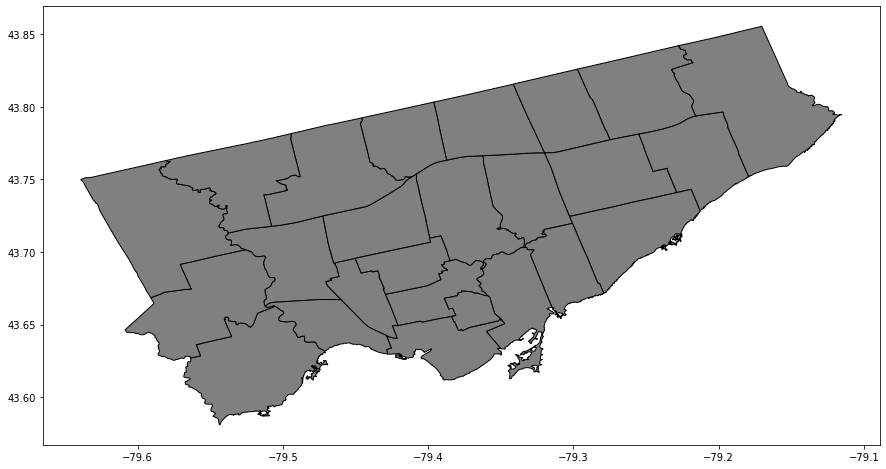

In [62]:
style.use("seaborn-pastel")
fig,ax=plt.subplots(figsize=(15,15))
trt_map.plot(ax=ax,color="grey",edgecolor='black')

In [63]:
crs={'init':'epsg:4326'}

In [64]:
raw_gdf=February_location_coordinates.rename(columns={"Lat": "Longitude", "Lng": "Latitude"})

In [69]:
raw_gdf.head()

location Longitude Latitude
0  2531 LAKE SHORE BLVD W  -79.4873  43.6101
1          118 GOTHIC AVE   -79.469  43.6562
2       259 DELORAINE AVE   -79.414  43.7318
3           50 QUEBEC AVE  -79.4681  43.6544
4             305 SHAW ST  -79.4183  43.6504

In [70]:
raw_gdf["Longitude float"]=pd.to_numeric(raw_gdf["Longitude"], downcast='float')

In [74]:
raw_gdf["Latitude float"]=pd.to_numeric(raw_gdf["Latitude"], downcast='float')
raw_gdf

location Longitude Latitude  Longitude float  \
0      2531 LAKE SHORE BLVD W  -79.4873  43.6101       -79.487297   
1              118 GOTHIC AVE   -79.469  43.6562       -79.468964   
2           259 DELORAINE AVE   -79.414  43.7318       -79.414040   
3               50 QUEBEC AVE  -79.4681  43.6544       -79.468079   
4                 305 SHAW ST  -79.4183  43.6504       -79.418259   
5             121 SCOLLARD ST  -79.3927  43.6715       -79.392715   
6            128 MOUNTJOY AVE   -79.327  43.6811       -79.327019   
7         2468 EGLINTON AVE W  -79.4681   43.692       -79.468140   
8            110 CHARLES ST E  -79.3806  43.6701       -79.380554   
9             49 HAZELTON AVE  -79.3934  43.6723       -79.393410   
10            28 HOLBORNE AVE  -79.3247  43.6935       -79.324730   
11          235 DELORAINE AVE  -79.4134  43.7319       -79.413353   
12         1340 DANFORTH ROAD  -79.2457  43.7435       -79.245750   
13            51 HAZELTON AVE  -79.3934  43.6724       -79.393417   
14             325 QUEBEC AVE  -79.4702  43.6616       -79.470169   
15          98 FORT YORK BLVD  -79.3971  43.6399       -79.397141   
16              14 MEADOW AVE  -79.2835   43.682       -79.283478   
17              25 ST MARY ST  -79.3877   43.668       -79.387711   
18            88 CHARLES ST E  -79.3815  43.6699       -79.381523   
19             15 WEBSTER AVE   -79.395  43.6737       -79.394958   
20               1 MEADOW AVE  -79.2837  43.6816       -79.283730   
21          70 DAN LECKIE WAY  -79.3981  43.6389       -79.398109   
22             517 QUEBEC AVE  -79.4723  43.6667       -79.472305   
23      366 VICTORIA PARK AVE  -79.2841  43.6802       -79.284058   
24               1 SNIDER AVE  -79.4607  43.6938       -79.460678   
25        2155 LAWRENCE AVE E  -79.2854  43.7471       -79.285439   
26          1344 GERRARD ST E  -79.3246  43.6719       -79.324646   
27          204 WILTSHIRE AVE  -79.4541  43.6725       -79.454132   
28             78 LOWTHER AVE  -79.4001  43.6703       -79.400146   
29          309 HIGH PARK AVE  -79.4695  43.6643       -79.469528   
...                       ...       ...      ...              ...   
41804        77 ARLETA AVENUE  -79.5014  43.7453       -79.501427   
41805         71 NEWCASTLE ST  -79.4982  43.6175       -79.498199   
41806            189 PAPE AVE  -79.3385  43.6642       -79.338524   
41807             42 BOON AVE  -79.4471  43.6785       -79.447098   
41808           205 BONIS AVE  -79.2915  43.7858       -79.291527   
41809           74 JASPER AVE  -79.4858  43.6823       -79.485817   
41810           230 BONIS AVE  -79.2938  43.7855       -79.293808   
41811       343 LIPPINCOTT ST  -79.4094  43.6647       -79.409370   
41812       1 HUMBERVALE BLVD  -79.5084  43.6428       -79.508423   
41813        218 MONTROSE AVE  -79.4189  43.6561       -79.418900   
41814        5 ST EMILION WAY  -79.6047   43.754       -79.604736   
41815       17 ST EMILION WAY  -79.6045  43.7544       -79.604538   
41816        74 BELGRAVIA AVE  -79.4427  43.6992       -79.442741   
41817       76 BIRDSTONE CRES  -79.4685  43.6744       -79.468536   
41818            46 BAROLO RD  -79.6036  43.7522       -79.603577   
41819       68 BIRDSTONE CRES  -79.4684  43.6742       -79.468376   
41820             206 BETA ST  -79.5403  43.6067       -79.540291   
41821        34 VIEWMOUNT AVE  -79.4302  43.7102       -79.430237   
41822           27 AVENING DR  -79.5994  43.7398       -79.599373   
41823          44 MABELLE AVE  -79.5298  43.6463       -79.529846   
41824           63 AVENING DR  -79.5979  43.7372       -79.597893   
41825          68 GOODVIEW RD  -79.3542  43.7838       -79.354172   
41826         1305 WILSON AVE   -79.495  43.7234       -79.494972   
41827        1 RON ATTWELL ST  -79.5323  43.7316       -79.532303   
41828    501 ADELAIDE ST EAST  -79.3653  43.6526       -79.365341   
41829      250 TWELFTH STREET  -79.5115  43.6007       -79.511520   
41830  109 OWARDO D

In [90]:
clean_gdf=(raw_gdf.dropna()).reset_index()
clean_gdf_1=clean_gdf[["location",'Longitude float',"Latitude float"]]
clean_gdf_1.head()

location  Longitude float  Latitude float
0  2531 LAKE SHORE BLVD W       -79.487297       43.610073
1          118 GOTHIC AVE       -79.468964       43.656223
2       259 DELORAINE AVE       -79.414040       43.731758
3           50 QUEBEC AVE       -79.468079       43.654449
4             305 SHAW ST       -79.418259       43.650421

In [91]:
geometry=[Point(xy) for xy in zip(clean_gdf_1['Longitude float'],clean_gdf_1['Latitude float'])]

In [92]:
gdf=gpd.GeoDataFrame(clean_gdf_1,
                     crs=crs,
                    geometry=geometry)
gdf

location  Longitude float  Latitude float  \
0      2531 LAKE SHORE BLVD W       -79.487297       43.610073   
1              118 GOTHIC AVE       -79.468964       43.656223   
2           259 DELORAINE AVE       -79.414040       43.731758   
3               50 QUEBEC AVE       -79.468079       43.654449   
4                 305 SHAW ST       -79.418259       43.650421   
5             121 SCOLLARD ST       -79.392715       43.671535   
6            128 MOUNTJOY AVE       -79.327019       43.681095   
7         2468 EGLINTON AVE W       -79.468140       43.692028   
8            110 CHARLES ST E       -79.380554       43.670086   
9             49 HAZELTON AVE       -79.393410       43.672337   
10            28 HOLBORNE AVE       -79.324730       43.693504   
11          235 DELORAINE AVE       -79.413353       43.731918   
12         1340 DANFORTH ROAD       -79.245750       43.743477   
13            51 HAZELTON AVE       -79.393417       43.672409   
14             325 QUEBEC AVE       -79.470169       43.661587   
15          98 FORT YORK BLVD       -79.397141       43.639912   
16              14 MEADOW AVE       -79.283478       43.681988   
17              25 ST MARY ST       -79.387711       43.667957   
18            88 CHARLES ST E       -79.381523       43.669907   
19             15 WEBSTER AVE       -79.394958       43.673698   
20               1 MEADOW AVE       -79.283730       43.681557   
21          70 DAN LECKIE WAY       -79.398109       43.638897   
22             517 QUEBEC AVE       -79.472305       43.666710   
23      366 VICTORIA PARK AVE       -79.284058       43.680172   
24               1 SNIDER AVE       -79.460678       43.693794   
25        2155 LAWRENCE AVE E       -79.285439       43.747082   
26          1344 GERRARD ST E       -79.324646       43.671886   
27          204 WILTSHIRE AVE       -79.454132       43.672501   
28             78 LOWTHER AVE       -79.400146       43.670300   
29          309 HIGH PARK AVE       -79.469528       43.664310   
...                       ...              ...             ...   
41735         63 NEWCASTLE ST       -79.497978       43.617584   
41736        77 ARLETA AVENUE       -79.501427       43.745262   
41737         71 NEWCASTLE ST       -79.498199       43.617542   
41738            189 PAPE AVE       -79.338524       43.664230   
41739             42 BOON AVE       -79.447098       43.678505   
41740           205 BONIS AVE       -79.291527       43.785828   
41741           74 JASPER AVE       -79.485817       43.682308   
41742           230 BONIS AVE       -79.293808       43.785461   
41743       343 LIPPINCOTT ST       -79.409370       43.664715   
41744       1 HUMBERVALE BLVD       -79.508423       43.642792   
41745        218 MONTROSE AVE       -79.418900       43.656075   
41746        5 ST EMILION WAY       -79.604736       43.753990   
41747       17 ST EMILION WAY       -79.604538       43.754448   
41748        74 BELGRAVIA AVE       -79.442741       43.699181   
41749       76 BIRDSTONE CRES       -79.468536       43.674377   
41750            46 BAROLO RD       -79.603577       43.752251   
41751       68 BIRDSTONE CRES       -79.468376       43.674171   
41752             206 BETA ST       -79.540291       43.606651   
41753        34 VIEWMOUNT AVE       -79.430237       43.710217   
41754           27 AVENING DR       -79.599373       43.739807   
41755          44 MABELLE AVE       -79.529846       43.646297   
41756           63 AVENING DR       -79.597893       43.737183   
41757          68 GOODVIEW RD       -79.354172       43.783779   
41758         1305 WILSON AVE       -79.494972       43.723438   
41759        1 RON ATTWELL ST       -79.532303       43.731609   
41760    501 ADELAIDE ST EAST       -79.365341       43.652557   
41761      250 TWELFTH STREET       -79.511520       43.600670   
41762  129 OWARDO DI SNTO CIR       -79.443039       43.658390   
41763           3 CAPREOL CRT       -79.395866       43.64033

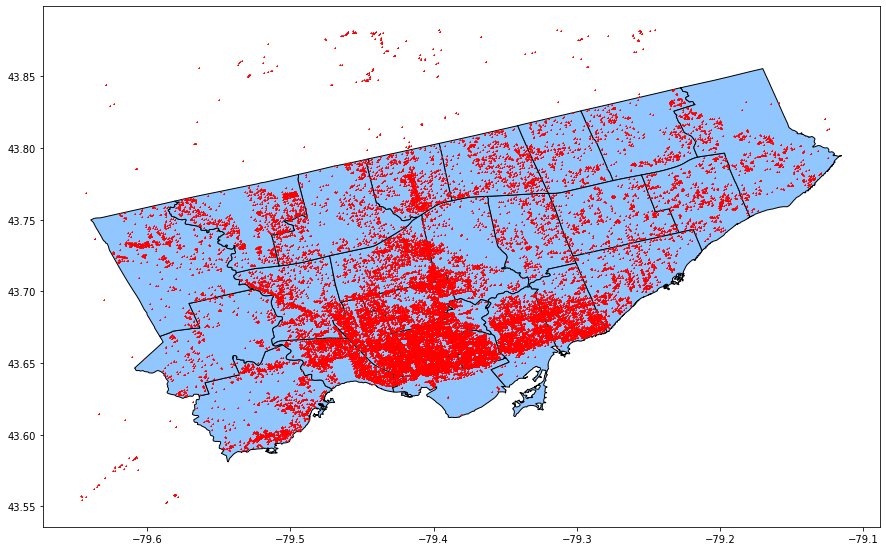

In [95]:
fig,ax=plt.subplots(figsize=(15,15))
trt_map.plot(ax=ax,edgecolor='black')
gdf.plot(ax=ax,markersize=1,color="red",marker="+")

In [97]:
trt_map

AREA_ID AREA_TYPE AREA_S_CD AREA_L_CD                 AREA_NAME  \
0   2551040      WD18        16        16           Don Valley East   
1   2551044      WD18        03        03       Etobicoke-Lakeshore   
2   2551048      WD18        15        15           Don Valley West   
3   2551052      WD18        23        23         Scarborough North   
4   2551056      WD18        11        11       University-Rosedale   
5   2551035      WD18        10        10         Spadina-Fort York   
6   2551039      WD18        09        09                 Davenport   
7   2551037      WD18        05        05         York South-Weston   
8   2551041      WD18        17        17          Don Valley North   
9   2551042      WD18        08        08         Eglinton-Lawrence   
10  2551043      WD18        02        02          Etobicoke Centre   
11  2551045      WD18        01        01           Etobicoke North   
12  2551046      WD18        04        04        Parkdale-High Park   
13  2551047      WD18        12        12        Toronto-St. Paul's   
14  2551049      WD18        22        22     Scarborough-Agincourt   
15  2551050      WD18        21        21        Scarborough Centre   
16  2551051      WD18        24        24     Scarborough-Guildwood   
17  2551053      WD18        25        25    Scarborough-Rouge Park   
18  2551054      WD18        20        20     Scarborough Southwest   
19  2551055      WD18        19        19         Beaches-East York   
20  2551057      WD18        18        18                Willowdale   
21  2551058      WD18        06        06               York Centre   
22  2551059      WD18        07        07  Humber River-Black Creek   
23  2551036      WD18        14        14          Toronto-Danforth   
24  2551038      WD18        13        13            Toronto Centre   

             X          Y  LONGITUDE   LATITUDE  \
0   318237.290  4844000.0  -79.33298  43.739716   
1   303099.474  4831000.0  -79.52087  43.621646   
2   314825.876  4843000.0  -79.37536  43.728396   
3   324522.149  4852000.0  -79.25467  43.809672   
4   313306.543  4837000.0  -79.39432  43.671139   
5   313874.844  4833000.0  -79.38733  43.635801   
6   309296.325  4836000.0  -79.44405  43.669353   
7   305318.582  4839000.0  -79.49337  43.694951   
8   316048.951  4850000.0  -79.36004  43.787602   
9   310114.447  4842000.0  -79.43385  43.718315   
10  300547.320  4836000.0  -79.55253  43.664431   
11  297962.207  4842000.0  -79.58467  43.719405   
12  307418.757  4834000.0  -79.46734  43.650121   
13  311717.970  4839000.0  -79.41399  43.690530   
14  320224.140  4851000.0  -79.30813  43.796483   
15  322773.613  4846000.0  -79.27661  43.752739   
16  327757.546  4847000.0  -79.21466  43.765798   
17  330785.479  4852000.0  -79.17684  43.805647   
18  324140.669  4841000.0  -79.25979  43.713627   
19  320369.412  4839000.0  -79.30667  43.689268   
20  311505.921  4848000.0  -79.41650  43.776886   
21  307376.567  4846000.0  -79.46781  43.752565   
22  302346.414  4845000.0  -79.53027  43.750724   
23  317748.204  4836000.0  -79.33925  43.665974   
24  315261.145  4835000.0  -79.37010  43.660143   

                                             geometry  
0   POLYGON ((-79.31334536599999 43.716986164, -79...  
1   POLYGON ((-79.497766447 43.651983193, -79.4972...  
2   POLYGON ((-79.352321171 43.715734879, -79.3520...  
3   POLYGON ((-79.22590696100001 43.839601785, -79...  
4   POLYGON ((-79.390039544 43.690503926, -79.3900...  
5   POLYGON ((-79.38376619100001 43.655715964, -79...  
6   POLYGON ((-79.446422517 43.68624846, -79.44611...  
7   POLYGON ((-79.469352134 43.708682823, -79.4688...  
8   POLYGON ((-79.38349240700001 43.76408173, -79....  
9   POLYGON ((-79.46457411900001 43.692173451, -79...  
10  POLYGON ((-79.527661976 43.701196247, -79.5259...  
11  POLYGON ((-79.57938234300001 43.762218312, -79...  
12  POLYGON ((-79.46934422699999 43.667299379, -79...  
13  POLYGON ((-79.388741841 43.691724973, -79.

In [99]:
gdf.to_csv("data.csv",index = None)

In [102]:
shapely.speedups.enable()

In [104]:
points_in_0=sum(gdf.within(trt_map.loc[0,'geometry']))
points_in_0

564

In [114]:
trt_map_count=trt_map.copy()

In [117]:
count = []
for index,row in trt_map_count.iterrows():
    count.append(sum(gdf.within(trt_map_count.loc[index,'geometry'])))

In [120]:
trt_map_count["count"]=count
trt_map_count

AREA_ID AREA_TYPE AREA_S_CD AREA_L_CD                 AREA_NAME  \
0   2551040      WD18        16        16           Don Valley East   
1   2551044      WD18        03        03       Etobicoke-Lakeshore   
2   2551048      WD18        15        15           Don Valley West   
3   2551052      WD18        23        23         Scarborough North   
4   2551056      WD18        11        11       University-Rosedale   
5   2551035      WD18        10        10         Spadina-Fort York   
6   2551039      WD18        09        09                 Davenport   
7   2551037      WD18        05        05         York South-Weston   
8   2551041      WD18        17        17          Don Valley North   
9   2551042      WD18        08        08         Eglinton-Lawrence   
10  2551043      WD18        02        02          Etobicoke Centre   
11  2551045      WD18        01        01           Etobicoke North   
12  2551046      WD18        04        04        Parkdale-High Park   
13  2551047      WD18        12        12        Toronto-St. Paul's   
14  2551049      WD18        22        22     Scarborough-Agincourt   
15  2551050      WD18        21        21        Scarborough Centre   
16  2551051      WD18        24        24     Scarborough-Guildwood   
17  2551053      WD18        25        25    Scarborough-Rouge Park   
18  2551054      WD18        20        20     Scarborough Southwest   
19  2551055      WD18        19        19         Beaches-East York   
20  2551057      WD18        18        18                Willowdale   
21  2551058      WD18        06        06               York Centre   
22  2551059      WD18        07        07  Humber River-Black Creek   
23  2551036      WD18        14        14          Toronto-Danforth   
24  2551038      WD18        13        13            Toronto Centre   

             X          Y  LONGITUDE   LATITUDE  \
0   318237.290  4844000.0  -79.33298  43.739716   
1   303099.474  4831000.0  -79.52087  43.621646   
2   314825.876  4843000.0  -79.37536  43.728396   
3   324522.149  4852000.0  -79.25467  43.809672   
4   313306.543  4837000.0  -79.39432  43.671139   
5   313874.844  4833000.0  -79.38733  43.635801   
6   309296.325  4836000.0  -79.44405  43.669353   
7   305318.582  4839000.0  -79.49337  43.694951   
8   316048.951  4850000.0  -79.36004  43.787602   
9   310114.447  4842000.0  -79.43385  43.718315   
10  300547.320  4836000.0  -79.55253  43.664431   
11  297962.207  4842000.0  -79.58467  43.719405   
12  307418.757  4834000.0  -79.46734  43.650121   
13  311717.970  4839000.0  -79.41399  43.690530   
14  320224.140  4851000.0  -79.30813  43.796483   
15  322773.613  4846000.0  -79.27661  43.752739   
16  327757.546  4847000.0  -79.21466  43.765798   
17  330785.479  4852000.0  -79.17684  43.805647   
18  324140.669  4841000.0  -79.25979  43.713627   
19  320369.412  4839000.0  -79.30667  43.689268   
20  311505.921  4848000.0  -79.41650  43.776886   
21  307376.567  4846000.0  -79.46781  43.752565   
22  302346.414  4845000.0  -79.53027  43.750724   
23  317748.204  4836000.0  -79.33925  43.665974   
24  315261.145  4835000.0  -79.37010  43.660143   

                                             geometry  count  
0   POLYGON ((-79.31334536599999 43.716986164, -79...    564  
1   POLYGON ((-79.497766447 43.651983193, -79.4972...   1375  
2   POLYGON ((-79.352321171 43.715734879, -79.3520...   1247  
3   POLYGON ((-79.22590696100001 43.839601785, -79...    484  
4   POLYGON ((-79.390039544 43.690503926, -79.3900...   4792  
5   POLYGON ((-79.38376619100001 43.655715964, -79...   2890  
6   POLYGON ((-79.446422517 43.68624846, -79.44611...   3554  
7   POLYGON ((-79.469352134 43.708682823, -79.4688...   1641  
8   POLYGON ((-79.38349240700001 43.76408173, -79....    748  
9   POLYGON ((-79.46457411900001 43.692173451, -79...   2159  
10  POLYGON ((-79.527661976 43.701196247, -79.5259...    359  
11  POLYGON ((-79.57938234300001 43.762218312, -79...    773  
12  POLYGON

In [159]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.resources import INLINE

NameError: name 'bokeh' is not defined

In [147]:
clean_count=trt_map_count[['geometry','count']]

In [152]:
#convert data to json
data_json=json.loads(trt_map_count.to_json())

#convert to string like object
clean_json=json.dumps(data_json)

In [153]:
pprint(clean_json)

('{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", '
 '"properties": {"AREA_ID": 2551040, "AREA_TYPE": "WD18", "AREA_S_CD": "16", '
 '"AREA_L_CD": "16", "AREA_NAME": "Don Valley East", "X": 318237.29, "Y": '
 '4844000.0, "LONGITUDE": -79.33298, "LATITUDE": 43.7397163906, "count": 564}, '
 '"geometry": {"type": "Polygon", "coordinates": [[[-79.313345366, '
 '43.716986164], [-79.319502057, 43.715632174], [-79.319834989, 43.7155908], '
 '[-79.320074013, 43.715558394], [-79.320073138, 43.715556565], '
 '[-79.319982764, 43.715182858], [-79.32001171, 43.71485434], [-79.320039147, '
 '43.71479463], [-79.320154094, 43.714678468], [-79.320248637, 43.714607172], '
 '[-79.320426807, 43.714579165], [-79.320668627, 43.714598022], '
 '[-79.320882558, 43.714578052], [-79.320920844, 43.714548559], '
 '[-79.320936266, 43.714496871], [-79.320911339, 43.714325073], '
 '[-79.320782128, 43.714119868], [-79.320728087, 43.714058841], '
 '[-79.320527942, 43.713982791], [-79.320301462,

 '[-79.498005423, 43.600066216], [-79.498078603, 43.599926696], '
 '[-79.498155635, 43.599782676], [-79.498183912, 43.599647655], '
 '[-79.498185854, 43.599503632], [-79.498133985, 43.599391113], [-79.49805774, '
 '43.599287595], [-79.497979561, 43.599202079], [-79.497991954, 43.599112066], '
 '[-79.497964864, 43.598972542], [-79.497938167, 43.598846522], '
 '[-79.497899085, 43.598720501], [-79.497839093, 43.598607982], '
 '[-79.497863092, 43.598513468], [-79.497995482, 43.598432459], [-79.49806408, '
 '43.598395644], [-79.498121282, 43.598364951], [-79.49820954, 43.59827944], '
 '[-79.498288125, 43.598162422], [-79.498362832, 43.598054406], '
 '[-79.498350451, 43.597937388], [-79.498321436, 43.597824869], '
 '[-79.498393029, 43.597793365], [-79.498478578, 43.59788338], [-79.498581147, '
 '43.597946392], [-79.498752243, 43.597928392], [-79.498860242, 43.597887886], '
 '[-79.498873399, 43.597824875], [-79.49898759, 43.597815875], [-79.499152874, '
 '43.597815876], [-79.499307707, 43.597

 '[-79.42178183, 43.651977051], [-79.422026734, 43.652630936], [-79.4223537, '
 '43.653503749], [-79.422517509, 43.653921683], [-79.422546377, 43.653995353], '
 '[-79.42270507, 43.654400252], [-79.422851116, 43.654777766], [-79.422876988, '
 '43.654844617], [-79.423092156, 43.65540077], [-79.423702764, 43.656978943], '
 '[-79.4237571, 43.657104759], [-79.423876654, 43.657413797], [-79.424315074, '
 '43.658547056], [-79.424328996, 43.658582818], [-79.424688328, 43.659506045], '
 '[-79.424790494, 43.659768563], [-79.425492641, 43.661559518], [-79.42565948, '
 '43.661984917], [-79.42580722, 43.662329563], [-79.425837222, 43.662399566], '
 '[-79.426101368, 43.663015696], [-79.426541311, 43.664085156], '
 '[-79.427296424, 43.665873922], [-79.427571455, 43.666520798], '
 '[-79.427860429, 43.667220785], [-79.42802411, 43.667628109], [-79.428155123, '
 '43.667954167], [-79.428432647, 43.668614869], [-79.42872054, 43.669304382], '
 '[-79.429019476, 43.670032069], [-79.429177673, 43.670426837], 

 '[-79.581358694, 43.627847574], [-79.581410242, 43.627883542], '
 '[-79.581524918, 43.627923963], [-79.581664353, 43.627946363], '
 '[-79.581725105, 43.627953329], [-79.581781311, 43.627959778], [-79.58190446, '
 '43.627959686], [-79.582065535, 43.627946064], [-79.582225823, 43.62792794], '
 '[-79.58241484, 43.627950303], [-79.58260464, 43.627990666], [-79.582787091, '
 '43.628040037], [-79.582967999, 43.628084907], [-79.583152037, 43.628143278], '
 '[-79.583300473, 43.628181961], [-79.583341469, 43.628192642], '
 '[-79.583534377, 43.628237502], [-79.583739702, 43.628291354], '
 '[-79.583900869, 43.628349742], [-79.584068629, 43.628399121], '
 '[-79.584089605, 43.62840618], [-79.584966074, 43.628673076], [-79.585136212, '
 '43.628719941], [-79.585293008, 43.628786404], [-79.585389651, 43.628818085], '
 '[-79.585590155, 43.62891926], [-79.585714187, 43.629038101], [-79.585832005, '
 '43.62916185], [-79.585928, 43.629284348], [-79.585997866, 43.629411268], '
 '[-79.586027649, 43.6295766

 '[-79.289886132, 43.773772891], [-79.289841736, 43.773783234], '
 '[-79.287239586, 43.774390171], [-79.28463491, 43.775003446], [-79.284614584, '
 '43.77500816], [-79.281156488, 43.775812218], [-79.279688799, 43.77615643], '
 '[-79.277395277, 43.776694266], [-79.277199755, 43.776738185], '
 '[-79.274776466, 43.777282439], [-79.274686573, 43.77730263], [-79.271786423, '
 '43.777936115], [-79.26905592, 43.778502635], [-79.267991729, 43.778706917], '
 '[-79.266033966, 43.779088694], [-79.264873945, 43.779313105], [-79.26476654, '
 '43.779333887], [-79.263917946, 43.779498042], [-79.263707708, 43.779538713], '
 '[-79.260344654, 43.780207825], [-79.257965832, 43.780650829], '
 '[-79.254979856, 43.781222538], [-79.254974707, 43.78120853], [-79.254945694, '
 '43.781131967], [-79.254915786, 43.781055572], [-79.254902747, 43.781023113], '
 '[-79.254885158, 43.780979347], [-79.254853795, 43.780903327], '
 '[-79.254832763, 43.780853559], [-79.254821687, 43.780827378], '
 '[-79.254802489, 43.7807

 '[-79.227799542, 43.709597093], [-79.227795173, 43.709569916], [-79.22779532, '
 '43.709537322], [-79.227799959, 43.709504729], [-79.227825632, 43.709458072], '
 '[-79.227852796, 43.709413587], [-79.227899503, 43.709352847], '
 '[-79.227931097, 43.709319238], [-79.227965673, 43.709293242], '
 '[-79.228000187, 43.709278111], [-79.228045199, 43.709263004], '
 '[-79.228078172, 43.709256565], [-79.228109628, 43.709256639], '
 '[-79.228133578, 43.709258865], [-79.228160522, 43.709263276], '
 '[-79.228206751, 43.709275285], [-79.228268971, 43.709296666], '
 '[-79.228361654, 43.709337095], [-79.228445379, 43.709372065], '
 '[-79.228524614, 43.709403756], [-79.22859041, 43.70942999], [-79.228684579, '
 '43.709471501], [-79.228782025, 43.709507035], [-79.2288171, 43.709530026], '
 '[-79.228861303, 43.709554147], [-79.22890603, 43.709580193], [-79.228946529, '
 '43.709600435], [-79.229034934, 43.709648667], [-79.229046208, 43.709638746], '
 '[-79.229086148, 43.709606561], [-79.229141984, 43.709

 '[-79.323022936, 43.681910608], [-79.323417563, 43.682842636], '
 '[-79.323423748, 43.682857219], [-79.32363917, 43.683365996], [-79.323807772, '
 '43.683769091], [-79.323974553, 43.684167797], [-79.324302568, 43.684979617], '
 '[-79.324659028, 43.685792332], [-79.324965269, 43.686599341], [-79.32512335, '
 '43.686972239], [-79.325290723, 43.687345747], [-79.325595257, 43.688049952], '
 '[-79.325858396, 43.688781282], [-79.326198575, 43.689673171], '
 '[-79.326574413, 43.690587219], [-79.327115093, 43.691926784], '
 '[-79.327288544, 43.692349206], [-79.328018297, 43.694136535], '
 '[-79.328781895, 43.695941598], [-79.329340668, 43.697382513], '
 '[-79.329489886, 43.697767323], [-79.329556597, 43.69793856], [-79.329590166, '
 '43.698129108], [-79.329596542, 43.698270461], [-79.328925667, 43.699079451], '
 '[-79.328449643, 43.699719504], [-79.328340961, 43.699863235], '
 '[-79.327307102, 43.701230346], [-79.327291023, 43.701251607], '
 '[-79.327099862, 43.701504362], [-79.327362416, 43.

 '[-79.331268528, 43.626439447], [-79.331338291, 43.626471594], [-79.33134932, '
 '43.62647161], [-79.331373223, 43.626471646], [-79.331397115, 43.626471681], '
 '[-79.33140628, 43.626482379], [-79.331406235, 43.626498402], [-79.331446615, '
 '43.626522495], [-79.331496167, 43.626550616], [-79.331536539, 43.626577383], '
 '[-79.331580587, 43.626601481], [-79.331628249, 43.626649618], '
 '[-79.331655766, 43.626669696], [-79.331666642, 43.626724459], '
 '[-79.331664709, 43.626760506], [-79.331651806, 43.626775178], '
 '[-79.331629721, 43.626780483], [-79.331607638, 43.626789803], '
 '[-79.331574477, 43.626816462], [-79.331519245, 43.626848426], '
 '[-79.331478723, 43.626875074], [-79.331451084, 43.626899067], '
 '[-79.331438158, 43.626917744], [-79.331428927, 43.626935094], '
 '[-79.331428868, 43.626956455], [-79.331428812, 43.626976492], '
 '[-79.331428746, 43.627000526], [-79.331465448, 43.627019275], [-79.33148566, '
 '43.627041323], [-79.331485965, 43.627078859], [-79.331491286, 43.6

'"'

In [168]:
geosource = GeoJSONDataSource(geojson = clean_json)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 500, high = 5000)
#Define custom tick labels for color bar.
tick_labels = {'0': '500', '5': '1000', '10':'1500', '15':'2000', 
               '20':'2500', '25':'3000', '30':'3500','35':'4000', '40': '>4500'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = 
                     tick_labels)

#Create figure object.
p = figure(title = 'Number of Parking Tickets on 25 Wards', plot_height = 600 ,
           plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' :'count', 
                                                      'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

Loading BokehJS ...